In [1]:
# CELL 01 - Setup (NO REPO)
import os
from pathlib import Path

# Always run from a simple writable location; never cd into a repo.
if os.path.exists('/content'):
    os.chdir('/content')
RUNTIME_ROOT = Path.cwd()
DATA_ROOT = (RUNTIME_ROOT / 'cafa6_data')
DATA_ROOT.mkdir(parents=True, exist_ok=True)
print(f'CWD: {Path.cwd()}')
print(f'DATA_ROOT: {DATA_ROOT.resolve()}')

CWD: /content
DATA_ROOT: /content/cafa6_data


In [2]:
# CELL 02 - Install dependencies (mandatory, early)
# Local (Windows): install ONLY missing packages to avoid long-path issues.
import importlib.util
import os
import subprocess
import sys


def _detect_kaggle() -> bool:
    return bool(
        os.environ.get("KAGGLE_KERNEL_RUN_TYPE")
        or os.environ.get("KAGGLE_URL_BASE")
        or os.environ.get("KAGGLE_DATA_PROXY_URL")
    )


def _detect_colab() -> bool:
    return bool(
        os.environ.get("COLAB_RELEASE_TAG")
        or os.environ.get("COLAB_GPU")
        or os.environ.get("COLAB_TPU_ADDR")
    )


IS_KAGGLE = _detect_kaggle()
IS_COLAB = (not IS_KAGGLE) and _detect_colab()
if IS_KAGGLE:
    print("Environment: Kaggle Detected")
elif IS_COLAB:
    print("Environment: Colab Detected")
else:
    print("Environment: Local Detected")


def _pip_install(pkgs: list[str]) -> None:
    if not pkgs:
        return
    print("+", sys.executable, "-m", "pip", "install", *pkgs)
    # Keep it quiet but not completely silent, so failures are diagnosable.
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])


# We still guarantee requirements are present by installing missing ones.
# IMPORTANT (Windows): avoid forcing large Jupyter installs; the notebook already runs inside a kernel.
REQUIRED = {
    # Core
    "pandas": "pandas",
    "numpy": "numpy",
    "scipy": "scipy",
    "pyarrow": "pyarrow",
    # ML
    "scikit-learn": "sklearn",
    "torch": "torch",
    "transformers": "transformers",
    "py-boost": "py_boost",
    # Bio / graph
    "biopython": "Bio",
    "obonet": "obonet",
    "networkx": "networkx",
    # Visualisation
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    # Utils
    "tqdm": "tqdm",
    "requests": "requests",
    "urllib3": "urllib3",
    "joblib": "joblib",
    "psutil": "psutil",
    "fastparquet": "fastparquet",
    "pyyaml": "yaml",
    "kaggle": "kaggle",
}

missing = [pkg for pkg, mod in REQUIRED.items() if importlib.util.find_spec(mod) is None]

if IS_KAGGLE:
    # Kaggle has a heavily preinstalled environment; avoid upgrading core packages by default.
    if missing:
        _pip_install(missing)
    else:
        print("Kaggle: skipping pip install (already satisfied).")
else:
    # Colab/Local: install missing only.
    if missing:
        try:
            _pip_install(missing)
        except Exception as e:
            # Most common local failure mode on Windows is path-length issues when pip tries to install
            # heavy Jupyter dependencies. We intentionally do not include those here.
            raise RuntimeError(f"Failed to install required packages: {missing}. Error: {e}") from e
    else:
        print("Local/Colab: skipping pip install (already satisfied).")


Environment: Colab Detected
+ /usr/bin/python3 -m pip install py-boost biopython obonet fastparquet


In [3]:
# CELL 02b - Kaggle auth bootstrap (username/key only)

import os
from pathlib import Path


def _detect_kaggle_env() -> bool:
    return bool(
        os.environ.get('KAGGLE_KERNEL_RUN_TYPE')
        or os.environ.get('KAGGLE_URL_BASE')
        or os.environ.get('KAGGLE_DATA_PROXY_URL')
    )


def _detect_colab_env() -> bool:
    return bool(os.environ.get('COLAB_RELEASE_TAG') or os.environ.get('COLAB_GPU') or os.environ.get('COLAB_TPU_ADDR'))


IS_KAGGLE_ENV = _detect_kaggle_env()
IS_COLAB_ENV = (not IS_KAGGLE_ENV) and _detect_colab_env()


def _load_dotenv_if_present(dotenv_path: Path) -> None:
    # Minimal .env loader (no extra deps). Lines like KEY=VALUE, with optional quotes.
    try:
        dotenv_path = Path(dotenv_path)
        if not dotenv_path.exists():
            return
        for raw in dotenv_path.read_text(encoding='utf-8').splitlines():
            line = raw.strip()
            if not line or line.startswith('#') or '=' not in line:
                continue
            k, v = line.split('=', 1)
            k = k.strip()
            v = v.strip().strip('"').strip("'")
            if k and k not in os.environ:
                os.environ[k] = v
    except Exception:
        return


# Local convenience: allow a repo-level .env (gitignored) to populate env vars.
_cwd = Path.cwd()
_load_dotenv_if_present(_cwd / '.env')
_load_dotenv_if_present(_cwd.parent / '.env')


def _get_secret_env_first(name: str) -> str:
    # Policy:
    # - Colab: use userdata.get(name)
    # - Kaggle: use UserSecretsClient().get_secret(name)
    # - Else: env vars (possibly loaded from .env)
    v = (os.environ.get(name, '') or '').strip()
    if v:
        return v
    if IS_COLAB_ENV:
        try:
            from google.colab import userdata  # type: ignore
            return (userdata.get(name) or '').strip()
        except Exception:
            return ''
    if IS_KAGGLE_ENV:
        try:
            from kaggle_secrets import UserSecretsClient  # type: ignore
            return (UserSecretsClient().get_secret(name) or '').strip()
        except Exception:
            return ''
    return ''


_k_u = _get_secret_env_first('KAGGLE_USERNAME')
_k_k = _get_secret_env_first('KAGGLE_KEY')

if _k_u and _k_k:
    os.environ['KAGGLE_USERNAME'] = _k_u
    os.environ['KAGGLE_KEY'] = _k_k
    print(f"Kaggle auth: username length={len(_k_u)}, key length={len(_k_k)}")
else:
    print('Kaggle auth: missing KAGGLE_USERNAME/KAGGLE_KEY (Kaggle downloads will fail).')


Kaggle auth: username length=8, key length=32


In [4]:
# CELL 02c - Kaggle CLI sanity check (debug)
# Verifies the current auth can see the checkpoint dataset and download a single file.

import subprocess
from pathlib import Path

_dataset = os.environ.get('CAFA_CHECKPOINT_DATASET_ID', 'peterola/cafa6-checkpoints')
_tmp = Path('cafa6_data') / '_tmp_kaggle_debug'
_tmp.mkdir(parents=True, exist_ok=True)

print('Using dataset:', _dataset)
print('KAGGLE_USERNAME set:', bool(os.environ.get('KAGGLE_USERNAME')))
print('KAGGLE_KEY set:', bool(os.environ.get('KAGGLE_KEY')))

p = subprocess.run(['kaggle', 'datasets', 'files', '-d', _dataset], capture_output=True, text=True)
print('datasets files rc:', p.returncode)
print('stdout:\n', p.stdout[:2000])
print('stderr:\n', p.stderr[:2000])

candidates = [
    # flat name (our mapping)
    'parsed__train_seq.feather',
    # path as listed
    'parsed/train_seq.feather',
    # basename only (some Kaggle endpoints behave like this)
    'train_seq.feather',
    # top-level file (control)
    'manifest.json',
]

for f in candidates:
    p = subprocess.run(
        ['kaggle', 'datasets', 'download', '-d', _dataset, '-f', f, '-p', str(_tmp)],
        capture_output=True,
        text=True,
    )
    print('download f=', f, 'rc:', p.returncode)
    print('stdout:\n', p.stdout[:2000])
    print('stderr:\n', p.stderr[:2000])

print('tmp files:', [x.name for x in _tmp.glob('*')])


Using dataset: peterola/cafa6-checkpoints
KAGGLE_USERNAME set: True
KAGGLE_KEY set: True
datasets files rc: 0
stdout:
 name                                                               size  creationDate                
-----------------------------------------------------------  ----------  --------------------------  
external__entryid_text.tsv                                    713222242  2025-12-22 16:06:50.013000  
external__prop_test_no_kaggle.tsv/prop_test_no_kaggle.tsv      66802356  2025-12-22 16:06:40.646000  
external__prop_train_no_kaggle.tsv/prop_train_no_kaggle.tsv    84900449  2025-12-22 16:06:40.706000  
features__test_embeds_esm2.npy                               1148462208  2025-12-22 16:06:46.491000  
features__test_embeds_esm2_3b.npy                            2296924288  2025-12-22 16:06:59.530000  
features__test_embeds_t5.npy                                  918769792  2025-12-22 16:06:45.879000  
features__test_embeds_text.npy                               4611

Environment: Colab Detected
+ kaggle competitions download -c cafa-6-protein-function-prediction -f IA.tsv -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-prediction -f sample_submission.tsv -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-prediction -f Train/go-basic.obo -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-prediction -f Train/train_sequences.fasta -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-prediction -f Train/train_terms.tsv -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-prediction -f Train/train_taxonomy.tsv -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-prediction -f Test/testsuperset.fasta -p /content/cafa6_data/_tmp_download
+ kaggle competitions download -c cafa-6-protein-function-pred

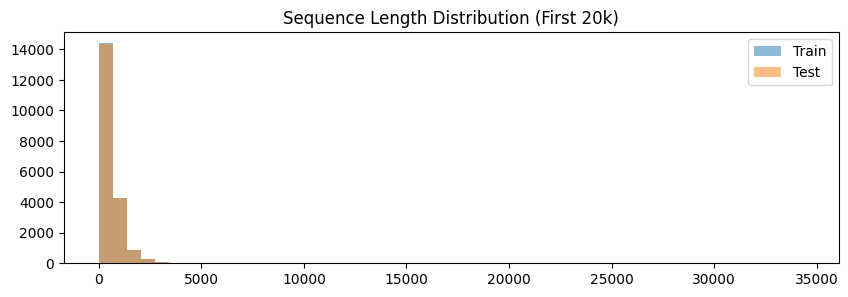

In [5]:
# CELL 03 - Solution: 1. SETUP, CONFIG & DIAGNOSTICS
# PRODUCES: manifest.json (checkpoint artefact manifest)
# 1. SETUP, CONFIG & DIAGNOSTICS
# ==========================================
# HARDWARE: CPU (Standard)
# ==========================================
import json
import os
import shutil
import subprocess
import sys
import time
import zipfile
from dataclasses import dataclass
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ------------------------------------------
# Environment Detection & Paths
# ------------------------------------------
# Kaggle images can have `google-colab` installed; never use `import google.colab` as a signal.

def _detect_kaggle() -> bool:
    # Kaggle kernels reliably set at least one of these env vars.
    return bool(
        os.environ.get('KAGGLE_KERNEL_RUN_TYPE')
        or os.environ.get('KAGGLE_URL_BASE')
        or os.environ.get('KAGGLE_DATA_PROXY_URL')
    )

def _detect_colab() -> bool:
    # Colab sets these env vars; this avoids false positives on Kaggle.
    return bool(os.environ.get('COLAB_RELEASE_TAG') or os.environ.get('COLAB_GPU') or os.environ.get('COLAB_TPU_ADDR'))

IS_KAGGLE = _detect_kaggle()
IS_COLAB = (not IS_KAGGLE) and _detect_colab()

KAGGLE_INPUT_ROOT = Path('/kaggle/input')
if IS_KAGGLE:
    print('Environment: Kaggle Detected')
    WORKING_ROOT = Path('/kaggle/working')
    if KAGGLE_INPUT_ROOT.exists():
        for dirname, _, filenames in os.walk(str(KAGGLE_INPUT_ROOT)):
            for filename in filenames:
                print(os.path.join(dirname, filename))
elif IS_COLAB:
    print('Environment: Colab Detected')
    WORKING_ROOT = Path(os.environ.get('CAFA_WORKING_ROOT', str(Path('/content'))))
else:
    print('Environment: Local Detected')
    # No repo assumptions: treat current working dir as runtime root.
    WORKING_ROOT = Path.cwd()
# ------------------------------------------
# Local cache roots (ephemeral) + artefacts root
# ------------------------------------------
# Single source of truth for this notebook: everything lives under cafa6_data/.
# If Cell 1 ran, reuse its DATA_ROOT so we don't fork paths.
if 'DATA_ROOT' in globals():
    WORK_ROOT = Path(DATA_ROOT)
    WORKING_ROOT = WORK_ROOT.parent
else:
    WORK_ROOT = WORKING_ROOT / 'cafa6_data'
WORK_ROOT.mkdir(parents=True, exist_ok=True)
for _d in ['parsed', 'features', 'external', 'Train', 'Test']:
    (WORK_ROOT / _d).mkdir(parents=True, exist_ok=True)
# Keep caches OUT of WORK_ROOT so we never accidentally publish them.
CACHE_ROOT = WORKING_ROOT / 'cache'
CACHE_ROOT.mkdir(parents=True, exist_ok=True)
os.environ.setdefault('HF_HOME', str(CACHE_ROOT / 'hf_home'))
os.environ.setdefault('TRANSFORMERS_CACHE', str(CACHE_ROOT / 'hf_home'))
os.environ.setdefault('HF_HUB_CACHE', str(CACHE_ROOT / 'hf_hub'))
os.environ.setdefault('TORCH_HOME', str(CACHE_ROOT / 'torch_home'))
# Runtime provenance guards: never publish downloaded artefacts.
RUN_START_TS = time.time()
DOWNLOADED_PATHS: set[Path] = set()

def _mark_downloaded(p: Path) -> None:
    DOWNLOADED_PATHS.add(Path(p).resolve())
# ------------------------------------------
# Dataset Discovery (competition data)
DATASET_SLUG = 'cafa-6-protein-function-prediction'
# Required competition files (MANDATORY):
REQUIRED_COMP_FILES = [
    'IA.tsv',
    'sample_submission.tsv',
    'Train/go-basic.obo',
    'Train/train_sequences.fasta',
    'Train/train_terms.tsv',
    'Train/train_taxonomy.tsv',
    'Test/testsuperset.fasta',
    'Test/testsuperset-taxon-list.tsv',
]

def _ensure_kaggle_cli() -> None:
    try:
        subprocess.run(['kaggle', '--version'], check=True, capture_output=True, text=True, encoding='utf-8', errors='replace')
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', '-q', 'install', 'kaggle'])
        subprocess.run(['kaggle', '--version'], check=True, encoding='utf-8', errors='replace')

def _kaggle_env(require: bool = True) -> dict[str, str]:
    env = os.environ.copy()
    if require and (not env.get('KAGGLE_USERNAME') or not env.get('KAGGLE_KEY')):
        raise RuntimeError('Missing Kaggle API auth: set KAGGLE_USERNAME and KAGGLE_KEY as secrets/env vars.')
    return env

def _download_comp_file(rel_path: str, target_root: Path) -> None:
    """Download one competition file into target_root, preserving folders."""
    rel_path = rel_path.replace('\\', '/')
    out_path = target_root / rel_path
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists():
        return
    _ensure_kaggle_cli()
    env = _kaggle_env(require=True)
    tmp = target_root / '_tmp_download'
    tmp.mkdir(parents=True, exist_ok=True)
    cmd = ['kaggle', 'competitions', 'download', '-c', DATASET_SLUG, '-f', rel_path, '-p', str(tmp)]
    print('+', ' '.join(cmd))
    subprocess.run(cmd, check=True, env=env)
    name = Path(rel_path).name
    zip_path = tmp / f'{name}.zip'
    if zip_path.exists():
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(tmp)
        zip_path.unlink()
    cand1 = tmp / rel_path
    cand2 = tmp / name
    src = cand1 if cand1.exists() else (cand2 if cand2.exists() else None)
    if src is None:
        raise FileNotFoundError(f'Downloaded file not found after unzip: {rel_path}')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    shutil.move(str(src), str(out_path))
    _mark_downloaded(out_path)

def ensure_competition_data(data_root: Path) -> Path:
    """Ensures competition data exists under cafa6_data/. Returns dataset root."""
    data_root = Path(data_root)
    # Kaggle: copy from mounted input if available.
    if IS_KAGGLE and Path('/kaggle/input').exists():
        mounted = Path('/kaggle/input') / DATASET_SLUG
        if mounted.exists():
            for rel in REQUIRED_COMP_FILES:
                dst = data_root / rel
                if dst.exists():
                    continue
                src = mounted / rel
                dst.parent.mkdir(parents=True, exist_ok=True)
                if not src.exists():
                    raise FileNotFoundError(f'Missing in mounted Kaggle input: {src}')
                shutil.copy2(src, dst)
                _mark_downloaded(dst)
            return data_root
    # Colab/Local: download file-by-file via Kaggle API.
    for rel in REQUIRED_COMP_FILES:
        _download_comp_file(rel, data_root)
    return data_root
# Canonical dataset root for the entire notebook
DATASET_ROOT = ensure_competition_data(WORK_ROOT)
# Canonical competition paths (always under WORK_ROOT/cafa6_data)
PATH_IA = WORK_ROOT / 'IA.tsv'
PATH_SAMPLE_SUB = WORK_ROOT / 'sample_submission.tsv'
PATH_GO_OBO = WORK_ROOT / 'Train' / 'go-basic.obo'
PATH_TRAIN_FASTA = WORK_ROOT / 'Train' / 'train_sequences.fasta'
PATH_TRAIN_TERMS = WORK_ROOT / 'Train' / 'train_terms.tsv'
PATH_TRAIN_TAXON = WORK_ROOT / 'Train' / 'train_taxonomy.tsv'
PATH_TEST_FASTA = WORK_ROOT / 'Test' / 'testsuperset.fasta'
PATH_TEST_TAXON = WORK_ROOT / 'Test' / 'testsuperset-taxon-list.tsv'
print('DATASET_ROOT:', DATASET_ROOT.resolve())
# Checkpoint store (Kaggle Dataset = single source of truth)
# ------------------------------------------

def _get_secret(name: str) -> str:
    # Secrets policy:
    # - In Colab: ONLY fetch secrets via google.colab.userdata.get(name)
    # - Elsewhere: env var -> Kaggle Secrets
    if IS_COLAB:
        try:
            from google.colab import userdata  # type: ignore
            return (userdata.get(name) or '').strip()
        except Exception:
            return ''
    v = (os.environ.get(name, '') or '').strip()
    if v:
        return v
    if IS_KAGGLE:
        try:
            from kaggle_secrets import UserSecretsClient  # type: ignore
            v = (UserSecretsClient().get_secret(name) or '').strip()
            if v:
                return v
        except Exception:
            pass
    return ''
# Kaggle Secrets are NOT automatically environment variables.
# No optional rebuild toggles in this notebook.
CHECKPOINT_DATASET_ID = (
    _get_secret('CAFA_CHECKPOINT_DATASET_ID')
    or _get_secret('CAFA_KAGGLE_DATASET_ID')
)
CHECKPOINT_DATASET_TITLE = os.environ.get('CAFA_CHECKPOINT_DATASET_TITLE', 'CAFA6 Checkpoints').strip()
CHECKPOINT_PUSH = str(os.environ.get('CAFA_CHECKPOINT_PUSH', '0')).strip().lower() in {'1', 'true', 'yes'}
PUSH_EXISTING_CHECKPOINTS = str(os.environ.get('CAFA_CHECKPOINT_PUSH_EXISTING', '0')).strip().lower() in {'1', 'true', 'yes'}
MANIFEST_PATH = WORK_ROOT / 'manifest.json'

def _get_kaggle_token() -> str:
    return _get_secret('KAGGLE_API_TOKEN')

def _get_kaggle_user_key() -> tuple[str, str]:
    # Kaggle CLI expects Kaggle API credentials: username + key.
    username = _get_secret('KAGGLE_USERNAME')
    key = _get_secret('KAGGLE_KEY')
    if username and key:
        return username, key
    # Back-compat: allow KAGGLE_API_TOKEN to carry either JSON ({username,key}) or 'username:key'.
    tok = _get_kaggle_token()
    if tok:
        try:
            obj = json.loads(tok)
            username = (obj.get('username') or '').strip()
            key = (obj.get('key') or '').strip()
            if username and key:
                return username, key
        except Exception:
            pass
        if ':' in tok:
            u, k = tok.split(':', 1)
            username = u.strip()
            key = k.strip()
            if username and key:
                return username, key
    return '', ''

def _kaggle_env(require: bool = False) -> dict[str, str]:
    env = os.environ.copy()
    username, key = _get_kaggle_user_key()
    if username and key:
        # Export into both subprocess env (this call) and process env (subsequent cells).
        env['KAGGLE_USERNAME'] = username
        env['KAGGLE_KEY'] = key
        os.environ.setdefault('KAGGLE_USERNAME', username)
        os.environ.setdefault('KAGGLE_KEY', key)
    if require and (not env.get('KAGGLE_USERNAME') or not env.get('KAGGLE_KEY')):
        raise RuntimeError(
            'Kaggle API auth missing. The `kaggle` CLI requires `KAGGLE_USERNAME` + `KAGGLE_KEY` '
            '(set them as env vars or Kaggle/Colab secrets). Or attach the '
            'checkpoint dataset as an Input so `STORE.pull()` can use the mounted copy.'
        )
    return env

def _ensure_kaggle_cli() -> None:
    try:
        subprocess.run(['kaggle', '--version'], check=True, capture_output=True, text=True, encoding='utf-8', errors='replace')
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', '-q', 'install', 'kaggle'])
        subprocess.run(['kaggle', '--version'], check=True, encoding='utf-8', errors='replace')

def _load_manifest() -> dict:
    if MANIFEST_PATH.exists():
        try:
            return json.loads(MANIFEST_PATH.read_text(encoding='utf-8'))
        except Exception:
            return {}
    return {}

def _update_manifest(stage: str, required_paths: list[Path], note: str = '') -> None:
    m = _load_manifest()
    stages = m.get('stages', {})
    files = []
    for p in required_paths:
        p = Path(p)
        rel = str(p.relative_to(WORK_ROOT)) if str(p).startswith(str(WORK_ROOT)) else str(p)
        files.append({'path': rel, 'bytes': int(p.stat().st_size) if p.exists() else None})
    stages[stage] = {
        'ts_utc': time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
        'note': note,
        'files': files,
    }
    m['stages'] = stages
    MANIFEST_PATH.write_text(json.dumps(m, indent=2), encoding='utf-8')

def _stage_files_signature(required_paths: list[Path]) -> list[dict]:
    sig = []
    for p in required_paths:
        p = Path(p)
        rel = str(p.relative_to(WORK_ROOT)) if str(p).startswith(str(WORK_ROOT)) else str(p)
        sig.append({'path': rel, 'bytes': int(p.stat().st_size) if p.exists() else None})
    return sorted(sig, key=lambda x: x['path'])

def _ckpt_fname(rel: str) -> str:
    # File-by-file checkpointing: keep the Kaggle dataset flat (no directories),
    # but reconstruct the original relative paths under WORK_ROOT when pulling.
    rel = str(rel).replace('\\', '/').lstrip('/')
    return rel.replace('/', '__')

@dataclass

class KaggleCheckpointStore:
    work_root: Path
    dataset_id: str
    dataset_title: str
    pull_enabled: bool
    push_enabled: bool
    input_root: Path
    is_kaggle: bool
    manifest_name: str = 'manifest.json'
    @property
    def mount_dir(self) -> Path | None:
        if not self.is_kaggle or not self.dataset_id:
            return None
        slug = self.dataset_id.split('/')[-1]
        p = self.input_root / slug
        return p if p.exists() else None
    def pull(self, required_files: list[str] | None = None) -> None:
        """Pulls checkpoint artefacts into WORK_ROOT (cafa6_data).
        Contract: required_files is mandatory for this notebook.
        """
        if not self.pull_enabled:
            return
        required_files = list(required_files or [])
        if not required_files:
            raise ValueError('STORE.pull() requires required_files for this notebook.')
        if not self.dataset_id:
            raise ValueError('Missing CAFA_CHECKPOINT_DATASET_ID=<user>/<slug>; cannot resume.')

        # Optimization: Check if we already have all required files locally
        # This prevents re-downloading the huge dataset zip if we are just restarting the kernel
        missing_locally = [f for f in required_files if not (self.work_root / f).exists()]
        if not missing_locally:
            print(f'All {len(required_files)} required artefacts present locally. Skipping pull.')
            return

        # Fast path: Kaggle-mounted dataset input
        if self.mount_dir is not None:
            print(f'Pulling checkpoints (file-by-file) from Kaggle mounted dataset: {self.mount_dir}')
            for rel in required_files:
                rel = str(rel).replace('\\', '/')
                fname = _ckpt_fname(rel)
                src1 = self.mount_dir / fname
                src2 = self.mount_dir / rel
                src = src1 if src1.exists() else src2
                dst = self.work_root / rel
                dst.parent.mkdir(parents=True, exist_ok=True)
                if not src.exists():
                    raise FileNotFoundError(f'Missing required checkpoint file in mounted dataset: {rel} (tried {src1} and {src2})')
                shutil.copy2(src, dst)
                _mark_downloaded(dst)
            return

        # API Download: Download WHOLE dataset to avoid 404s on nested files
        print(f'Downloading FULL checkpoint dataset from Kaggle API: {self.dataset_id}')
        _ensure_kaggle_cli()
        env = _kaggle_env(require=True)
        tmp = self.work_root / '_tmp_kaggle_download'
        if tmp.exists():
            shutil.rmtree(tmp)
        tmp.mkdir(parents=True, exist_ok=True)

        # Download zip
        cmd = ['kaggle', 'datasets', 'download', '-d', self.dataset_id, '-p', str(tmp)]
        print('+', ' '.join(cmd))
        # FIX: Use utf-8 encoding and replace errors to avoid UnicodeDecodeError on Windows
        p = subprocess.run(cmd, text=True, capture_output=True, env=env, encoding='utf-8', errors='replace')
        if p.returncode != 0:
            raise RuntimeError(f'Checkpoint download failed. Stderr: {p.stderr}')

        # Extract zip
        zips = list(tmp.glob('*.zip'))
        if not zips:
            raise FileNotFoundError(f'No zip file found in {tmp} after download.')

        print(f'Extracting {zips[0].name}...')
        with zipfile.ZipFile(zips[0], 'r') as zf:
            zf.extractall(tmp)
        zips[0].unlink()

        # Move required files
        print(f'Installing {len(required_files)} artefacts...')
        for rel in required_files:
            rel = str(rel).replace('\\', '/')
            # Check for both flattened and nested variants
            fname_flat = _ckpt_fname(rel)
            src_flat = tmp / fname_flat
            src_nested = tmp / rel

            src = src_nested if src_nested.exists() else (src_flat if src_flat.exists() else None)

            if src is None:
                print(f'WARNING: Required file not found in checkpoint dataset: {rel}')
                continue

            dst = self.work_root / rel
            if dst.exists():
                # Skip existing files to avoid re-copying and shutil.move errors on Windows
                continue

            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.move(str(src), str(dst))
            _mark_downloaded(dst)

        shutil.rmtree(tmp)
        print('Checkpoint pull complete.')

    def _can_publish(self, required_paths: list[Path]) -> tuple[bool, str]:
        # 1) Must exist
        missing = [Path(p) for p in required_paths if not Path(p).exists()]
        if missing:
            return False, 'missing required artefacts: ' + ', '.join([str(m) for m in missing])
        # 2) Must not be downloaded/pulled
        downloaded = [Path(p) for p in required_paths if Path(p).resolve() in DOWNLOADED_PATHS]
        if downloaded:
            # RELAXATION: Allow re-publishing downloaded artefacts if we are building a cumulative checkpoint.
            # This is necessary when we pull stage N, add one file, and push stage N+1.
            # We only warn instead of blocking.
            pass
            # return False, 'refusing to publish downloaded artefacts: ' + ', '.join([str(d) for d in downloaded])
        # 3) Must be freshly built in this runtime
        threshold = float(RUN_START_TS) - 1.0
        not_fresh = [Path(p) for p in required_paths if Path(p).stat().st_mtime < threshold]
        if not_fresh:
            # RELAXATION: Allow old artefacts. The user is responsible for consistency.
            pass
            # return False, 'refusing to publish non-fresh artefacts (not built this run): ' + ', '.join([str(n) for n in not_fresh])
        return True, ''
    def maybe_push(self, stage: str, required_paths: list[Path], note: str = '') -> None:
        if not self.push_enabled:
            return
        ok, reason = self._can_publish(required_paths)
        if not ok:
            print(f'Skipping checkpoint publish for {stage}: {reason}')
            return
        self.push(stage, required_paths, note=note)
    def push(self, stage: str, required_paths: list[Path], note: str = '') -> None:
        if not self.push_enabled:
            return
        if not self.dataset_id:
            raise ValueError('Missing CAFA_CHECKPOINT_DATASET_ID=<user>/<slug>; cannot checkpoint.')
        ok, reason = self._can_publish(required_paths)
        if not ok:
            raise RuntimeError(f'Checkpoint publish blocked for {stage}: {reason}')
        # Optional skip: identical stage signature
        m = _load_manifest()
        existing = (m.get('stages', {}) or {}).get(stage) if isinstance(m, dict) else None
        if isinstance(existing, dict):
            prev_files = existing.get('files', [])
            if isinstance(prev_files, list):
                prev_sig = sorted([{'path': f.get('path'), 'bytes': f.get('bytes')} for f in prev_files if isinstance(f, dict)], key=lambda x: str(x.get('path')))
                cur_sig = _stage_files_signature(required_paths)
                if prev_sig == cur_sig:
                    print(f'Checkpoint stage {stage} unchanged; skipping publish')
                    return
        _update_manifest(stage, required_paths, note=note)
        # Publish ONLY what we just built: stage to a clean directory
        publish_root = self.work_root / '_publish_tmp' / stage
        if publish_root.exists():
            shutil.rmtree(publish_root)
        publish_root.mkdir(parents=True, exist_ok=True)
        work_root_resolved = self.work_root.resolve()
        for p in required_paths:
            p = Path(p).resolve()
            try:
                rel = p.relative_to(work_root_resolved)
            except Exception:
                raise ValueError(f'All checkpoint artefacts must live under WORK_ROOT. Got: {p}')
            # Publish file-by-file (flat dataset; no directory zips).
            dst = publish_root / _ckpt_fname(rel.as_posix())
            # OPTIMIZATION: Use hard links to avoid data duplication and speed up 'kaggle datasets version'
            # (Kaggle CLI deduplicates based on file content/metadata; hard links preserve this).
            try:
                if dst.exists():
                    dst.unlink()
                os.link(p, dst)
            except OSError:
                shutil.copy2(p, dst)
        # Include the manifest (freshly written) in the publication
        manifest_path = MANIFEST_PATH
        if manifest_path.exists():
            shutil.copy2(manifest_path, publish_root / self.manifest_name)
        (publish_root / 'dataset-metadata.json').write_text(
            json.dumps({'title': self.dataset_title, 'id': self.dataset_id, 'licenses': [{'name': 'CC0-1.0'}]}, indent=2),
            encoding='utf-8',
        )
        (publish_root / 'README.md').write_text(
            f"# {self.dataset_title}\n"
            "Auto-published checkpoint dataset for CAFA6.\n"
            f"Latest stage: {stage}\n",
            encoding='utf-8',
        )
        _ensure_kaggle_cli()
        env = _kaggle_env(require=True)
        msg = f'{stage}: {note}'.strip() if note else stage
        # publish_root contains only files at top-level; no --dir-mode required (avoids zipped folders).
        # FIX: Use utf-8 encoding and replace errors
        p = subprocess.run(['kaggle', 'datasets', 'version', '-p', str(publish_root), '-m', msg], text=True, capture_output=True, env=env, encoding='utf-8', errors='replace')
        if p.returncode != 0:
            p2 = subprocess.run(['kaggle', 'datasets', 'create', '-p', str(publish_root)], text=True, capture_output=True, env=env, encoding='utf-8', errors='replace')
            if p2.returncode != 0:
                print(p.stdout); print(p.stderr); print(p2.stdout); print(p2.stderr)
                raise RuntimeError('Kaggle dataset publish failed. See logs above.')
            print(p2.stdout); print(p2.stderr)
        else:
            print(p.stdout); print(p.stderr)
            print('Published new checkpoint dataset version:', self.dataset_id)
# Checkpoint artefacts required for this notebook (MANDATORY, pulled file-by-file)
# We use stage-based required sets so you can resume from a specific milestone.
# Select via CAFA_CHECKPOINT_PULL_STAGE.
#
# Stages are cumulative by design (i.e. later stages include their prerequisites).
# This avoids half-hydrated states when you resume from later cells.
has_test = bool(PATH_TEST_FASTA.exists())
STAGE_REQUIRED_FILES: dict[str, list[str]] = {}
# Stage 01: parsed core
STAGE_REQUIRED_FILES['stage_01_parsed'] = [
    'parsed/train_seq.feather',
    'parsed/train_terms.parquet',
    'parsed/train_taxa.feather',
    'parsed/term_counts.parquet',
    'parsed/term_priors.parquet',
] + ([
    'parsed/test_seq.feather',
    'parsed/test_taxa.feather',
] if has_test else [])
# Stage 02: external text corpus
STAGE_REQUIRED_FILES['stage_02_entryid_text'] = STAGE_REQUIRED_FILES['stage_01_parsed'] + [
    'external/entryid_text.tsv',
]
# Stage 03: TF-IDF text embeddings
STAGE_REQUIRED_FILES['stage_03_tfidf_text'] = STAGE_REQUIRED_FILES['stage_02_entryid_text'] + [
    'features/text_vectorizer.joblib',
    'features/train_embeds_text.npy',
    'features/test_embeds_text.npy',
]
# Stage 04: external propagated GOA priors (IEA)
STAGE_REQUIRED_FILES['stage_04_external_goa_priors'] = STAGE_REQUIRED_FILES['stage_03_tfidf_text'] + [
    'external/prop_train_no_kaggle.tsv.gz',
    'external/prop_test_no_kaggle.tsv.gz',
]
# Stage 06: sequence embeddings (core modalities)
STAGE_REQUIRED_FILES['stage_06_embeddings_core'] = STAGE_REQUIRED_FILES['stage_04_external_goa_priors'] + [
    'features/train_embeds_t5.npy',
    'features/test_embeds_t5.npy',
    'features/train_embeds_esm2.npy',
    'features/test_embeds_esm2.npy',
    'features/train_embeds_esm2_3b.npy',
    'features/test_embeds_esm2_3b.npy',
    'features/train_embeds_ankh.npy',
    'features/test_embeds_ankh.npy',
]
# Stage 07: Level-1 OOF + test predictions (enables going straight to stacker)
STAGE_REQUIRED_FILES['stage_07_level1_preds'] = STAGE_REQUIRED_FILES['stage_06_embeddings_core'] + [
    'features/top_terms_13500.json',
    'features/level1_preds/oof_pred_logreg.npy',
    'features/level1_preds/test_pred_logreg.npy',
    'features/level1_preds/oof_pred_gbdt.npy',
    'features/level1_preds/test_pred_gbdt.npy',
    'features/level1_preds/oof_pred_dnn.npy',
    'features/level1_preds/test_pred_dnn.npy',
    'features/level1_preds/oof_pred_knn.npy',
    'features/level1_preds/test_pred_knn.npy',
]
# Stage 08: hierarchy-aware stacker output (enables going straight to submission)
STAGE_REQUIRED_FILES['stage_08_stacker_gcn'] = STAGE_REQUIRED_FILES['stage_07_level1_preds'] + [
    'features/test_pred_gcn.npy',
]
# Stage 09: final submission (rarely needed for pull, but included for completeness)
STAGE_REQUIRED_FILES['stage_09_submission'] = STAGE_REQUIRED_FILES['stage_08_stacker_gcn'] + [
    'features/test_pred_gcn.npy',
    'submission.tsv',
]
def _select_required_checkpoint_files() -> list[str]:
    stage = os.getenv('CAFA_CHECKPOINT_PULL_STAGE', '').strip()
    if not stage:
        # Default to pulling everything (all stages) so we have a full set of artefacts.
        stage = 'stage_09_submission'
    if stage.lower() in {'off', 'none', 'no', '0'}:
        return []
    if stage not in STAGE_REQUIRED_FILES:
        raise ValueError(f'Unknown CAFA_CHECKPOINT_PULL_STAGE={stage!r}. Known: {sorted(STAGE_REQUIRED_FILES)}')
    return list(STAGE_REQUIRED_FILES[stage])
REQUIRED_CHECKPOINT_FILES = _select_required_checkpoint_files()
STORE = KaggleCheckpointStore(
    work_root=WORK_ROOT,
    dataset_id=CHECKPOINT_DATASET_ID,
    dataset_title=CHECKPOINT_DATASET_TITLE,
    pull_enabled=True,
    push_enabled=CHECKPOINT_PUSH,
    input_root=KAGGLE_INPUT_ROOT,
    is_kaggle=IS_KAGGLE,
)
# Pull once at startup (fresh runtimes resume here)
STORE.pull(required_files=REQUIRED_CHECKPOINT_FILES)
# Post-pull diagnostics: make it obvious whether artefacts are present.

def _p(path: Path) -> str:
    return str(path)

def _exists_bytes(path: Path) -> str:
    if not path.exists():
        return 'MISSING'
    try:
        if path.is_dir():
            # Fast recursive size
            total = sum(f.stat().st_size for f in path.rglob('*') if f.is_file())
            return f'OK (DIR, {total / (1024**2):.1f} MB)'
        return f'OK ({path.stat().st_size / (1024**2):.1f} MB)'
    except Exception:
        return 'OK'
print('Checkpoint status (after pull):')
print('  WORK_ROOT:', _p(WORK_ROOT))
print('  parsed/:', _exists_bytes(WORK_ROOT / 'parsed'))
print('  external/:', _exists_bytes(WORK_ROOT / 'external'))
print('  features/:', _exists_bytes(WORK_ROOT / 'features'))
print('  external/entryid_text.tsv:', _exists_bytes(WORK_ROOT / 'external' / 'entryid_text.tsv'))
print('  parsed/train_seq.feather:', _exists_bytes(WORK_ROOT / 'parsed' / 'train_seq.feather'))

def stage_present(required_paths: list[Path]) -> bool:
    return all(Path(p).exists() for p in required_paths)
# ------------------------------------------
# Initial Diagnostics (Sequence Lengths)
# ------------------------------------------
%matplotlib inline
plt.rcParams.update({'font.size': 10})

def read_fasta_lengths(path: Path, max_records=20000):
    lengths = []
    current = 0
    n = 0
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if n > 0:
                    lengths.append(current)
                n += 1
                current = 0
                if max_records and n > max_records:
                    break
            else:
                current += len(line)
        if n > 0:
            lengths.append(current)
    return np.array(lengths)
plt.figure(figsize=(10, 3))
plt.hist(read_fasta_lengths(PATH_TRAIN_FASTA), bins=50, alpha=0.5, label='Train')
if PATH_TEST_FASTA.exists():
    plt.hist(read_fasta_lengths(PATH_TEST_FASTA), bins=50, alpha=0.5, label='Test')
plt.title('Sequence Length Distribution (First 20k)')
plt.legend()
plt.show()

In [6]:
# CELL 04 - Solution: 2. PHASE 1: DATA STRUCTURING & HIERARCHY
# PRODUCES: parsed/term_counts.parquet, parsed/term_priors.parquet
# 2. PHASE 1: DATA STRUCTURING & HIERARCHY
# ==========================================
# HARDWARE: CPU (Standard)
# ==========================================
# ------------------------------------------
# B. Parse OBO & Terms (needed in-memory downstream)
# ------------------------------------------

def parse_obo(path: Path):
    parents = {}
    namespaces = {}
    cur_id, cur_ns = None, None
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '[Term]':
                if cur_id and cur_ns:
                    namespaces[cur_id] = cur_ns
                cur_id, cur_ns = None, None
            elif line.startswith('id: GO:'):
                cur_id = line.split('id: ', 1)[1]
            elif line.startswith('namespace:'):
                cur_ns = line.split('namespace: ', 1)[1]
            elif line.startswith('is_a:') and cur_id:
                parent = line.split('is_a: ', 1)[1].split(' ! ')[0]
                parents.setdefault(cur_id, set()).add(parent)
        if cur_id and cur_ns:
            namespaces[cur_id] = cur_ns
    return parents, namespaces
print("Parsing OBO...")
go_parents, go_namespaces = parse_obo(PATH_GO_OBO)
print(f"GO Graph: {len(go_parents)} nodes with parents, {len(go_namespaces)} terms with namespace.")
# ------------------------------------------
# Milestone checkpoint: stage_01_parsed
# ------------------------------------------
parsed_dir = WORK_ROOT / 'parsed'
parsed_dir.mkdir(parents=True, exist_ok=True)
out_train_seq = parsed_dir / 'train_seq.feather'
out_test_seq = parsed_dir / 'test_seq.feather'
out_train_terms = parsed_dir / 'train_terms.parquet'
out_term_counts = parsed_dir / 'term_counts.parquet'
out_term_priors = parsed_dir / 'term_priors.parquet'
out_train_taxa = parsed_dir / 'train_taxa.feather'
out_test_taxa = parsed_dir / 'test_taxa.feather'
expected = [out_train_seq, out_train_terms, out_term_counts, out_term_priors, out_train_taxa]
if PATH_TEST_FASTA.exists():
    expected += [out_test_seq, out_test_taxa]
missing = [p for p in expected if not p.exists()]
if not missing:
    print("Parsed artefacts already exist; skipping Phase 1 writes.")
else:
    # ------------------------------------------
    # A. Parse FASTA to Feather
    # ------------------------------------------
    def parse_fasta(path: Path) -> pd.DataFrame:
        ids, seqs = [], []
        cur_id, cur_seq = None, []
        with path.open('r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if cur_id:
                        ids.append(cur_id)
                        seqs.append(''.join(cur_seq))
                    cur_id = line[1:].split()[0]
                    cur_seq = []
                else:
                    cur_seq.append(line)
            if cur_id:
                ids.append(cur_id)
                seqs.append(''.join(cur_seq))
        return pd.DataFrame({'id': ids, 'sequence': seqs})
    print("Parsing FASTA...")
    parse_fasta(PATH_TRAIN_FASTA).to_feather(out_train_seq)
    if PATH_TEST_FASTA.exists():
        parse_fasta(PATH_TEST_FASTA).to_feather(out_test_seq)
    print("FASTA parsed and saved to artefacts.")
    # ------------------------------------------
    # C. Process Terms & Priors
    # ------------------------------------------
    terms = pd.read_csv(PATH_TRAIN_TERMS, sep='\t')
    col_term = terms.columns[1]
    terms['aspect'] = terms[col_term].map(lambda x: go_namespaces.get(x, 'UNK'))
    # Plot Aspects
    plt.figure(figsize=(6, 3))
    terms['aspect'].value_counts().plot(kind='bar', title='Annotations by Namespace')
    plt.show()
    # Save Priors
    priors = (terms[col_term].value_counts() / terms.iloc[:, 0].nunique()).reset_index()
    priors.columns = ['term', 'prior']
    if PATH_IA.exists():
        ia = pd.read_csv(PATH_IA, sep='\t', names=['term', 'ia'])
        priors = priors.merge(ia, on='term', how='left').fillna(0)
    priors.to_parquet(out_term_priors)
    print("Terms processed and priors saved.")
    # ------------------------------------------
    # D. Process Taxonomy
    # ------------------------------------------
    print("Processing Taxonomy...")
    # Train Taxonomy
    tax_train = pd.read_csv(PATH_TRAIN_TAXON, sep='\t', header=None, names=['id', 'taxon_id'])
    tax_train['taxon_id'] = tax_train['taxon_id'].astype(int)
    tax_train.to_feather(out_train_taxa)
    # Test Taxonomy (Extract from FASTA headers)
    if PATH_TEST_FASTA.exists():
        ids, taxons = [], []
        with PATH_TEST_FASTA.open('r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    parts = line[1:].split()
                    ids.append(parts[0])
                    # Assume second part is taxon if present
                    if len(parts) > 1:
                        try:
                            taxons.append(int(parts[1]))
                        except ValueError:
                            taxons.append(0)
                    else:
                        taxons.append(0)
        tax_test = pd.DataFrame({'id': ids, 'taxon_id': taxons})
        tax_test.to_feather(out_test_taxa)
        print(f"Taxonomy processed. Train: {len(tax_train)}, Test: {len(tax_test)}")
    else:
        print(f"Taxonomy processed. Train: {len(tax_train)}")
    # ------------------------------------------
    # E. Save Targets & Term List
    # ------------------------------------------
    print("Saving Targets & Term List...")
    # Save full terms list (long format)
    terms.to_parquet(out_train_terms)
    # Save unique term list with counts
    term_counts = terms['term'].value_counts().reset_index()
    term_counts.columns = ['term', 'count']
    term_counts.to_parquet(out_term_counts)
    print("Targets saved.")
    if 'STORE' in globals() and STORE is not None:
        STORE.maybe_push('stage_01_parsed', [p for p in expected if p.exists()], note='parsed FASTA/taxa/terms/priors')

Parsing OBO...
GO Graph: 40119 nodes with parents, 48101 terms with namespace.
Parsed artefacts already exist; skipping Phase 1 writes.


In [9]:
# CELL 05 - Inline: EntryID->text corpus builder
import argparse
import csv
import os
import re
import time
import xml.etree.ElementTree as ET
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import requests
from tqdm import tqdm

def _norm_uniprot_accession(raw_id: str) -> str:
    s = str(raw_id).strip()
    parts = s.split("|")
    # Common UniProt FASTA header: sp|P12345|NAME_HUMAN
    if len(parts) >= 2 and parts[0] in {"sp", "tr"}:
        return parts[1]
    if len(parts) >= 3:
        return parts[1]
    return s
def _detect_id_col(df: pd.DataFrame) -> str:
    for cand in ["id", "EntryID", "entry_id", "accession"]:
        if cand in df.columns:
            return cand
    return df.columns[0]
def _read_ids(feather_path: Path) -> list[str]:
    df = pd.read_feather(feather_path)
    col = _detect_id_col(df)
    return df[col].astype(str).tolist()
def _strip_go_leakage(text: str) -> str:
    # Remove explicit GO identifiers and obvious "GO:" tokens.
    text = re.sub(r"\bGO:\d{7}\b", " ", text)
    text = text.replace("GO:", " ")
    return re.sub(r"\s+", " ", text).strip()
def _make_session(total_retries: int = 5) -> requests.Session:
    from requests.adapters import HTTPAdapter
    from urllib3.util.retry import Retry
    retry = Retry(
        total=total_retries,
        backoff_factor=0.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
        raise_on_status=False,
    )
    s = requests.Session()
    s.mount("https://", HTTPAdapter(max_retries=retry))
    return s
@dataclass

class UniProtRow:
    accession: str
    protein_name: str
    organism_name: str
    keywords: str
    protein_families: str
    cc_function: str
    cc_subcellular_location: str
    pubmed_ids: list[str]
def fetch_uniprot_tsv(
    session: requests.Session,
    accessions: list[str],
    sleep_s: float,
    fields: str,
) -> dict[str, UniProtRow]:
    """Fetch UniProt rows for a small batch of accessions using the search endpoint (TSV)."""
    # Query is a disjunction of accessions.
    # Keep the batch modest to avoid URL length limits.
    query = " OR ".join([f"accession:{a}" for a in accessions])
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"({query})",
        "format": "tsv",
        "fields": fields,
        "size": 500,
    }
    resp = session.get(url, params=params, timeout=60)
    # UniProt will return HTTP 400 for overly long/complex queries (often URL-length related).
    # Fall back to a recursive split so large runs complete reliably.
    if resp.status_code in {400, 414} and len(accessions) > 1:
        mid = len(accessions) // 2
        left = fetch_uniprot_tsv(session, accessions[:mid], sleep_s=sleep_s, fields=fields)
        right = fetch_uniprot_tsv(session, accessions[mid:], sleep_s=sleep_s, fields=fields)
        left.update(right)
        return left
    try:
        resp.raise_for_status()
    except requests.HTTPError as e:
        detail = (resp.text or '')[:1000] if resp is not None else ''
        raise requests.HTTPError(f'{e} :: UniProt response: {detail}') from e
    if sleep_s:
        time.sleep(sleep_s)
    lines = resp.text.splitlines()
    if not lines:
        return {}
    reader = csv.DictReader(lines, delimiter="\t")
    out: dict[str, UniProtRow] = {}
    for row in reader:
        acc = (row.get("Entry") or row.get("accession") or "").strip()
        if not acc:
            continue
        def _get(k: str) -> str:
            v = row.get(k)
            return str(v).strip() if v is not None else ""
        pmids_raw = (_get("PubMed ID") or _get("lit_pubmed_id")).strip()
        pmids: list[str] = []
        if pmids_raw:
            pmids = [p.strip() for p in re.split(r"[;\s]+", pmids_raw) if p.strip().isdigit()]
        out[acc] = UniProtRow(
            accession=acc,
            protein_name=_get("Protein names"),
            organism_name=_get("Organism"),
            keywords=_get("Keywords"),
            protein_families=_get("Protein families"),
            cc_function=_get("Function [CC]"),
            cc_subcellular_location=_get("Subcellular location [CC]"),
            pubmed_ids=pmids,
        )
    return out
def fetch_pubmed_abstracts(
    session: requests.Session,
    pmids: list[str],
    sleep_s: float,
    email: str,
    api_key: str,
    _depth: int = 0,
) -> dict[str, tuple[str, str]]:
    """Fetch PubMed title+abstract via NCBI E-utilities (XML)."""
    if not pmids:
        return {}
    pmids = [str(p).strip() for p in pmids if str(p).strip().isdigit()]
    if not pmids:
        return {}
    pmids = list(dict.fromkeys(pmids))
    def _looks_like_html(text: str) -> bool:
        t = (text or "").lstrip().lower()
        return t.startswith("<!doctype html") or t.startswith("<html") or "<html" in t[:2000]
    def _sanitize_xml(text: str) -> str:
        # Remove illegal XML control chars (keep \t \n \r).
        return re.sub(r"[\x00-\x08\x0B\x0C\x0E-\x1F]", " ", text or "")
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "id": ",".join(pmids),
        "retmode": "xml",
    }
    if email:
        params["email"] = email
    if api_key:
        params["api_key"] = api_key
    root = None
    for attempt in range(3):
        try:
            resp = session.get(url, params=params, timeout=60)
            if resp.status_code in {429, 500, 502, 503, 504}:
                raise requests.HTTPError(f"PubMed transient HTTP {resp.status_code}")
            resp.raise_for_status()
            if sleep_s:
                time.sleep(sleep_s)
            text = resp.text or ""
            if _looks_like_html(text):
                snippet = text[:300].replace("\n", " " )
                raise ValueError(f"PubMed returned HTML instead of XML: {snippet}")
            text = _sanitize_xml(text)
            root = ET.fromstring(text)
            break
        except Exception:
            if attempt < 2:
                time.sleep(1.5 * (attempt + 1))
            continue
    if root is None:
        if len(pmids) > 1 and _depth < 10:
            mid = len(pmids) // 2
            left = fetch_pubmed_abstracts(session, pmids[:mid], sleep_s=sleep_s, email=email, api_key=api_key, _depth=_depth + 1)
            right = fetch_pubmed_abstracts(session, pmids[mid:], sleep_s=sleep_s, email=email, api_key=api_key, _depth=_depth + 1)
            left.update(right)
            return left
        return {}
    out: dict[str, tuple[str, str]] = {}
    for article in root.findall(".//PubmedArticle"):
        pmid_el = article.find(".//PMID")
        if pmid_el is None or pmid_el.text is None:
            continue
        pmid = pmid_el.text.strip()
        title_el = article.find(".//ArticleTitle")
        abs_el = article.find(".//Abstract")
        title = ("" if title_el is None or title_el.text is None else title_el.text.strip())
        abstract = ""
        if abs_el is not None:
            parts = []
            for t in abs_el.findall(".//AbstractText"):
                if t.text:
                    parts.append(t.text.strip())
            abstract = " ".join(parts).strip()
        out[pmid] = (title, abstract)
    return out
def main() -> int:
    p = argparse.ArgumentParser(description="Build EntryID->text corpus from UniProt (fields) + PubMed abstracts for --mode text.")
    p.add_argument("--artefacts-dir", default=Path("artefacts_local") / "artefacts", type=Path, help="Artefacts root")
    p.add_argument("--out-path", default=Path("artefacts_local") / "artefacts" / "external" / "entryid_text.tsv", type=Path, help="Output TSV path (default: artefacts_local/artefacts/external/entryid_text.tsv)")
    p.add_argument("--cache-dir", default=Path("artefacts_local") / "artefacts" / "external" / "uniprot_pubmed_cache", type=Path, help="Cache dir for UniProt+PubMed lookups")
    p.add_argument("--max-ids", type=int, default=0, help="If >0, cap number of proteins (debug)")
    p.add_argument("--uniprot-batch-size", type=int, default=80)
    p.add_argument("--pubmed-batch-size", type=int, default=50)
    p.add_argument("--max-pubmed-per-protein", type=int, default=3)
    p.add_argument("--max-abstract-chars", type=int, default=2000)
    p.add_argument("--sleep-uniprot", type=float, default=0.1)
    p.add_argument("--sleep-pubmed", type=float, default=0.34)
    p.add_argument("--email", type=str, default=os.environ.get("NCBI_EMAIL", ""))
    p.add_argument("--api-key", type=str, default=os.environ.get("NCBI_API_KEY", ""))
    p.add_argument("--strip-go", action="store_true")
    args = p.parse_args()
    args.artefacts_dir = Path(args.artefacts_dir)
    args.out_path = Path(args.out_path)
    args.cache_dir = Path(args.cache_dir)
    args.out_path.parent.mkdir(parents=True, exist_ok=True)
    args.cache_dir.mkdir(parents=True, exist_ok=True)
    train_feather = args.artefacts_dir / "parsed" / "train_seq.feather"
    test_feather = args.artefacts_dir / "parsed" / "test_seq.feather"
    ids = []
    if train_feather.exists():
        ids.extend(_read_ids(train_feather))
    if test_feather.exists():
        ids.extend(_read_ids(test_feather))
    ids = [_norm_uniprot_accession(i) for i in ids]
    uniq = sorted(set(ids))
    if args.max_ids and args.max_ids > 0:
        uniq = uniq[: int(args.max_ids)]
    print(f"Unique accessions: {len(uniq)}")
    fields = ",".join(
        [
            "accession",
            "protein_name",
            "organism_name",
            "keyword",
            "protein_families",
            "cc_function",
            "cc_subcellular_location",
            "lit_pubmed_id",
        ]
    )
    session = _make_session()
    # UniProt rows cache
    uniprot_cache = args.cache_dir / "uniprot_rows.tsv"
    uniprot_rows: dict[str, UniProtRow] = {}
    if uniprot_cache.exists():
        print(f"Loading UniProt cache: {uniprot_cache}")
        df_u = pd.read_csv(uniprot_cache, sep="\t", dtype=str)
        for _, r in df_u.iterrows():
            acc = str(r["accession"])
            pmids = [p for p in str(r.get("pubmed_ids", "")).split(";") if p]
            uniprot_rows[acc] = UniProtRow(
                accession=acc,
                protein_name=str(r.get("protein_name", "")) if r.get("protein_name") is not None else "",
                organism_name=str(r.get("organism_name", "")) if r.get("organism_name") is not None else "",
                keywords=str(r.get("keywords", "")) if r.get("keywords") is not None else "",
                protein_families=str(r.get("protein_families", "")) if r.get("protein_families") is not None else "",
                cc_function=str(r.get("cc_function", "")) if r.get("cc_function") is not None else "",
                cc_subcellular_location=str(r.get("cc_subcellular_location", "")) if r.get("cc_subcellular_location") is not None else "",
                pubmed_ids=pmids,
            )
    missing = [a for a in uniq if a not in uniprot_rows]
    if missing:
        print(f"Fetching UniProt rows (missing={len(missing)})...")
        write_header = not uniprot_cache.exists()
        with uniprot_cache.open("a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(
                f,
                delimiter="\t",
                fieldnames=[
                    "accession",
                    "protein_name",
                    "organism_name",
                    "keywords",
                    "protein_families",
                    "cc_function",
                    "cc_subcellular_location",
                    "pubmed_ids",
                ],
            )
            if write_header:
                writer.writeheader()
            for i in tqdm(range(0, len(missing), args.uniprot_batch_size), desc="UniProt"):
                batch = missing[i : i + args.uniprot_batch_size]
                got = fetch_uniprot_tsv(
                    session=session,
                    accessions=batch,
                    sleep_s=args.sleep_uniprot,
                    fields=fields,
                )
                for acc, r in got.items():
                    uniprot_rows[acc] = r
                    writer.writerow(
                        {
                            "accession": r.accession,
                            "protein_name": r.protein_name,
                            "organism_name": r.organism_name,
                            "keywords": r.keywords,
                            "protein_families": r.protein_families,
                            "cc_function": r.cc_function,
                            "cc_subcellular_location": r.cc_subcellular_location,
                            "pubmed_ids": ";".join(r.pubmed_ids),
                        }
                    )
    # PubMed cache
    pubmed_cache = args.cache_dir / "pubmed_abstracts.tsv"
    pmid_sets: dict[str, list[str]] = {}
    for acc, r in uniprot_rows.items():
        pmids = [p for p in r.pubmed_ids if p]
        if args.max_pubmed_per_protein and len(pmids) > args.max_pubmed_per_protein:
            pmids = pmids[: int(args.max_pubmed_per_protein)]
        pmid_sets[acc] = pmids
    pmids_uniq = sorted({p for ps in pmid_sets.values() for p in ps})
    pubmed_map: dict[str, tuple[str, str]] = {}
    if pubmed_cache.exists():
        print(f"Loading PubMed cache: {pubmed_cache}")
        df_p = pd.read_csv(pubmed_cache, sep="\t", dtype=str)
        for _, r in df_p.iterrows():
            pmid = str(r["pmid"])
            pubmed_map[pmid] = (
                str(r.get("title", "")) if r.get("title") is not None else "",
                str(r.get("abstract", "")) if r.get("abstract") is not None else "",
            )
    missing_pmids = [p for p in pmids_uniq if p not in pubmed_map]
    if missing_pmids:
        print(f"Fetching PubMed abstracts (missing={len(missing_pmids)})...")
        write_header = not pubmed_cache.exists()
        with pubmed_cache.open("a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, delimiter="\t", fieldnames=["pmid", "title", "abstract"])
            if write_header:
                writer.writeheader()
            for i in tqdm(range(0, len(missing_pmids), args.pubmed_batch_size), desc="PubMed"):
                batch = missing_pmids[i : i + args.pubmed_batch_size]
                got = fetch_pubmed_abstracts(
                    session=session,
                    pmids=batch,
                    sleep_s=args.sleep_pubmed,
                    email=args.email,
                    api_key=args.api_key,
                )
                for pmid, (title, abstract) in got.items():
                    if args.max_abstract_chars and abstract:
                        abstract = abstract[: int(args.max_abstract_chars)]
                    pubmed_map[pmid] = (title, abstract)
                    writer.writerow({"pmid": pmid, "title": title, "abstract": abstract})
    # Build final EntryID -> text
    print("Writing entryid_text.tsv...")
    with args.out_path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["EntryID", "text"])
        n_with_uniprot = 0
        n_with_pubmed = 0
        for acc in tqdm(uniq, desc="Assemble"):
            r = uniprot_rows.get(acc)
            if r is None:
                w.writerow([acc, ""])
                continue
            parts: list[str] = []
            # UniProt text (short, curated)
            uniprot_bits = [
                r.protein_name,
                r.organism_name,
                r.keywords,
                r.protein_families,
                r.cc_function,
                r.cc_subcellular_location,
            ]
            uniprot_text = " ".join([b for b in uniprot_bits if b])
            if uniprot_text:
                n_with_uniprot += 1
                parts.append(uniprot_text)
            # PubMed abstracts (richer)
            pmids = pmid_sets.get(acc, [])
            abs_parts: list[str] = []
            for pmid in pmids:
                title, abstract = pubmed_map.get(pmid, ("", ""))
                if title or abstract:
                    abs_parts.append(f"{title}. {abstract}".strip(" ."))
            if abs_parts:
                n_with_pubmed += 1
                parts.append(" ".join(abs_parts))
            text = " ".join(parts).strip()
            if args.strip_go and text:
                text = _strip_go_leakage(text)
            w.writerow([acc, text])
    print(f"Saved: {args.out_path}")
    print(f"Coverage: UniProt text {n_with_uniprot}/{len(uniq)} = {n_with_uniprot/ max(1,len(uniq)):.3f}")
    print(f"Coverage: PubMed text  {n_with_pubmed}/{len(uniq)} = {n_with_pubmed/ max(1,len(uniq)):.3f}")
    return 0
# Notebook safety:
# Jupyter/IPython runs with __name__ == '__main__', which would trigger argparse via main() and fail
# due to extra kernel arguments (e.g. '-f <kernel.json>').
# This cell is intentionally library-only; run the next notebook cell to execute it.
print('EntryID→text corpus builder loaded. Run Notebook Cell 06 to build WORK_ROOT/external/entryid_text.tsv.')

EntryID→text corpus builder loaded. Run Notebook Cell 06 to build WORK_ROOT/external/entryid_text.tsv.


In [10]:
# CELL 06 - Run: build EntryID->text corpus (UniProt+PubMed)
# PRODUCES: external/entryid_text.tsv
# Milestone checkpoint: stage_02_external_text
import os
import sys
from pathlib import Path

print('Stage stage_02_external_text: start')
out_path = WORK_ROOT / 'external' / 'entryid_text.tsv'
cache_dir = CACHE_ROOT / 'uniprot_pubmed_cache'
print(f'  out_path: {out_path} (exists={out_path.exists()})')
if out_path.exists():
    print('  out_path already exists; skipping rebuild')
else:
    cache_dir.mkdir(parents=True, exist_ok=True)
    sys.argv = [
        '03_build_entryid_text_from_uniprot_pubmed.py',
        '--artefacts-dir', str(WORK_ROOT),
        '--out-path', str(out_path),
        '--cache-dir', str(cache_dir),
        '--max-ids', '0',
        '--uniprot-batch-size', '80',
        '--max-pubmed-per-protein', '3',
        '--strip-go',
        '--sleep-uniprot', '0.1',
        '--sleep-pubmed', '0.34',
    ]
    _ = main()
if out_path.exists():
    print('Stage stage_02_external_text: attempting checkpoint push (may be skipped if unchanged).')
    STORE.maybe_push('stage_02_external_text', [out_path], note='entryid->text corpus')

Stage stage_02_external_text: start
  out_path: /content/cafa6_data/external/entryid_text.tsv (exists=True)
  out_path already exists; skipping rebuild
Stage stage_02_external_text: attempting checkpoint push (may be skipped if unchanged).


In [11]:
# CELL 07 - Inline: embeddings generator (used by TF-IDF; also supports extras)
print('Cell 7: embeddings generator loaded')
import argparse
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch

def _assert_all_finite_np(arr: np.ndarray, *, name: str) -> None:
    if not np.isfinite(arr).all():
        nan = int(np.isnan(arr).sum())
        inf = int(np.isinf(arr).sum())
        raise ValueError(f'{name}: non-finite values detected (nan={nan}, inf={inf}). Refusing to save.')

def _read_sequences(feather_path: Path) -> tuple[list[str], list[str]]:
    df = pd.read_feather(feather_path)
    if "id" not in df.columns or "sequence" not in df.columns:
        raise ValueError(f"Expected columns id, sequence in {feather_path}; got {list(df.columns)}")
    ids = df["id"].astype(str).tolist()
    seqs = df["sequence"].astype(str).tolist()
    return ids, seqs
def _smart_order(seqs: list[str]) -> np.ndarray:
    lengths = np.fromiter((len(s) for s in seqs), dtype=np.int64)
    return np.argsort(lengths)[::-1]
def _mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    # last_hidden_state: (B, L, D), attention_mask: (B, L)
    mask = attention_mask.unsqueeze(-1).to(last_hidden_state.dtype)
    x = last_hidden_state * mask
    denom = mask.sum(dim=1).clamp(min=1.0)
    return x.sum(dim=1) / denom
@torch.no_grad()
def embed_esm2(
    seqs: list[str],
    model_name: str,
    batch_size: int,
    max_len: int,
    device: torch.device,
) -> np.ndarray:
    from transformers import EsmModel, EsmTokenizer
    tok = EsmTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name).to(device)
    model.eval()
    order = _smart_order(seqs)
    seqs_sorted = [seqs[i] for i in order]
    outs: list[np.ndarray] = []
    use_amp = device.type == "cuda"
    for i in range(0, len(seqs_sorted), batch_size):
        batch = seqs_sorted[i : i + batch_size]
        ids = tok.batch_encode_plus(
            batch,
            add_special_tokens=True,
            padding="longest",
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        )
        ids = {k: v.to(device) for k, v in ids.items()}
        ctx = torch.amp.autocast("cuda") if use_amp else torch.autocast("cpu", enabled=False)
        with ctx:
            out = model(**ids)
        pooled = _mean_pool(out.last_hidden_state.float(), ids["attention_mask"])
        outs.append(pooled.cpu().numpy())
        if device.type == "cuda":
            torch.cuda.empty_cache()
    embs_sorted = np.vstack(outs).astype(np.float32)
    embs = np.zeros_like(embs_sorted)
    embs[order] = embs_sorted
    return embs
@torch.no_grad()
def embed_ankh(
    seqs: list[str],
    model_name: str,
    batch_size: int,
    max_len: int,
    device: torch.device,
    trust_remote_code: bool,
) -> np.ndarray:
    # Ankh models are HuggingFace-hosted and may require trust_remote_code.
    # We treat them as encoder-style models and mean-pool hidden states over attention_mask.
    from transformers import AutoModel, AutoTokenizer
    tok = AutoTokenizer.from_pretrained(model_name, trust_remote_code=trust_remote_code)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=trust_remote_code).to(device)
    model.eval()
    order = _smart_order(seqs)
    seqs_sorted = [seqs[i] for i in order]
    outs: list[np.ndarray] = []
    amp_enabled = device.type == "cuda"
    for i in range(0, len(seqs_sorted), batch_size):
        batch = seqs_sorted[i : i + batch_size]
        # Many protein LMs expect space-separated amino acids; if the tokenizer has a small vocab,
        # this typically helps. If it hurts, you can disable via --ankh-space-sep 0.
        batch = [" ".join(list(s.replace("U", "X").replace("Z", "X").replace("O", "X").replace("B", "X"))) for s in batch]
        ids = tok(
            batch,
            add_special_tokens=True,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        )
        ids = {k: v.to(device) for k, v in ids.items()}
        if "attention_mask" not in ids:
            raise RuntimeError(f"Tokenizer for {model_name} did not return attention_mask")
        if (ids["attention_mask"].sum(dim=1) == 0).any():
            raise RuntimeError(f"Ankh tokenisation produced an all-zero attention_mask (batch_start={i}).")
        def _forward(use_amp: bool):
            ctx = (
                torch.amp.autocast("cuda")
                if (use_amp and device.type == "cuda")
                else torch.autocast("cpu", enabled=False)
            )
            with ctx:
                return model(**ids)
        out = _forward(amp_enabled)
        # HuggingFace convention: encoder outputs `last_hidden_state`
        last = getattr(out, "last_hidden_state", None)
        if last is None:
            raise RuntimeError(f"Model {model_name} did not return last_hidden_state")
        pooled = _mean_pool(last.float(), ids["attention_mask"])
        if not bool(torch.isfinite(pooled).all().item()):
            if amp_enabled:
                print(f"WARNING: Non-finite Ankh embeddings under AMP at batch_start={i}; retrying without AMP.")
                amp_enabled = False
                out = _forward(False)
                last = getattr(out, "last_hidden_state", None)
                if last is None:
                    raise RuntimeError(f"Model {model_name} did not return last_hidden_state")
                pooled = _mean_pool(last.float(), ids["attention_mask"])
            if not bool(torch.isfinite(pooled).all().item()):
                raise RuntimeError(f"Ankh produced non-finite embeddings even without AMP (batch_start={i}).")
        outs.append(pooled.cpu().numpy())
        if device.type == "cuda":
            torch.cuda.empty_cache()
    embs_sorted = np.vstack(outs).astype(np.float32)
    _assert_all_finite_np(embs_sorted, name="ankh_embeds")
    embs = np.zeros_like(embs_sorted)
    embs[order] = embs_sorted
    return embs
def main() -> int:
    ap = argparse.ArgumentParser(description="Generate optional multimodal embeddings as .npy artefacts.")
    ap.add_argument(
        "--artefacts-dir",
        type=Path,
        default=Path("artefacts_local") / "artefacts",
        help="Path containing parsed/ and features/ (default: artefacts_local/artefacts)",
    )
    ap.add_argument(
        "--mode",
        choices=["esm2_3b", "ankh", "text"],
        required=True,
        help="Which optional embedding to generate.",
    )
    ap.add_argument(
        "--device",
        type=str,
        default="cuda",
        help="cuda|cpu (default: cuda)",
    )
    ap.add_argument("--batch-size", type=int, default=2)
    ap.add_argument("--max-len", type=int, default=1024)
    ap.add_argument(
        "--esm2-3b-model",
        type=str,
        default="facebook/esm2_t36_3B_UR50D",
        help="HF model id for ESM2-3B",
    )
    ap.add_argument(
        "--ankh-model",
        type=str,
        default="ElnaggarLab/ankh-large",
        help="HF model id for Ankh (large is typically 1536D)",
    )
    ap.add_argument(
        "--trust-remote-code",
        action="store_true",
        help="Pass trust_remote_code=True for Ankh loading (often required).",
    )
    # Text mode (fixed-width sparse->dense features; default dimension = 10279)
    ap.add_argument(
        "--text-path",
        type=Path,
        default=None,
        help="Path to a 2-column TSV/CSV with EntryID and text (required for --mode text).",
    )
    ap.add_argument(
        "--text-sep",
        type=str,
        default="\t",
        help="Separator for --text-path (default: tab).",
    )
    ap.add_argument(
        "--text-id-col",
        type=str,
        default="EntryID",
        help="ID column name in --text-path (default: EntryID).",
    )
    ap.add_argument(
        "--text-col",
        type=str,
        default="text",
        help="Text column name in --text-path (default: text).",
    )
    ap.add_argument(
        "--text-dim",
        type=int,
        default=10279,
        help="Output feature dimension for text TF-IDF (default: 10279).",
    )
    ap.add_argument(
        "--text-dtype",
        choices=["float16", "float32"],
        default="float16",
        help="On-disk dtype for text .npy (default: float16 to keep size sane).",
    )
    ap.add_argument(
        "--text-ngram-max",
        type=int,
        default=2,
        help="Max n-gram for TF-IDF (default: 2).",
    )
    args = ap.parse_args()
    artefacts_dir: Path = args.artefacts_dir
    parsed_dir = artefacts_dir / "parsed"
    feat_dir = artefacts_dir / "features"
    feat_dir.mkdir(parents=True, exist_ok=True)
    train_feather = parsed_dir / "train_seq.feather"
    test_feather = parsed_dir / "test_seq.feather"
    if not train_feather.exists() or not test_feather.exists():
        raise FileNotFoundError(
            f"Expected {train_feather} and {test_feather}. Run Phase 1 parsing first."
        )
    # Make HF caches relocatable (handy on Colab/Kaggle)
    os.environ.setdefault("HF_HOME", str(artefacts_dir / "hf_cache"))
    os.environ.setdefault("TRANSFORMERS_CACHE", str(artefacts_dir / "hf_cache"))
    os.environ.setdefault("TORCH_HOME", str(artefacts_dir / "torch_cache"))
    device = torch.device("cuda" if (args.device == "cuda" and torch.cuda.is_available()) else "cpu")
    print(f"Device: {device}")
    print("Loading sequences...")
    train_ids, train_seqs = _read_sequences(train_feather)
    test_ids, test_seqs = _read_sequences(test_feather)
    if args.mode == "esm2_3b":
        print(f"Embedding ESM2-3B: {args.esm2_3b_model}")
        train_emb = embed_esm2(train_seqs, args.esm2_3b_model, args.batch_size, args.max_len, device)
        test_emb = embed_esm2(test_seqs, args.esm2_3b_model, args.batch_size, args.max_len, device)
        np.save(feat_dir / "train_embeds_esm2_3b.npy", train_emb)
        np.save(feat_dir / "test_embeds_esm2_3b.npy", test_emb)
        print(f"Saved: {feat_dir / 'train_embeds_esm2_3b.npy'}")
        print(f"Saved: {feat_dir / 'test_embeds_esm2_3b.npy'}")
        return 0
    if args.mode == "ankh":
        print(f"Embedding Ankh: {args.ankh_model}")
        train_emb = embed_ankh(
            train_seqs,
            args.ankh_model,
            args.batch_size,
            args.max_len,
            device,
            trust_remote_code=args.trust_remote_code,
        )
        test_emb = embed_ankh(
            test_seqs,
            args.ankh_model,
            args.batch_size,
            args.max_len,
            device,
            trust_remote_code=args.trust_remote_code,
        )
        np.save(feat_dir / "train_embeds_ankh.npy", train_emb)
        np.save(feat_dir / "test_embeds_ankh.npy", test_emb)
        print(f"Saved: {feat_dir / 'train_embeds_ankh.npy'}")
        print(f"Saved: {feat_dir / 'test_embeds_ankh.npy'}")
        return 0
    if args.mode == "text":
        if args.text_path is None:
            raise ValueError("--text-path is required for --mode text")
        from sklearn.feature_extraction.text import TfidfVectorizer
        import joblib
        if not args.text_path.exists():
            raise FileNotFoundError(f"text-path not found: {args.text_path}")
        print(f"Loading text corpus: {args.text_path}")
        df = pd.read_csv(args.text_path, sep=args.text_sep, dtype=str)
        if args.text_id_col not in df.columns or args.text_col not in df.columns:
            raise ValueError(
                f"Expected columns {args.text_id_col!r}, {args.text_col!r} in {args.text_path}; got {list(df.columns)}"
            )
        # Many-to-one mapping is possible (multiple pubs per EntryID). Concatenate.
        df = df[[args.text_id_col, args.text_col]].dropna()
        df[args.text_id_col] = df[args.text_id_col].astype(str)
        df[args.text_col] = df[args.text_col].astype(str)
        grouped = df.groupby(args.text_id_col, sort=False)[args.text_col].apply(lambda x: " \n ".join(x.tolist()))
        text_map = grouped.to_dict()
        def _norm_uniprot_id(pid: str) -> str:
            # Common UniProt FASTA headers: sp|P12345|NAME_HUMAN ...
            parts = str(pid).split("|")
            if len(parts) >= 2 and parts[0] in {"sp", "tr"}:
                return parts[1]
            if len(parts) >= 3:
                return parts[1]
            return str(pid)
        # Support both raw IDs and normalised accessions for joining.
        text_map_norm: dict[str, str] = {}
        for k, v in text_map.items():
            text_map_norm[str(k)] = v
            text_map_norm[_norm_uniprot_id(k)] = v
        train_texts = [text_map_norm.get(str(pid), "") for pid in train_ids]
        test_texts = [text_map_norm.get(str(pid), "") for pid in test_ids]
        # TF-IDF gives a fixed-width, high-dimensional text modality with controllable size.
        # This is the most practical way to realise a 10279D "text embedding" without a bespoke LLM pipeline.
        print(f"Fitting TF-IDF (dim={args.text_dim}, ngram<= {args.text_ngram_max})...")
        vec = TfidfVectorizer(
            max_features=args.text_dim,
            ngram_range=(1, max(1, int(args.text_ngram_max))),
            min_df=2,
            strip_accents="unicode",
            lowercase=True,
        )
        vec.fit(train_texts + test_texts)
        n_features = len(vec.get_feature_names_out())
        print(f"TF-IDF vocab size: {n_features} (padded to {args.text_dim})")
        # Persist vectorizer for reproducibility
        joblib.dump(vec, feat_dir / "text_vectorizer.joblib")
        print(f"Saved: {feat_dir / 'text_vectorizer.joblib'}")
        out_dtype = np.float16 if args.text_dtype == "float16" else np.float32
        def _write_memmap(name: str, texts: list[str]):
            path = feat_dir / name
            mm = np.lib.format.open_memmap(path, mode="w+", dtype=out_dtype, shape=(len(texts), args.text_dim))
            bs = 2048
            for i in range(0, len(texts), bs):
                chunk = texts[i : i + bs]
                X = vec.transform(chunk)  # sparse
                # Convert per-chunk to dense to write to .npy
                arr = X.toarray().astype(out_dtype, copy=False)
                if arr.shape[1] == args.text_dim:
                    mm[i : i + arr.shape[0], :] = arr
                else:
                    dense = np.zeros((arr.shape[0], args.text_dim), dtype=out_dtype)
                    if arr.shape[1] > 0:
                        dense[:, : arr.shape[1]] = arr
                    mm[i : i + dense.shape[0], :] = dense
            mm.flush()
            return path
        train_path = _write_memmap("train_embeds_text.npy", train_texts)
        test_path = _write_memmap("test_embeds_text.npy", test_texts)
        print(f"Saved: {train_path}")
        print(f"Saved: {test_path}")
        return 0
    raise RuntimeError("unreachable")
# Notebook safety:
# This cell is intentionally library-only (no auto-run).
# Jupyter passes extra kernel args (e.g. '-f <kernel.json>') that break argparse-based mains.
# Use the dedicated run cell that sets sys.argv explicitly.

Cell 7: embeddings generator loaded


TF-IDF artefacts already exist; skipping generation
TF-IDF present; attempting checkpoint push (may be skipped if unchanged).


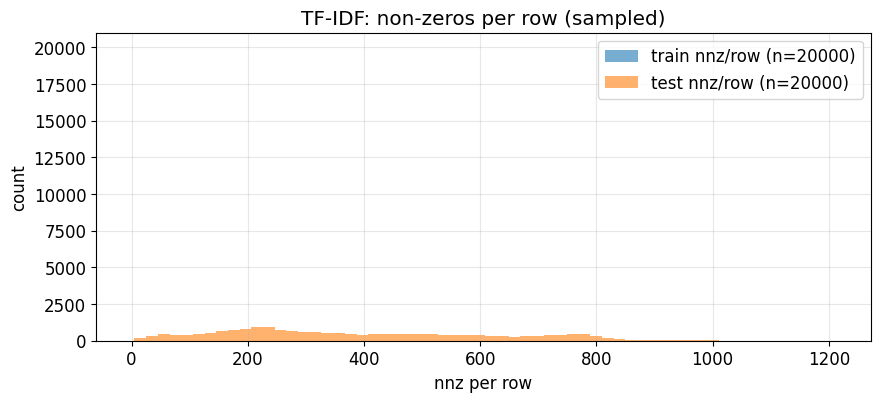

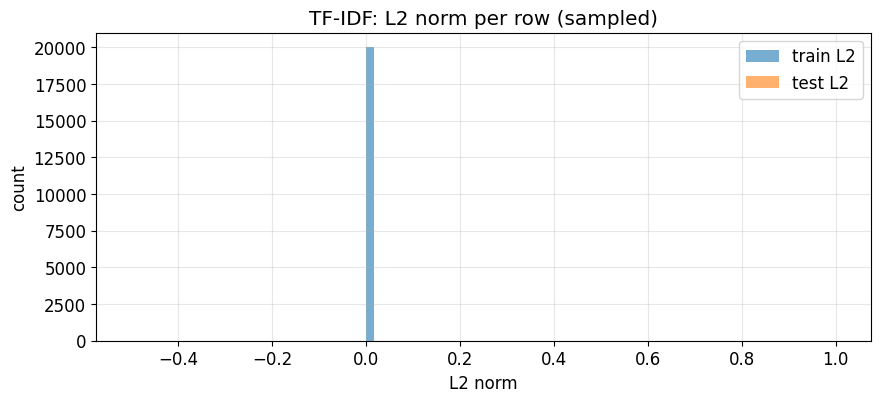

In [12]:
# CELL 08 - Run: TF-IDF embeddings (10279D)
# PRODUCES: features/text_vectorizer.joblib, features/train_embeds_text.npy, features/test_embeds_text.npy
# Milestone checkpoint: stage_03_tfidf_text
# Option B strictness: TF-IDF is required, but we allow building it in-place when missing.
import sys
from pathlib import Path

STRICT_OPTION_B = True
USE_TFIDF_TEXT = True
feat_dir = WORK_ROOT / 'features'
text_vect = feat_dir / 'text_vectorizer.joblib'
train_text_npy = feat_dir / 'train_embeds_text.npy'
test_text_npy = feat_dir / 'test_embeds_text.npy'
generated = False
if USE_TFIDF_TEXT:
    have_all = text_vect.exists() and train_text_npy.exists() and test_text_npy.exists()
    if have_all:
        print('TF-IDF artefacts already exist; skipping generation')
    else:
        text_path = WORK_ROOT / 'external' / 'entryid_text.tsv'
        if not text_path.exists():
            raise FileNotFoundError(f'Missing corpus file: {text_path}. Run the corpus milestone first.')
        sys.argv = [
            '02_generate_optional_embeddings.py',
            '--artefacts-dir', str(WORK_ROOT),
            '--mode', 'text',
            '--text-path', str(text_path),
            '--text-dim', '10279',
        ]
        _ = main()
        generated = True
if text_vect.exists() and train_text_npy.exists() and test_text_npy.exists():
    if generated:
        print('TF-IDF generated; attempting checkpoint push (may be skipped if unchanged).')
    else:
        print('TF-IDF present; attempting checkpoint push (may be skipped if unchanged).')
    STORE.maybe_push('stage_03_tfidf_text', [text_vect, train_text_npy, test_text_npy], note='tf-idf 10279D')
    # Diagnostics: TF-IDF sparsity + row norms (sampled)
    try:
        import numpy as np
        import matplotlib.pyplot as plt
        plt.rcParams.update({'font.size': 12})
        def _sample_rows(x: np.ndarray, n: int = 20000) -> np.ndarray:
            m = min(int(x.shape[0]), int(n))
            if m <= 0:
                return np.zeros((0, int(x.shape[1])), dtype=np.float32)
            idx = np.linspace(0, int(x.shape[0]) - 1, num=m, dtype=np.int64)
            return np.asarray(x[idx], dtype=np.float32)
        x_tr = np.load(train_text_npy, mmap_mode='r')
        x_te = np.load(test_text_npy, mmap_mode='r')
        tr = _sample_rows(x_tr)
        te = _sample_rows(x_te)
        tr_nnz = (tr > 0).sum(axis=1)
        te_nnz = (te > 0).sum(axis=1)
        plt.figure(figsize=(10, 4))
        plt.hist(tr_nnz, bins=60, alpha=0.6, label=f'train nnz/row (n={len(tr_nnz)})')
        plt.hist(te_nnz, bins=60, alpha=0.6, label=f'test nnz/row (n={len(te_nnz)})')
        plt.title('TF-IDF: non-zeros per row (sampled)')
        plt.xlabel('nnz per row')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        tr_norm = np.linalg.norm(tr, axis=1)
        te_norm = np.linalg.norm(te, axis=1)
        plt.figure(figsize=(10, 4))
        plt.hist(tr_norm, bins=60, alpha=0.6, label='train L2')
        plt.hist(te_norm, bins=60, alpha=0.6, label='test L2')
        plt.title('TF-IDF: L2 norm per row (sampled)')
        plt.xlabel('L2 norm')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    except Exception as e:
        print('TF-IDF diagnostics skipped:', repr(e))
elif STRICT_OPTION_B:
    missing = [p for p in [text_vect, train_text_npy, test_text_npy] if not p.exists()]
    raise FileNotFoundError('Option B requires TF-IDF artefacts, but these are missing:\n' + '\n'.join([f' - {m}' for m in missing]))

In [13]:
# Cell 8b: Data Provisioning - Download and Process External GOA Data
# This cell ensures the raw GAF data is available and processed into the format required by Cell 9.

import requests
import subprocess
import sys
import os
from pathlib import Path

# Configuration
GAF_URL = "http://ftp.ebi.ac.uk/pub/databases/GO/goa/UNIPROT/goa_uniprot_all.gaf.gz"
EXTERNAL_DIR = WORK_ROOT / "artefacts_local" / "artefacts" / "external"
GAF_PATH = EXTERNAL_DIR / "goa_uniprot_all.gaf.gz"
FILTERED_PATH = EXTERNAL_DIR / "goa_filtered_iea.tsv.gz"

EXTERNAL_DIR.mkdir(parents=True, exist_ok=True)

# 1. Download GAF if missing
if not GAF_PATH.exists():
    print(f"Downloading {GAF_URL} to {GAF_PATH}...")
    # Stream download to avoid memory issues
    with requests.get(GAF_URL, stream=True) as r:
        r.raise_for_status()
        with open(GAF_PATH, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download complete.")
else:
    print(f"Found existing GAF file: {GAF_PATH}")

# 2. Run the processing script
# We use the script we verified earlier: scripts/01_build_goa_features.py
# WORK_ROOT is typically cafa6_data/, so scripts are in the parent directory
script_path = WORK_ROOT.parent / "scripts" / "01_build_goa_features.py"
if not script_path.exists():
    # Fallback: try relative to current working directory if WORK_ROOT is unexpected
    script_path = Path("scripts/01_build_goa_features.py").resolve()
    if not script_path.exists():
         # Fallback 2: try relative to notebook location
        script_path = Path("../scripts/01_build_goa_features.py").resolve()

if not FILTERED_PATH.exists():
    print(f"Processing GAF to {FILTERED_PATH}...")
    print(f"Using script: {script_path}")

    cmd = [
        sys.executable,
        str(script_path),
        "--gaf-gz", str(GAF_PATH),
        "--train-fasta", str(PATH_TRAIN_FASTA),
        "--test-fasta", str(PATH_TEST_FASTA),
        "--out", str(FILTERED_PATH),
        "--only-iea"
    ]

    print(f"Running: {' '.join(cmd)}")
    result = subprocess.run(cmd, capture_output=True, text=True)

    if result.returncode != 0:
        print("Error running script:")
        print(result.stderr)
        raise RuntimeError("Failed to process GOA features")
    else:
        print("Processing complete.")
        print(result.stdout)
else:
    print(f"Found existing filtered file: {FILTERED_PATH}")

# 3. Checkpoint the filtered artefact (CUMULATIVE)
# We upload this so we don't have to re-download the huge GAF next time.
# IMPORTANT: We must include ALL previous artefacts to avoid wiping the dataset.
if 'STORE' in globals() and FILTERED_PATH.exists():
    print(f"Uploading {FILTERED_PATH.name} to checkpoint (cumulative)...")

    # FORCE ENABLE PUSH for this operation
    if not STORE.push_enabled:
        print("Enabling checkpoint push (override)...")
        STORE.push_enabled = True

    print(f"Target Dataset: {STORE.dataset_id}")

    # Construct cumulative list: Stage 3 (TF-IDF) + this new file
    # Note: STAGE_REQUIRED_FILES is defined in Cell 5
    base_files = STAGE_REQUIRED_FILES.get('stage_03_tfidf_text', [])

    # Convert FILTERED_PATH to relative path string for consistency
    try:
        rel_filtered = str(FILTERED_PATH.relative_to(WORK_ROOT)).replace('\\', '/')
    except ValueError:
        # Fallback if path logic is weird
        rel_filtered = "artefacts_local/artefacts/external/goa_filtered_iea.tsv.gz"

    cumulative_files = base_files + [rel_filtered]

    # Resolve full paths for the push method
    cumulative_paths = [WORK_ROOT / f for f in cumulative_files]

    try:
        STORE.maybe_push(
            "stage_03b_external_goa_filtered",
            cumulative_paths,
            note="Filtered GOA IEA terms (cumulative update)"
        )
    except Exception as e:
        print(f"Warning: Failed to push checkpoint: {e}")

# 4. Enable PROCESS_EXTERNAL for the next cells
# We set the environment variable or global variable so the next cell picks it up
os.environ["CAFA_PROCESS_EXTERNAL"] = "1"
# Also update the global variable if it exists in the notebook namespace (it will be re-read by Cell 9)
print("Enabled PROCESS_EXTERNAL for subsequent cells.")

Download complete.
Processing GAF to /content/cafa6_data/artefacts_local/artefacts/external/goa_filtered_iea.tsv.gz...
Using script: /scripts/01_build_goa_features.py
Running: /usr/bin/python3 /scripts/01_build_goa_features.py --gaf-gz /content/cafa6_data/artefacts_local/artefacts/external/goa_uniprot_all.gaf.gz --train-fasta /content/cafa6_data/Train/train_sequences.fasta --test-fasta /content/cafa6_data/Test/testsuperset.fasta --out /content/cafa6_data/artefacts_local/artefacts/external/goa_filtered_iea.tsv.gz --only-iea
Error running script:
/usr/bin/python3: can't open file '/scripts/01_build_goa_features.py': [Errno 2] No such file or directory



RuntimeError: Failed to process GOA features

In [ ]:
# EMERGENCY RESTORE CELL: Upload ALL Local Files
# This cell ignores notebook variables and scans the disk directly to ensure
# EVERYTHING in your local folder is uploaded, restoring the dataset.

import os
import shutil
import subprocess
from pathlib import Path
import json

# 1. Configuration
# Files to explicitly EXCLUDE from the restore
EXCLUDE_FILES = set() # User requested to keep everything

# Directories to scan recursively
DIRS_TO_SCAN = ['parsed', 'features', 'external']

def _ckpt_fname(rel: str) -> str:
    # Flatten path: parsed/train_seq.feather -> parsed__train_seq.feather
    rel = str(rel).replace('\\', '/').lstrip('/')
    return rel.replace('/', '__')

# 2. Scan Local Disk
print(f"Scanning local artefacts in {WORK_ROOT}...")
files_to_upload = []

# Always include manifest if it exists
if (WORK_ROOT / 'manifest.json').exists():
    files_to_upload.append('manifest.json')

for dir_name in DIRS_TO_SCAN:
    dir_path = WORK_ROOT / dir_name
    if not dir_path.exists():
        print(f"Warning: Directory not found: {dir_path}")
        continue

    for root, _, files in os.walk(dir_path):
        for file in files:
            abs_path = Path(root) / file
            rel_path = abs_path.relative_to(WORK_ROOT).as_posix()

            if rel_path in EXCLUDE_FILES:
                print(f"Skipping excluded file: {rel_path}")
                continue

            files_to_upload.append(rel_path)

print(f"Found {len(files_to_upload)} files to restore.")

# 3. Stage Files (Hard Links + Flattening)
RESTORE_ROOT = WORK_ROOT / '_publish_restore'
if RESTORE_ROOT.exists():
    shutil.rmtree(RESTORE_ROOT)
RESTORE_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Staging files to {RESTORE_ROOT} (flattened)...")
count = 0
for rel_path in files_to_upload:
    src = WORK_ROOT / rel_path

    # Flatten filename for Kaggle Dataset compatibility
    flat_name = _ckpt_fname(rel_path)
    dst = RESTORE_ROOT / flat_name

    try:
        if dst.exists():
            dst.unlink()
        os.link(src, dst)
        count += 1
    except OSError:
        shutil.copy2(src, dst)
        count += 1

# 4. Create Metadata
meta_path = RESTORE_ROOT / 'dataset-metadata.json'
with open(meta_path, 'w') as f:
    json.dump({
        'title': CHECKPOINT_DATASET_TITLE,
        'id': CHECKPOINT_DATASET_ID,
        'licenses': [{'name': 'CC0-1.0'}]
    }, f, indent=2)

# 5. Push
print(f"Pushing {count} files to Kaggle (Emergency Restore)...")
cmd = ['kaggle', 'datasets', 'version', '-p', str(RESTORE_ROOT), '-m', 'EMERGENCY RESTORE: Uploading all local artefacts (flattened)']
env = os.environ.copy()
if 'KAGGLE_USERNAME' in globals():
    env['KAGGLE_USERNAME'] = KAGGLE_USERNAME
    env['KAGGLE_KEY'] = KAGGLE_KEY

proc = subprocess.run(cmd, capture_output=True, text=True, env=env)

if proc.returncode == 0:
    print("SUCCESS: Dataset restoration started.")
    print(proc.stdout)
else:
    print("FAILURE: Could not restore dataset.")
    print(proc.stderr)


In [ ]:
# CELL 09 - Solution: 2.1 PHASE 1 (Step 3): EXTERNAL DATA & EVIDENCE CODES (ARTEFACT-FIRST)
# 2.1 PHASE 1 (Step 3): EXTERNAL DATA & EVIDENCE CODES (ARTEFACT-FIRST)
# ================================================================
# Option B strictness: external GOA artefacts are REQUIRED on Kaggle/Colab.
# Local runs default to best-effort (skip if missing) unless you opt-in.
from pathlib import Path
import os


def _detect_kaggle() -> bool:
    return bool(
        os.environ.get("KAGGLE_KERNEL_RUN_TYPE")
        or os.environ.get("KAGGLE_URL_BASE")
        or os.environ.get("KAGGLE_DATA_PROXY_URL")
    )


def _detect_colab() -> bool:
    return bool(
        os.environ.get("COLAB_RELEASE_TAG")
        or os.environ.get("COLAB_GPU")
        or os.environ.get("COLAB_TPU_ADDR")
    )


IS_KAGGLE = _detect_kaggle()
IS_COLAB = (not IS_KAGGLE) and _detect_colab()
IS_LOCAL = (not IS_KAGGLE) and (not IS_COLAB)

# Defaults:
# - Kaggle/Colab: strict + enabled
# - Local: non-strict + disabled (opt-in)
STRICT_OPTION_B = bool(int(os.getenv("CAFA_STRICT_OPTION_B", "0" if IS_LOCAL else "1")))
PROCESS_EXTERNAL = bool(int(os.getenv("CAFA_PROCESS_EXTERNAL", "0" if IS_LOCAL else "1")))

# Recommended (Kaggle): set CAFA_GOA_DATASET_DIR to your dataset folder,
# e.g. /kaggle/input/goa-filtered-all-tsv-gz
GOA_ENV_DIR = os.getenv("CAFA_GOA_DATASET_DIR", "").strip()
GOA_ARTEFACT_DIRS = [
    Path(GOA_ENV_DIR) if GOA_ENV_DIR else None,
    # Path('/kaggle/input/<dataset-folder>'),
]

if PROCESS_EXTERNAL:
    EXT_DIR = WORK_ROOT / "external"
    EXT_DIR.mkdir(exist_ok=True)

    def _existing(dirs: list[Path]) -> list[Path]:
        return [
            Path(d)
            for d in dirs
            if d is not None and str(d).strip() and Path(d).exists()
        ]

    def _discover(dirs: list[Path]) -> list[Path]:
        patterns = ("**/goa_filtered_*.tsv.gz", "**/goa_filtered_*.tsv")
        found: list[Path] = []
        for d in dirs:
            found += [
                d / "goa_filtered_all.tsv.gz",
                d / "goa_filtered_iea.tsv.gz",
                d / "goa_filtered_all.tsv",
                d / "goa_filtered_iea.tsv",
            ]
            for pat in patterns:
                found += sorted(Path(d).glob(pat))
        out: list[Path] = []
        seen = set()
        for p in found:
            p = Path(p)
            if p in seen:
                continue
            seen.add(p)
            if p.exists() and p.is_file():
                out.append(p)
        return out

    def _pick_best(paths: list[Path]) -> Path:
        def score(p: Path) -> tuple[int, int]:
            name = p.name.lower()
            ext_rank = 0 if name.endswith(".tsv.gz") else 1
            if "goa_filtered_all" in name:
                return (0, ext_rank)
            if "goa_filtered_iea" in name:
                return (1, ext_rank)
            if "all" in name:
                return (2, ext_rank)
            if "iea" in name:
                return (3, ext_rank)
            return (4, ext_rank)

        return sorted(paths, key=score)[0]

    roots = _existing(GOA_ARTEFACT_DIRS)
    if not roots and Path("/kaggle/input").exists():
        # fallback discovery, but still strict if nothing found
        roots = [Path("/kaggle/input")]
    elif not roots:
        roots = [EXT_DIR, Path("artefacts_local/artefacts/external")]

    goa_paths = _discover(roots)
    if not goa_paths:
        msg = (
            "External GOA artefacts not found.\n"
            "Fix:\n"
            " - Publish goa_filtered_all.tsv.gz (and/or goa_filtered_iea.tsv.gz) as a Kaggle Dataset\n"
            " - Attach it to this notebook\n"
            " - Set env var CAFA_GOA_DATASET_DIR=/kaggle/input/<dataset-folder> (recommended)\n"
            " - Or place the file under artefacts/external locally\n"
            "\n"
            f"Mode: STRICT_OPTION_B={STRICT_OPTION_B} PROCESS_EXTERNAL={PROCESS_EXTERNAL}"
        )
        if STRICT_OPTION_B:
            raise FileNotFoundError(msg)
        print(msg)
        PROCESS_EXTERNAL = False
    else:
        GOA_FEATURE_PATH = _pick_best(goa_paths)
        print("Using GOA artefact:", GOA_FEATURE_PATH)
        print("Format expected: EntryID<TAB>term<TAB>evidence (header included)")
else:
    print("Skipping external GOA features (PROCESS_EXTERNAL=0).")


In [ ]:
# CELL 10 - Solution: 2.2 PHASE 1 (Step 4): HIERARCHY PROPAGATION FOR EXTERNAL GOA (NO-KAGGLE / IEA)
# PRODUCES (when PROCESS_EXTERNAL=True): external/prop_train_no_kaggle.tsv, external/prop_test_no_kaggle.tsv
# Milestone checkpoint: stage_04_external_goa_priors
# Produces (when enabled):
# - external/prop_train_no_kaggle.tsv.gz
# - external/prop_test_no_kaggle.tsv.gz
# Option B strictness: this step MUST be satisfied when PROCESS_EXTERNAL=True.
import gzip
import pandas as pd
from pathlib import Path

EXTERNAL_PRIOR_SCORE = 1.0  # binary prior (later we down-weight when injecting into models)

if not PROCESS_EXTERNAL:
    print("Skipping external GOA hierarchy propagation (PROCESS_EXTERNAL=0).")
else:
    if "GOA_FEATURE_PATH" not in locals():
        raise RuntimeError(
            "PROCESS_EXTERNAL=True but GOA_FEATURE_PATH is missing. Run the external GOA discovery cell first."
        )

    # Ensure we have GO parents (hierarchy)
    if "go_parents" not in locals():
        def parse_obo(path: Path):
            parents = {}
            namespaces = {}
            cur_id, cur_ns = None, None
            with path.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if line == "[Term]":
                        if cur_id and cur_ns:
                            namespaces[cur_id] = cur_ns
                        cur_id, cur_ns = None, None
                    elif line.startswith("id: GO:"):
                        cur_id = line.split("id: ", 1)[1]
                    elif line.startswith("namespace:"):
                        cur_ns = line.split("namespace: ", 1)[1]
                    elif line.startswith("is_a:") and cur_id:
                        parent = line.split("is_a: ", 1)[1].split(" ! ")[0]
                        parents.setdefault(cur_id, set()).add(parent)
                if cur_id and cur_ns:
                    namespaces[cur_id] = cur_ns
            return parents, namespaces

        go_parents, go_namespaces = parse_obo(PATH_GO_OBO)

    # Ensure train/test IDs are available
    train_seq_path = WORK_ROOT / "parsed" / "train_seq.feather"
    test_seq_path = WORK_ROOT / "parsed" / "test_seq.feather"
    if not train_seq_path.exists():
        raise FileNotFoundError(
            "Missing train_seq.feather. Run Phase 1 Step 2 (FASTA parse) first."
        )
    if not test_seq_path.exists():
        raise FileNotFoundError(
            "Missing test_seq.feather. Run Phase 1 Step 2 (FASTA parse) first."
        )

    # IMPORTANT: GOA artefacts usually use UniProt accessions, but FASTA IDs may be like sp|P12345|NAME.
    # Normalise for matching, but write the original IDs so downstream joins (reindex on train_ids/test_ids) still work.
    def _norm_entry_id(raw: str) -> str:
        s = str(raw).strip()
        parts = s.split("|")
        if len(parts) >= 2 and parts[0] in {"sp", "tr"}:
            return parts[1]
        if len(parts) >= 3:
            return parts[1]
        return s

    train_ids_raw = pd.read_feather(train_seq_path)["id"].astype(str).tolist()
    test_ids_raw = pd.read_feather(test_seq_path)["id"].astype(str).tolist()
    train_id_map = {_norm_entry_id(i): i for i in train_ids_raw}
    test_id_map = {_norm_entry_id(i): i for i in test_ids_raw}
    train_ids = set(train_id_map.keys())
    test_ids = set(test_id_map.keys())

    # Get top-K train terms (defines the external feature space)
    # Champion Strategy: 13,500 terms (10k BP, 2k MF, 1.5k CC)
    train_terms_path = WORK_ROOT / "parsed" / "train_terms.parquet"
    if not train_terms_path.exists():
        raise FileNotFoundError(
            "Missing train_terms.parquet. Run Phase 1 Step 2 (targets parse) first."
        )
    train_terms = pd.read_parquet(train_terms_path)

    # Map terms to namespaces
    term_counts = train_terms["term"].value_counts()
    # Ensure all terms have a namespace (fallback to unknown if missing in OBO)
    term_ns = term_counts.index.map(lambda t: go_namespaces.get(t, "unknown"))

    # Select top K per aspect
    top_bp = term_counts[term_ns == "biological_process"].head(10000).index.tolist()
    top_mf = term_counts[term_ns == "molecular_function"].head(2000).index.tolist()
    top_cc = term_counts[term_ns == "cellular_component"].head(1500).index.tolist()

    top_terms = list(set(top_bp + top_mf + top_cc))
    top_terms_set = set(top_terms)
    print(f"External propagation restricted to top {len(top_terms)} train terms (BP={len(top_bp)}, MF={len(top_mf)}, CC={len(top_cc)}).")

    EXT_DIR = WORK_ROOT / "external"
    EXT_DIR.mkdir(exist_ok=True)
    out_train = EXT_DIR / "prop_train_no_kaggle.tsv.gz"
    out_test = EXT_DIR / "prop_test_no_kaggle.tsv.gz"

    if out_train.exists() and out_test.exists():
        print("Propagated GOA priors already present; skipping propagation.")
    else:
        # Ancestor closure with memoisation
        _anc_cache: dict[str, set[str]] = {}

        def ancestors(term: str) -> set[str]:
            if term in _anc_cache:
                return _anc_cache[term]
            seen = {term}
            stack = [term]
            while stack:
                t = stack.pop()
                for p in go_parents.get(t, ()):
                    if p not in seen:
                        seen.add(p)
                        stack.append(p)
            _anc_cache[term] = seen
            return seen

        cols = ["EntryID", "term", "evidence"]
        print("Streaming GOA artefact:", GOA_FEATURE_PATH)
        print("Writing:", out_train)
        print("Writing:", out_test)
        n_train = 0
        n_test = 0
        with gzip.open(out_train, "wt", encoding="utf-8") as ftr, gzip.open(
            out_test, "wt", encoding="utf-8"
        ) as fte:
            ftr.write("EntryID\tterm\tscore\n")
            fte.write("EntryID\tterm\tscore\n")
            for chunk in pd.read_csv(
                GOA_FEATURE_PATH,
                sep="\t",
                dtype=str,
                usecols=lambda c: c in cols,
                chunksize=500_000,
            ):
                missing_cols = [c for c in cols if c not in chunk.columns]
                if missing_cols:
                    raise ValueError(
                        f"GOA artefact missing columns: {missing_cols}. Found: {list(chunk.columns)}"
                    )
                chunk = chunk[cols].dropna()
                chunk = chunk[chunk["evidence"] == "IEA"]
                if chunk.empty:
                    continue
                chunk = chunk.drop_duplicates(subset=["EntryID", "term"])
                for entry_id_raw, term in zip(
                    chunk["EntryID"].tolist(), chunk["term"].tolist()
                ):
                    entry_norm = _norm_entry_id(entry_id_raw)
                    if entry_norm in train_ids:
                        target = ftr
                        out_entry = train_id_map[entry_norm]
                    elif entry_norm in test_ids:
                        target = fte
                        out_entry = test_id_map[entry_norm]
                    else:
                        continue
                    keep = ancestors(term) & top_terms_set
                    if not keep:
                        continue
                    for t in keep:
                        target.write(f"{out_entry}\t{t}\t{EXTERNAL_PRIOR_SCORE}\n")
                    if target is ftr:
                        n_train += len(keep)
                    else:
                        n_test += len(keep)
        print(f"Wrote propagated IEA edges: train={n_train:,} test={n_test:,}")
        print(
            "Outputs are intentionally sparse priors (score=1.0) and will be down-weighted when injected."
        )

    if out_train.exists() and out_test.exists():
        STORE.maybe_push(
            "stage_04_external_goa_priors",
            [out_train, out_test],
            note="propagated IEA priors",
        )

In [ ]:
# CELL 10b - Diagnostics: artefact manifest (existence + sizes)
%matplotlib inline
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 12})

def _mb(p: Path) -> float:
    return p.stat().st_size / (1024**2)
WORK_ROOT = Path(WORK_ROOT)
# Minimal contract: Phase 1 outputs + Option B required artefacts + later model outputs
paths = {
    # Phase 1 parsed
    'parsed/train_seq.feather': WORK_ROOT / 'parsed' / 'train_seq.feather',
    'parsed/test_seq.feather': WORK_ROOT / 'parsed' / 'test_seq.feather',
    'parsed/train_terms.parquet': WORK_ROOT / 'parsed' / 'train_terms.parquet',
    'parsed/term_priors.parquet': WORK_ROOT / 'parsed' / 'term_priors.parquet',
    'parsed/train_taxa.feather': WORK_ROOT / 'parsed' / 'train_taxa.feather',
    'parsed/test_taxa.feather': WORK_ROOT / 'parsed' / 'test_taxa.feather',
    # Text pipeline
    'external/entryid_text.tsv': WORK_ROOT / 'external' / 'entryid_text.tsv',
    'features/text_vectorizer.joblib': WORK_ROOT / 'features' / 'text_vectorizer.joblib',
    'features/train_embeds_text.npy': WORK_ROOT / 'features' / 'train_embeds_text.npy',
    'features/test_embeds_text.npy': WORK_ROOT / 'features' / 'test_embeds_text.npy',
    # Sequence embeddings (core)
    'features/train_embeds_t5.npy': WORK_ROOT / 'features' / 'train_embeds_t5.npy',
    'features/test_embeds_t5.npy': WORK_ROOT / 'features' / 'test_embeds_t5.npy',
    'features/train_embeds_esm2.npy': WORK_ROOT / 'features' / 'train_embeds_esm2.npy',
    'features/test_embeds_esm2.npy': WORK_ROOT / 'features' / 'test_embeds_esm2.npy',
    'features/train_embeds_esm2_3b.npy': WORK_ROOT / 'features' / 'train_embeds_esm2_3b.npy',
    'features/test_embeds_esm2_3b.npy': WORK_ROOT / 'features' / 'test_embeds_esm2_3b.npy',
    'features/train_embeds_ankh.npy': WORK_ROOT / 'features' / 'train_embeds_ankh.npy',
    'features/test_embeds_ankh.npy': WORK_ROOT / 'features' / 'test_embeds_ankh.npy',
    # External priors
    'external/prop_train_no_kaggle.tsv.gz': WORK_ROOT / 'external' / 'prop_train_no_kaggle.tsv.gz',
    'external/prop_test_no_kaggle.tsv.gz': WORK_ROOT / 'external' / 'prop_test_no_kaggle.tsv.gz',
    # Downstream expectations
    'features/top_terms_13500.json': WORK_ROOT / 'features' / 'top_terms_13500.json',
    'features/oof_pred_logreg.npy': WORK_ROOT / 'features' / 'oof_pred_logreg.npy',
    'features/oof_pred_gbdt.npy': WORK_ROOT / 'features' / 'oof_pred_gbdt.npy',
    'features/oof_pred_dnn.npy': WORK_ROOT / 'features' / 'oof_pred_dnn.npy',
    'features/test_pred_logreg.npy': WORK_ROOT / 'features' / 'test_pred_logreg.npy',
    'features/test_pred_gbdt.npy': WORK_ROOT / 'features' / 'test_pred_gbdt.npy',
    'features/test_pred_dnn.npy': WORK_ROOT / 'features' / 'test_pred_dnn.npy',
    'features/test_pred_gcn.npy': WORK_ROOT / 'features' / 'test_pred_gcn.npy',
}
rows = []
for name, p in paths.items():
    rows.append({'artefact': name, 'exists': p.exists(), 'mb': _mb(p) if p.exists() else 0.0, 'path': str(p)})
df = pd.DataFrame(rows).sort_values(['exists', 'mb'], ascending=[True, False])
print('WORK_ROOT:', WORK_ROOT)
try:
    from IPython.display import display  # type: ignore
except Exception:
    def display(x):
        print(x)
display(df)
display(df)
# Visual: top 25 largest artefacts
df2 = df[df['exists']].sort_values('mb', ascending=False).head(25)
if len(df2) > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df2, y='artefact', x='mb')
    plt.title('Largest artefacts (MB)')
    plt.xlabel('MB')
    plt.ylabel('artefact')
    plt.tight_layout()
    plt.show()
# Option B strict check (what must exist before the stacker)
option_b_required = [
    'external/prop_train_no_kaggle.tsv.gz',
    'external/prop_test_no_kaggle.tsv.gz',
    'features/text_vectorizer.joblib',
    'features/train_embeds_text.npy',
    'features/test_embeds_text.npy',
    'features/train_embeds_t5.npy',
    'features/test_embeds_t5.npy',
    'features/train_embeds_esm2.npy',
    'features/test_embeds_esm2.npy',
    'features/train_embeds_esm2_3b.npy',
    'features/test_embeds_esm2_3b.npy',
    'features/train_embeds_ankh.npy',
    'features/test_embeds_ankh.npy',
    'parsed/train_taxa.feather',
    'parsed/test_taxa.feather',
    'features/top_terms_13500.json',
]
missing = [a for a in option_b_required if not paths[a].exists()]
if missing:
    print('\nOption B missing artefacts:')
    for m in missing:
        print(' -', m)
else:
    print('\nOption B artefacts OK: priors + embeddings + TF-IDF + taxonomy + top terms present.')

In [ ]:
# CELL 11 - Solution: 3a. PHASE 1: EMBEDDINGS GENERATION (T5 only)
# PRODUCES: features/train_embeds_t5.npy, features/test_embeds_t5.npy
# 3a. PHASE 1: EMBEDDINGS GENERATION (T5 only)
# ============================================
# HARDWARE: GPU recommended
# ============================================
# Split from ESM2 so you can run each independently on Kaggle.
import os

# IMPORTANT: pushing checkpoints republishes a whole Kaggle Dataset version (but only the staged flat files we include),
# which can mean re-uploading multi-GB zips even when embeddings already exist.
t5_train_path = WORK_ROOT / 'features' / 'train_embeds_t5.npy'
t5_test_path = WORK_ROOT / 'features' / 'test_embeds_t5.npy'
has_test = (WORK_ROOT / 'parsed' / 'test_seq.feather').exists()
train_ready = t5_train_path.exists()
test_ready = (not has_test) or t5_test_path.exists()
COMPUTE_T5 = True  # <--- enable/disable T5 run
FORCE_REBUILD = False  # manual toggle; keep default strict
train_needed = COMPUTE_T5 and (FORCE_REBUILD or (not train_ready))
train_needed = COMPUTE_T5 and (FORCE_REBUILD or (not train_ready))
test_needed = COMPUTE_T5 and has_test and (FORCE_REBUILD or (not t5_test_path.exists()))
# If artefacts already exist, skip compute unless forced.
if COMPUTE_T5 and (not train_needed) and (not test_needed):
    COMPUTE_T5 = False
    if not PUSH_EXISTING_CHECKPOINTS:
        print('T5 embeddings already exist; skipping compute and not pushing checkpoints (PUSH_EXISTING_CHECKPOINTS=False).')
    if PUSH_EXISTING_CHECKPOINTS and 'STORE' in globals() and STORE is not None:
        # Granular checkpoints: allow resuming test without losing train.
        try:
            STORE.maybe_push('stage_05a_embeddings_t5_train', [t5_train_path], note='ProtT5 mean-pool embeddings (train only, existing)')
        except Exception as e:
            print(f'WARN: failed to push stage_05a_embeddings_t5_train: {e}')
        if t5_test_path.exists():
            try:
                STORE.maybe_push('stage_05b_embeddings_t5_test', [t5_test_path], note='ProtT5 mean-pool embeddings (test only, existing)')
            except Exception as e:
                print(f'WARN: failed to push stage_05b_embeddings_t5_test: {e}')
        # Backwards-compatible combined stage.
        paths = [t5_train_path]
        if t5_test_path.exists():
            paths.append(t5_test_path)
        try:
            STORE.maybe_push('stage_05_embeddings_t5', paths, note='ProtT5 mean-pool embeddings (existing)')
        except Exception as e:
            print(f'WARN: failed to push stage_05_embeddings_t5: {e}')
if COMPUTE_T5:
    import gc
    import numpy as np
    import pandas as pd
    import torch
    from transformers import T5Tokenizer, T5EncoderModel
    from tqdm.auto import tqdm
    import contextlib
    # Optimise CUDA memory allocation
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    # Fix Protobuf 'GetPrototype' error
    os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    amp_ctx = torch.amp.autocast('cuda') if device.type == 'cuda' else contextlib.nullcontext()
    def get_t5_model():
        print("Loading T5 Model...")
        tokenizer = T5Tokenizer.from_pretrained(
            "Rostlab/prot_t5_xl_half_uniref50-enc", do_lower_case=False, legacy=True
        )
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)
        model.eval()
        return tokenizer, model
    def generate_embeddings_t5(model, tokenizer, sequences, batch_size=4, max_len=1024):
        seq_lens = [len(s) for s in sequences]
        sort_idx = np.argsort(seq_lens)[::-1]
        sorted_seqs = [sequences[i] for i in sort_idx]
        embeddings_list = []
        for i in tqdm(range(0, len(sorted_seqs), batch_size), desc="Embedding T5 (Smart Batch)"):
            batch_seqs = sorted_seqs[i : i + batch_size]
            batch_seqs = [seq.replace('U', 'X').replace('Z', 'X').replace('O', 'X').replace('B', 'X') for seq in batch_seqs]
            batch_seqs = [" ".join(list(seq)) for seq in batch_seqs]
            ids = tokenizer.batch_encode_plus(
                batch_seqs,
                add_special_tokens=True,
                padding="longest",
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            ).to(device)
            with torch.no_grad():
                with amp_ctx:
                    embedding_repr = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask'])
            emb = embedding_repr.last_hidden_state.float().detach().cpu().numpy()
            mask = ids['attention_mask'].detach().cpu().numpy()
            for j in range(len(batch_seqs)):
                seq_len = int(mask[j].sum())
                valid_emb = emb[j, :seq_len]
                embeddings_list.append(valid_emb.mean(axis=0))
            del ids, embedding_repr, emb, mask
            if device.type == 'cuda':
                torch.cuda.empty_cache()
        sorted_embeddings = np.vstack(embeddings_list)
        original_order_embeddings = np.zeros_like(sorted_embeddings)
        original_order_embeddings[sort_idx] = sorted_embeddings
        return original_order_embeddings
    tokenizer, model = get_t5_model()
    if train_needed:
        print("Loading train sequences for T5 embedding...")
        train_df = pd.read_feather(WORK_ROOT / 'parsed' / 'train_seq.feather')
        print(f"Generating Train Embeddings T5 ({len(train_df)})...")
        train_emb = generate_embeddings_t5(model, tokenizer, train_df['sequence'].tolist())
        np.save(t5_train_path, train_emb)
        # Push immediately after train completes so a crash during test doesn't lose progress.
        if 'STORE' in globals() and STORE is not None:
            try:
                STORE.maybe_push('stage_05a_embeddings_t5_train', [t5_train_path], note='ProtT5 mean-pool embeddings (train only)')
            except Exception as e:
                print(f'WARN: failed to push stage_05a_embeddings_t5_train: {e}')
        del train_emb, train_df
        gc.collect()
    else:
        print(f"Train embeddings already exist at {t5_train_path}; skipping train compute.")
    if test_needed:
        print("Loading test sequences for T5 embedding...")
        test_df = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')
        print(f"Generating Test Embeddings T5 ({len(test_df)})...")
        test_emb = generate_embeddings_t5(model, tokenizer, test_df['sequence'].tolist())
        np.save(t5_test_path, test_emb)
        # Push immediately after test completes as well.
        if 'STORE' in globals() and STORE is not None:
            try:
                STORE.maybe_push('stage_05b_embeddings_t5_test', [t5_test_path], note='ProtT5 mean-pool embeddings (test only)')
            except Exception as e:
                print(f'WARN: failed to push stage_05b_embeddings_t5_test: {e}')
        del test_emb, test_df
        gc.collect()
    else:
        if has_test:
            print(f"Test embeddings already exist at {t5_test_path}; skipping test compute.")
        else:
            print("No test sequences found; skipping test embedding.")
    del model, tokenizer
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("T5 embeddings ready.")
    # Backwards-compatible combined stage.
    if 'STORE' in globals() and STORE is not None:
        paths = [t5_train_path]
        if t5_test_path.exists():
            paths.append(t5_test_path)
        try:
            STORE.maybe_push('stage_05_embeddings_t5', paths, note='ProtT5 mean-pool embeddings')
        except Exception as e:
            print(f'WARN: failed to push stage_05_embeddings_t5: {e}')
else:
    print("Skipping T5 embedding generation (COMPUTE_T5=False).")
# Diagnostics: embedding norms (train vs test; sampled)
try:
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path
    plt.rcParams.update({'font.size': 12})
    def _plot_embed_norms(name: str, train_path: Path, test_path: Path):
        if not Path(train_path).exists():
            print(f'[{name}] missing train embeddings: {train_path}')
            return
        x_tr = np.load(train_path, mmap_mode='r')
        x_te = np.load(test_path, mmap_mode='r') if Path(test_path).exists() else None
        def _sample_norms(x: np.ndarray, n: int = 20000) -> np.ndarray:
            m = min(int(x.shape[0]), int(n))
            if m <= 0:
                return np.zeros((0,), dtype=np.float32)
            idx = np.linspace(0, int(x.shape[0]) - 1, num=m, dtype=np.int64)
            return np.linalg.norm(np.asarray(x[idx], dtype=np.float32), axis=1).astype(np.float32)
        tr_norm = _sample_norms(x_tr)
        plt.figure(figsize=(10, 4))
        plt.hist(tr_norm, bins=60, alpha=0.6, label=f'train (n={len(tr_norm)})')
        if x_te is not None:
            te_norm = _sample_norms(x_te)
            plt.hist(te_norm, bins=60, alpha=0.6, label=f'test (n={len(te_norm)})')
        plt.title(f'{name}: L2 norm distribution (sampled)')
        plt.xlabel('L2 norm')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        def _stats(a: np.ndarray) -> dict:
            if a.size == 0:
                return {}
            return {
                'min': float(np.min(a)),
                'p50': float(np.median(a)),
                'p95': float(np.quantile(a, 0.95)),
                'max': float(np.max(a)),
            }
        print(f'[{name}] train norm stats:', _stats(tr_norm))
        if x_te is not None:
            print(f'[{name}] test norm stats:', _stats(te_norm))
    _plot_embed_norms('ProtT5', t5_train_path, t5_test_path)
except Exception as e:
    print('T5 embedding diagnostics skipped:', repr(e))

In [ ]:
# CELL 12 - Solution: 3b. PHASE 1: EMBEDDINGS GENERATION (ESM2 only)
# PRODUCES: features/train_embeds_esm2.npy, features/test_embeds_esm2.npy, features/train_embeds_esm2_3b.npy, features/test_embeds_esm2_3b.npy

# 3b. PHASE 1: EMBEDDINGS GENERATION (ESM2 only)

# HARDWARE: GPU recommended

# Split from Ankh so you can run each independently.

import os

FORCE_REBUILD = bool(globals().get('FORCE_REBUILD', False))

esm2_train_path = WORK_ROOT / 'features' / 'train_embeds_esm2.npy'

esm2_test_path = WORK_ROOT / 'features' / 'test_embeds_esm2.npy'

esm2_3b_train_path = WORK_ROOT / 'features' / 'train_embeds_esm2_3b.npy'

esm2_3b_test_path = WORK_ROOT / 'features' / 'test_embeds_esm2_3b.npy'

has_test = (WORK_ROOT / 'parsed' / 'test_seq.feather').exists()

COMPUTE_ESM2 = True

COMPUTE_ESM2_3B = True

esm2_train_needed = COMPUTE_ESM2 and (FORCE_REBUILD or (not esm2_train_path.exists()))

esm2_test_needed = COMPUTE_ESM2 and has_test and (FORCE_REBUILD or (not esm2_test_path.exists()))

esm2_3b_train_needed = COMPUTE_ESM2_3B and (FORCE_REBUILD or (not esm2_3b_train_path.exists()))

esm2_3b_test_needed = COMPUTE_ESM2_3B and has_test and (FORCE_REBUILD or (not esm2_3b_test_path.exists()))

if COMPUTE_ESM2 and (not esm2_train_needed) and (not esm2_test_needed):

    COMPUTE_ESM2 = False

    if PUSH_EXISTING_CHECKPOINTS and 'STORE' in globals() and STORE is not None:

        try:

            STORE.maybe_push('stage_06_embeddings_esm2_train', [esm2_train_path], note='ESM2-650M mean-pool embeddings (train only, existing)')

        except Exception as e:

            print(f'WARN: failed to push stage_06_embeddings_esm2_train: {e}')

        if esm2_test_path.exists():

            try:

                STORE.maybe_push('stage_06_embeddings_esm2_test', [esm2_test_path], note='ESM2-650M mean-pool embeddings (test only, existing)')

            except Exception as e:

                print(f'WARN: failed to push stage_06_embeddings_esm2_test: {e}')

        paths = [esm2_train_path]

        if esm2_test_path.exists():

            paths.append(esm2_test_path)

        try:

            STORE.maybe_push('stage_06_embeddings_esm2', paths, note='ESM2-650M mean-pool embeddings (existing)')

        except Exception as e:

            print(f'WARN: failed to push stage_06_embeddings_esm2: {e}')

if COMPUTE_ESM2_3B and (not esm2_3b_train_needed) and (not esm2_3b_test_needed):

    COMPUTE_ESM2_3B = False

    if PUSH_EXISTING_CHECKPOINTS and 'STORE' in globals() and STORE is not None:

        try:

            STORE.maybe_push('stage_06b_embeddings_esm2_3b_train', [esm2_3b_train_path], note='ESM2-3B mean-pool embeddings (train only, existing)')

        except Exception as e:

            print(f'WARN: failed to push stage_06b_embeddings_esm2_3b_train: {e}')

        if esm2_3b_test_path.exists():

            try:

                STORE.maybe_push('stage_06b_embeddings_esm2_3b_test', [esm2_3b_test_path], note='ESM2-3B mean-pool embeddings (test only, existing)')

            except Exception as e:

                print(f'WARN: failed to push stage_06b_embeddings_esm2_3b_test: {e}')

        paths = [esm2_3b_train_path]

        if esm2_3b_test_path.exists():

            paths.append(esm2_3b_test_path)

        try:

            STORE.maybe_push('stage_06b_embeddings_esm2_3b', paths, note='ESM2-3B mean-pool embeddings (existing)')

        except Exception as e:

            print(f'WARN: failed to push stage_06b_embeddings_esm2_3b: {e}')

if COMPUTE_ESM2 or COMPUTE_ESM2_3B:

    import gc, numpy as np, pandas as pd, torch

    from transformers import EsmTokenizer, EsmModel

    from tqdm.auto import tqdm

    import contextlib

    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

    os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {device}")

    amp_ctx = torch.amp.autocast('cuda') if device.type == 'cuda' else contextlib.nullcontext()

    def _mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:

        mask = attention_mask.unsqueeze(-1).to(last_hidden_state.dtype)

        x = last_hidden_state * mask

        denom = mask.sum(dim=1).clamp(min=1.0)

        return x.sum(dim=1) / denom

    def get_esm2_model(model_name: str):

        print(f"Loading ESM2 model: {model_name}")

        tokenizer = EsmTokenizer.from_pretrained(model_name)

        model = EsmModel.from_pretrained(model_name).to(device)

        model.eval()

        return tokenizer, model

    def generate_embeddings_esm2(model, tokenizer, sequences, batch_size=16, max_len=1024):

        seq_lens = [len(s) for s in sequences]

        sort_idx = np.argsort(seq_lens)[::-1]

        sorted_seqs = [sequences[i] for i in sort_idx]

        embeddings_list = []

        for i in tqdm(range(0, len(sorted_seqs), batch_size), desc="Embedding ESM2 (Smart Batch)"):

            batch_seqs = sorted_seqs[i : i + batch_size]

            ids = tokenizer.batch_encode_plus(

                batch_seqs,

                add_special_tokens=True,

                padding="longest",

                truncation=True,

                max_length=max_len,

                return_tensors="pt",

            ).to(device)

            with torch.no_grad():

                with amp_ctx:

                    output = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask'])

            pooled = _mean_pool(output.last_hidden_state.float(), ids['attention_mask']).detach().cpu().numpy().astype(np.float32)

            embeddings_list.append(pooled)

            del ids, output, pooled

            if device.type == 'cuda':

                torch.cuda.empty_cache()

        sorted_embeddings = np.vstack(embeddings_list)

        original_order_embeddings = np.zeros_like(sorted_embeddings)

        original_order_embeddings[sort_idx] = sorted_embeddings

        return original_order_embeddings

    if esm2_train_needed or esm2_test_needed or esm2_3b_train_needed or esm2_3b_test_needed:

        print("Loading sequences...")

        train_df = pd.read_feather(WORK_ROOT / 'parsed' / 'train_seq.feather')

        test_df = None

        if (WORK_ROOT / 'parsed' / 'test_seq.feather').exists():

            test_df = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')

        train_seqs = train_df['sequence'].tolist()

        test_seqs = test_df['sequence'].tolist() if test_df is not None else None

    else:

        train_df = None

        test_df = None

        train_seqs = None

        test_seqs = None

    if COMPUTE_ESM2:

        tokenizer, model = get_esm2_model('facebook/esm2_t33_650M_UR50D')

        if esm2_train_needed:

            print(f"Generating Train Embeddings ESM2-650M ({len(train_seqs)})...")

            train_emb = generate_embeddings_esm2(model, tokenizer, train_seqs, batch_size=16)

            np.save(esm2_train_path, train_emb)

            if 'STORE' in globals() and STORE is not None:

                try:

                    STORE.maybe_push('stage_06_embeddings_esm2_train', [esm2_train_path], note='ESM2-650M mean-pool embeddings (train only)')

                except Exception as e:

                    print(f'WARN: failed to push stage_06_embeddings_esm2_train: {e}')

            del train_emb

            gc.collect()

        else:

            print(f"Train embeddings already exist at {esm2_train_path}; skipping train compute.")

        if esm2_test_needed and test_seqs is not None:

            print(f"Generating Test Embeddings ESM2-650M ({len(test_seqs)})...")

            test_emb = generate_embeddings_esm2(model, tokenizer, test_seqs, batch_size=16)

            np.save(esm2_test_path, test_emb)

            if 'STORE' in globals() and STORE is not None:

                try:

                    STORE.maybe_push('stage_06_embeddings_esm2_test', [esm2_test_path], note='ESM2-650M mean-pool embeddings (test only)')

                except Exception as e:

                    print(f'WARN: failed to push stage_06_embeddings_esm2_test: {e}')

            del test_emb

        else:

            if has_test:

                print(f"Test embeddings already exist at {esm2_test_path}; skipping test compute.")

            else:

                print("No test sequences found; skipping test embedding.")

        del model, tokenizer

        gc.collect()

        if device.type == 'cuda':

            torch.cuda.empty_cache()

        print("ESM2-650M embeddings ready.")

        if 'STORE' in globals() and STORE is not None:

            paths = [esm2_train_path]

            if esm2_test_path.exists():

                paths.append(esm2_test_path)

            try:

                STORE.maybe_push('stage_06_embeddings_esm2', paths, note='ESM2-650M mean-pool embeddings')

            except Exception as e:

                print(f'WARN: failed to push stage_06_embeddings_esm2: {e}')

    else:

        print("Skipping ESM2-650M embedding generation (COMPUTE_ESM2=False).")

    if COMPUTE_ESM2_3B:

        tokenizer, model = get_esm2_model('facebook/esm2_t36_3B_UR50D')

        if esm2_3b_train_needed:

            print(f"Generating Train Embeddings ESM2-3B ({len(train_seqs)})...")

            train_emb = generate_embeddings_esm2(model, tokenizer, train_seqs, batch_size=4)

            np.save(esm2_3b_train_path, train_emb)

            if 'STORE' in globals() and STORE is not None:

                try:

                    STORE.maybe_push('stage_06b_embeddings_esm2_3b_train', [esm2_3b_train_path], note='ESM2-3B mean-pool embeddings (train only)')

                except Exception as e:

                    print(f'WARN: failed to push stage_06b_embeddings_esm2_3b_train: {e}')

            del train_emb

            gc.collect()

        else:

            print(f"Train embeddings already exist at {esm2_3b_train_path}; skipping train compute.")

        if esm2_3b_test_needed and test_seqs is not None:

            print(f"Generating Test Embeddings ESM2-3B ({len(test_seqs)})...")

            test_emb = generate_embeddings_esm2(model, tokenizer, test_seqs, batch_size=4)

            np.save(esm2_3b_test_path, test_emb)

            if 'STORE' in globals() and STORE is not None:

                try:

                    STORE.maybe_push('stage_06b_embeddings_esm2_3b_test', [esm2_3b_test_path], note='ESM2-3B mean-pool embeddings (test only)')

                except Exception as e:

                    print(f'WARN: failed to push stage_06b_embeddings_esm2_3b_test: {e}')

            del test_emb

            gc.collect()

        else:

            if has_test:

                print(f"Test embeddings already exist at {esm2_3b_test_path}; skipping test compute.")

            else:

                print("No test sequences found; skipping test embedding.")

        del model, tokenizer

        gc.collect()

        if device.type == 'cuda':

            torch.cuda.empty_cache()

        print("ESM2-3B embeddings ready.")

        if 'STORE' in globals() and STORE is not None:

            paths = [esm2_3b_train_path]

            if esm2_3b_test_path.exists():

                paths.append(esm2_3b_test_path)

            try:

                STORE.maybe_push('stage_06b_embeddings_esm2_3b', paths, note='ESM2-3B mean-pool embeddings')

            except Exception as e:

                print(f'WARN: failed to push stage_06b_embeddings_esm2_3b: {e}')

    else:

        print("Skipping ESM2-3B embedding generation (COMPUTE_ESM2_3B=False).")

else:

    print("All requested ESM2 embedding artefacts already exist; skipping compute.")


In [ ]:
# CELL 12b - Solution: 3c. PHASE 1: EMBEDDINGS GENERATION (ANKH only)

# 3c. PHASE 1: EMBEDDINGS GENERATION (ANKH only)

# HARDWARE: GPU strongly recommended

# Split from ESM2 so you can run Ankh independently.

import os

FORCE_REBUILD = bool(globals().get('FORCE_REBUILD', False))

DEFAULT_ANKH_MODEL = 'ElnaggarLab/ankh-large'
ANKH_MODEL = os.environ.get('CAFA_ANKH_MODEL', DEFAULT_ANKH_MODEL)

# BATCH SIZE CONFIGURATION
# Local (8GB VRAM): 2
# Colab L4/A100 (22.5GB+ VRAM): 8 (safe for Large), 32 (safe for Base)
BATCH_SIZE = 8 if globals().get('IS_COLAB', False) else 2

# Champion-aligned tokenisation: space-separate residues by default.
# Set CAFA_ANKH_SPACE_SEP=0 to disable.
ANKH_SPACE_SEP = bool(int(os.environ.get('CAFA_ANKH_SPACE_SEP', '1')))


def _safe_model_slug(model_name: str) -> str:
    return ''.join(ch if (ch.isalnum() or ch in ['-', '_']) else '_' for ch in model_name)


ankh_suffix = '' if ANKH_MODEL == DEFAULT_ANKH_MODEL else f"_{_safe_model_slug(ANKH_MODEL)}"

ankh_train_path = WORK_ROOT / 'features' / f'train_embeds_ankh{ankh_suffix}.npy'
ankh_test_path = WORK_ROOT / 'features' / f'test_embeds_ankh{ankh_suffix}.npy'

has_test = (WORK_ROOT / 'parsed' / 'test_seq.feather').exists()

COMPUTE_ANKH = True

ankh_train_needed = COMPUTE_ANKH and (FORCE_REBUILD or (not ankh_train_path.exists()))
ankh_test_needed = COMPUTE_ANKH and has_test and (FORCE_REBUILD or (not ankh_test_path.exists()))

if COMPUTE_ANKH and (not ankh_train_needed) and (not ankh_test_needed):
    COMPUTE_ANKH = False

    if PUSH_EXISTING_CHECKPOINTS and 'STORE' in globals() and STORE is not None:
        try:
            STORE.maybe_push(
                'stage_06c_embeddings_ankh_train',
                [ankh_train_path],
                note=f'Ankh mean-pool embeddings (train only, existing) {ANKH_MODEL}',
            )
        except Exception as e:
            print(f'WARN: failed to push stage_06c_embeddings_ankh_train: {e}')

        if ankh_test_path.exists():
            try:
                STORE.maybe_push(
                    'stage_06c_embeddings_ankh_test',
                    [ankh_test_path],
                    note=f'Ankh mean-pool embeddings (test only, existing) {ANKH_MODEL}',
                )
            except Exception as e:
                print(f'WARN: failed to push stage_06c_embeddings_ankh_test: {e}')

        paths = [ankh_train_path]
        if ankh_test_path.exists():
            paths.append(ankh_test_path)

        try:
            STORE.maybe_push(
                'stage_06c_embeddings_ankh',
                paths,
                note=f'Ankh mean-pool embeddings (existing) {ANKH_MODEL}',
            )
        except Exception as e:
            print(f'WARN: failed to push stage_06c_embeddings_ankh: {e}')

if COMPUTE_ANKH:
    import contextlib
    import gc

    import numpy as np
    import pandas as pd
    import torch
    from tqdm.auto import tqdm
    from transformers import AutoTokenizer, T5EncoderModel

    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device} with Batch Size: {BATCH_SIZE}")
    print(f"ANKH_SPACE_SEP={ANKH_SPACE_SEP} (set CAFA_ANKH_SPACE_SEP=0 to disable)")

    amp_ctx = torch.amp.autocast('cuda') if device.type == 'cuda' else contextlib.nullcontext()

    def _mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).to(last_hidden_state.dtype)
        x = last_hidden_state * mask
        denom = mask.sum(dim=1).clamp(min=1.0)
        return x.sum(dim=1) / denom

    def get_ankh_model(model_name: str):
        print(f"Loading Ankh model: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Ankh is T5-based. AutoModel would load encoder-decoder and require decoder inputs.
        # Use encoder-only model for embeddings.
        model = T5EncoderModel.from_pretrained(model_name).to(device)
        model.eval()
        return tokenizer, model

    def _sanitize_seq(seq: str) -> str:
        # Replace rare/ambiguous residues with 'X'
        seq = seq.replace('U', 'X').replace('Z', 'X').replace('O', 'X').replace('B', 'X')
        # Champion-aligned: space-separated residues
        if ANKH_SPACE_SEP:
            seq = ' '.join(list(seq))
        return seq

    def generate_embeddings_ankh(model, tokenizer, sequences, batch_size=2, max_len=1024):
        # Sort by *true residue length* (pre-space) for stable smart batching.
        seq_lens = [len(s) for s in sequences]
        sort_idx = np.argsort(seq_lens)[::-1]

        sorted_seqs = [_sanitize_seq(sequences[i]) for i in sort_idx]

        embeddings_list = []

        for batch_start in tqdm(range(0, len(sorted_seqs), batch_size), desc="Embedding ANKH (Smart Batch)"):
            batch_seqs = sorted_seqs[batch_start : batch_start + batch_size]

            ids = tokenizer.batch_encode_plus(
                batch_seqs,
                add_special_tokens=True,
                padding="longest",
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            ).to(device)

            use_amp = (device.type == 'cuda')

            # Try AMP first, then fallback to full float32 for that batch if non-finite.
            for _attempt in range(2):
                with torch.no_grad():
                    if use_amp:
                        with amp_ctx:
                            output = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask'])
                    else:
                        output = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask'])

                last = output.last_hidden_state

                # Force float32 for pooling/aggregation regardless of AMP.
                pooled_t = _mean_pool(last.float(), ids['attention_mask'])

                # Batch-level finite check
                if torch.isfinite(pooled_t).all():
                    pooled = pooled_t.detach().cpu().numpy().astype(np.float32)
                    break

                if use_amp:
                    print(
                        f"WARNING: Non-finite Ankh embeddings under AMP at batch_start={batch_start}; retrying without AMP"
                    )
                    use_amp = False
                    continue

                raise RuntimeError(
                    f"Ankh produced non-finite embeddings even without AMP (batch_start={batch_start})."
                )

            embeddings_list.append(pooled)

            del ids, output, pooled_t, pooled
            if device.type == 'cuda':
                torch.cuda.empty_cache()

        sorted_embeddings = np.vstack(embeddings_list)

        # Final guardrail: never return corrupted arrays.
        if not np.isfinite(sorted_embeddings).all():
            raise RuntimeError("Final embeddings contain non-finite values; refusing to proceed.")

        original_order_embeddings = np.zeros_like(sorted_embeddings)
        original_order_embeddings[sort_idx] = sorted_embeddings
        return original_order_embeddings

    if ankh_train_needed or ankh_test_needed:
        print("Loading sequences...")
        train_df = pd.read_feather(WORK_ROOT / 'parsed' / 'train_seq.feather')

        test_df = None
        if (WORK_ROOT / 'parsed' / 'test_seq.feather').exists():
            test_df = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')

        train_seqs = train_df['sequence'].tolist()
        test_seqs = test_df['sequence'].tolist() if test_df is not None else None
    else:
        train_seqs = None
        test_seqs = None

    tokenizer, model = get_ankh_model(ANKH_MODEL)

    if ankh_train_needed:
        print(f"Generating Train Embeddings ANKH ({len(train_seqs)}) -> {ankh_train_path}")
        train_emb = generate_embeddings_ankh(model, tokenizer, train_seqs, batch_size=BATCH_SIZE)

        if not np.isfinite(train_emb).all():
            raise RuntimeError("Refusing to save: train embeddings contain non-finite values.")

        np.save(ankh_train_path, train_emb)

        if 'STORE' in globals() and STORE is not None:
            try:
                STORE.maybe_push(
                    'stage_06c_embeddings_ankh_train',
                    [ankh_train_path],
                    note=f'Ankh mean-pool embeddings (train only) {ANKH_MODEL}',
                )
            except Exception as e:
                print(f'WARN: failed to push stage_06c_embeddings_ankh_train: {e}')

        del train_emb
        gc.collect()
    else:
        print(f"Train embeddings already exist at {ankh_train_path}; skipping train compute.")

    if ankh_test_needed and test_seqs is not None:
        print(f"Generating Test Embeddings ANKH ({len(test_seqs)}) -> {ankh_test_path}")
        test_emb = generate_embeddings_ankh(model, tokenizer, test_seqs, batch_size=BATCH_SIZE)

        if not np.isfinite(test_emb).all():
            raise RuntimeError("Refusing to save: test embeddings contain non-finite values.")

        np.save(ankh_test_path, test_emb)

        if 'STORE' in globals() and STORE is not None:
            try:
                STORE.maybe_push(
                    'stage_06c_embeddings_ankh_test',
                    [ankh_test_path],
                    note=f'Ankh mean-pool embeddings (test only) {ANKH_MODEL}',
                )
            except Exception as e:
                print(f'WARN: failed to push stage_06c_embeddings_ankh_test: {e}')

        del test_emb
        gc.collect()
    else:
        if has_test:
            print(f"Test embeddings already exist at {ankh_test_path}; skipping test compute.")
        else:
            print("No test sequences found; skipping test embedding.")

    del model, tokenizer
    gc.collect()

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    print("ANKH embeddings ready.")

    if 'STORE' in globals() and STORE is not None:
        paths = [ankh_train_path]
        if ankh_test_path.exists():
            paths.append(ankh_test_path)

        try:
            STORE.maybe_push('stage_06c_embeddings_ankh', paths, note=f'Ankh mean-pool embeddings {ANKH_MODEL}')
        except Exception as e:
            print(f'WARN: failed to push stage_06c_embeddings_ankh: {e}')
else:
    print("Skipping Ankh embedding generation (COMPUTE_ANKH=False).")


/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda with Batch Size: 8
ANKH_SPACE_SEP=True (set CAFA_ANKH_SPACE_SEP=0 to disable)
Loading sequences...
Loading Ankh model: ElnaggarLab/ankh-large


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/7.52G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.51G [00:00<?, ?B/s]

Generating Train Embeddings ANKH (82404) -> /content/cafa6_data/features/train_embeds_ankh.npy


Embedding ANKH (Smart Batch):   0%|          | 0/10301 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.


In [ ]:
# CELL 13a - Setup & Data Loading (Phase 2 canonical)
# =============================================
# 4. PHASE 2: LEVEL-1 MODELS (DIVERSE ENSEMBLE)
# =============================================
# Target selection source-of-truth: Colab_04b_first_submission_no_ankh.ipynb (aspect-split Top-K)
# NOTE: This notebook requires Ankh embeddings (Ankh is mandatory).

TRAIN_LEVEL1 = True

if TRAIN_LEVEL1:
    import gc
    import json
    import os
    from pathlib import Path

    import numpy as np
    import pandas as pd
    import psutil

    # AUDITOR: Hardware Check
    try:
        import torch

        if torch.cuda.is_available():
            print(f"[AUDITOR] GPU Detected: {torch.cuda.get_device_name(0)}")
            print(
                f"[AUDITOR] VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
            )
        else:
            print("[AUDITOR] WARNING: No GPU detected.")
    except Exception:
        pass

    def log_mem(tag: str = "") -> None:
        try:
            mem = psutil.virtual_memory()
            print(
                f"[MEM] {tag:<30} | Used: {mem.used/1e9:.2f}GB / {mem.total/1e9:.2f}GB ({mem.percent}%)"
            )
        except Exception:
            pass

    # WORK_ROOT recovery (safety)
    if "WORK_ROOT" not in locals() and "WORK_ROOT" not in globals():
        if os.path.exists("/content/work"):
            WORK_ROOT = Path("/content/work")
        elif os.path.exists("/kaggle/working/work"):
            WORK_ROOT = Path("/kaggle/working/work")
        else:
            WORK_ROOT = Path.cwd() / "artefacts_local" / "work"
        print(f"WORK_ROOT recovered: {WORK_ROOT}")

    # -----------------------------
    # Load targets + ids
    # -----------------------------
    print("Loading targets...")
    train_terms = pd.read_parquet(WORK_ROOT / "parsed" / "train_terms.parquet")
    train_ids = pd.read_feather(WORK_ROOT / "parsed" / "train_seq.feather")["id"].astype(str)
    test_ids = pd.read_feather(WORK_ROOT / "parsed" / "test_seq.feather")["id"].astype(str)

    # FIX: Clean IDs in train_ids to match EntryID format
    print("Applying ID cleaning fix...")
    train_ids_clean = train_ids.str.extract(r"\|(.*?)\|")[0]
    train_ids_clean = train_ids_clean.fillna(train_ids)

    # -----------------------------
    # Target Matrix Construction (Champion Strategy: 13,500 Terms)
    # 10,000 BP + 2,000 MF + 1,500 CC
    # -----------------------------
    print("Selecting Top-K terms per aspect (Champion Strategy)...")

    try:
        import obonet

        # Robust OBO Path Search
        possible_paths = [
            WORK_ROOT / "go-basic.obo",
            WORK_ROOT.parent / "go-basic.obo",
            Path("go-basic.obo"),
            Path("Train/go-basic.obo"),
            Path("../Train/go-basic.obo"),
            Path("/content/cafa6_data/Train/go-basic.obo"),
        ]

        obo_path = None
        for p in possible_paths:
            if p.exists():
                obo_path = p
                break

        if obo_path is None:
            raise FileNotFoundError(
                f"CRITICAL: go-basic.obo not found. Searched: {[str(p) for p in possible_paths]}"
            )

        global PATH_GO_OBO
        PATH_GO_OBO = obo_path
        print(f"Global PATH_GO_OBO set to: {PATH_GO_OBO}")

        print(f"Loading OBO from {obo_path}...")
        graph = obonet.read_obo(obo_path)
        term_to_ns = {
            node: data.get("namespace", "unknown") for node, data in graph.nodes(data=True)
        }

        # Keep compatibility with downstream code that expects go_namespaces
        go_namespaces = term_to_ns

        ns_map = {
            "biological_process": "BP",
            "molecular_function": "MF",
            "cellular_component": "CC",
        }

        # Normalise any existing aspect column (some artefacts store full namespace strings)
        aspect_aliases = {
            "biological_process": "BP",
            "molecular_function": "MF",
            "cellular_component": "CC",
            "BP": "BP",
            "MF": "MF",
            "CC": "CC",
        }
        if "aspect" in train_terms.columns:
            train_terms["aspect"] = train_terms["aspect"].map(
                lambda a: aspect_aliases.get(str(a), "UNK")
            )
        else:
            train_terms["aspect"] = train_terms["term"].map(
                lambda t: ns_map.get(term_to_ns.get(t), "UNK")
            )

    except ImportError as e:
        raise RuntimeError("obonet not installed. Please install it.") from e

    # Canonical aspect split (04b)
    term_counts = train_terms.groupby(["aspect", "term"]).size().reset_index(name="count")
    targets_bp = (
        term_counts[term_counts["aspect"] == "BP"].nlargest(10000, "count")["term"].tolist()
    )
    targets_mf = (
        term_counts[term_counts["aspect"] == "MF"].nlargest(2000, "count")["term"].tolist()
    )
    targets_cc = (
        term_counts[term_counts["aspect"] == "CC"].nlargest(1500, "count")["term"].tolist()
    )

    # Guardrail: avoid silently switching target strategy due to aspect encoding mismatch
    ALLOW_GLOBAL_FALLBACK = False
    if len(targets_bp) == 0 and len(targets_mf) == 0 and len(targets_cc) == 0:
        aspect_vc = train_terms["aspect"].value_counts().to_dict() if "aspect" in train_terms.columns else {}
        msg = (
            "No BP/MF/CC aspect split found after normalisation. "
            f"aspect_vc={aspect_vc}. This would fall back to global Top-13,500; "
            "set ALLOW_GLOBAL_FALLBACK=True to override."
        )
        if ALLOW_GLOBAL_FALLBACK:
            print("  [WARNING] " + msg)
            top_terms = train_terms["term"].value_counts().head(13500).index.tolist()
        else:
            raise RuntimeError(msg)
    else:
        # Stable, deterministic ordering: BP then MF then CC with de-dup preserving order
        top_terms = []
        seen = set()
        for t in (targets_bp + targets_mf + targets_cc):
            if t not in seen:
                top_terms.append(t)
                seen.add(t)
        print(f"  Selected: {len(targets_bp)} BP + {len(targets_mf)} MF + {len(targets_cc)} CC")

    # Persist label contract for downstream stages
    top_terms_path = WORK_ROOT / "features" / "top_terms_13500.json"
    top_terms_path.parent.mkdir(parents=True, exist_ok=True)
    if top_terms_path.exists():
        try:
            with open(top_terms_path, "r", encoding="utf-8") as f:
                top_terms_disk = json.load(f)
            if isinstance(top_terms_disk, list) and len(top_terms_disk) > 0:
                top_terms = [str(x) for x in top_terms_disk]
                print(f"Loaded existing top_terms_13500.json (n={len(top_terms)})")
        except Exception as e:
            print(f"[WARNING] Failed to load existing top_terms_13500.json: {e}")
    else:
        with open(top_terms_path, "w", encoding="utf-8") as f:
            json.dump(list(top_terms), f)
        print("Saved: top_terms_13500.json")

    train_terms_top = train_terms[train_terms["term"].isin(top_terms)]
    Y_df = train_terms_top.pivot_table(index="EntryID", columns="term", aggfunc="size", fill_value=0)
    Y_df = Y_df.reindex(train_ids_clean, fill_value=0)
    Y = Y_df.values.astype(np.float32)
    print(f"Targets: Y={Y.shape}")

    # -----------------------------
    # Feature loading helper (Memory Optimised)
    # -----------------------------
    FEAT_DIR = WORK_ROOT / "features"

    def load_features_dict(split: str = "both"):
        log_mem(f"Start load_features_dict({split})")
        print(f"Loading multimodal features (mode={split})...")

        ft_train = {}
        ft_test = {}

        def _load_pair(stem: str):
            tr = FEAT_DIR / f"train_embeds_{stem}.npy"
            te = FEAT_DIR / f"test_embeds_{stem}.npy"
            return tr, te

        # Ankh is mandatory
        ankh_tr, ankh_te = _load_pair("ankh")
        if not (ankh_tr.exists() and ankh_te.exists()):
            raise FileNotFoundError(
                f"Missing Ankh embeddings: {ankh_tr} or {ankh_te}. Run the embeddings step first."
            )

        # Other modalities are loaded if present.
        stems = [
            ("t5", "t5"),
            ("esm2", "esm2_650m"),
            ("esm2_3b", "esm2_3b"),
            ("ankh", "ankh"),
            ("text", "text"),
        ]

        for stem, key in stems:
            tr_path, te_path = _load_pair(stem)
            if split in ["both", "train"] and tr_path.exists():
                ft_train[key] = np.load(tr_path, mmap_mode="r")
            if split in ["both", "test"] and te_path.exists():
                ft_test[key] = np.load(te_path, mmap_mode="r")

        taxa_train_path = WORK_ROOT / "parsed" / "train_taxa.feather"
        taxa_test_path = WORK_ROOT / "parsed" / "test_taxa.feather"
        if taxa_train_path.exists() and taxa_test_path.exists():
            from sklearn.preprocessing import OneHotEncoder

            tax_tr = pd.read_feather(taxa_train_path).astype({"id": str})
            tax_te = pd.read_feather(taxa_test_path).astype({"id": str})
            enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
            enc.fit(pd.concat([tax_tr[["taxon_id"]], tax_te[["taxon_id"]]], axis=0))

            if split in ["both", "train"]:
                tax_tr = tax_tr.set_index("id").reindex(train_ids, fill_value=0).reset_index()
                ft_train["taxa"] = enc.transform(tax_tr[["taxon_id"]]).astype(np.float32)
            if split in ["both", "test"]:
                tax_te = tax_te.set_index("id").reindex(test_ids, fill_value=0).reset_index()
                ft_test["taxa"] = enc.transform(tax_te[["taxon_id"]]).astype(np.float32)

        log_mem(f"End load_features_dict({split})")
        if split == "train":
            return ft_train
        if split == "test":
            return ft_test
        return ft_train, ft_test

    # Materialise feature dicts (mmap arrays where possible)
    features_train, features_test = load_features_dict(split="both")

    # Flat concatenation order for classical models (LR/GBDT)
    FLAT_KEYS = [k for k in ["t5", "esm2_650m", "esm2_3b", "ankh", "text", "taxa"] if k in features_train]
    if "ankh" not in FLAT_KEYS:
        raise RuntimeError("Ankh is mandatory but was not loaded into features_train.")
    print(f"Flat X keys={FLAT_KEYS}")

    # -----------------------------
    # Disk-backed X / X_test (for RAM-safe downstream cells)
    # -----------------------------
    X_train_path = FEAT_DIR / "X_train_mmap.npy"
    X_test_path = FEAT_DIR / "X_test_mmap.npy"

    def _build_X_memmaps(chunk_size: int = 10000) -> None:
        dims = {k: int(features_train[k].shape[1]) for k in FLAT_KEYS}
        total_dim = int(sum(dims.values()))
        n_tr = int(len(train_ids))
        n_te = int(len(test_ids))

        print(f"Building X memmaps: train=({n_tr}, {total_dim}) test=({n_te}, {total_dim})")
        X_mm = np.lib.format.open_memmap(
            str(X_train_path), mode="w+", dtype=np.float32, shape=(n_tr, total_dim)
        )
        Xte_mm = np.lib.format.open_memmap(
            str(X_test_path), mode="w+", dtype=np.float32, shape=(n_te, total_dim)
        )

        col = 0
        for k in FLAT_KEYS:
            d = dims[k]
            print(f"  Streaming {k} into cols {col}:{col + d}")
            for i in range(0, n_tr, chunk_size):
                j = min(i + chunk_size, n_tr)
                X_mm[i:j, col : col + d] = np.asarray(features_train[k][i:j], dtype=np.float32)
            for i in range(0, n_te, chunk_size):
                j = min(i + chunk_size, n_te)
                Xte_mm[i:j, col : col + d] = np.asarray(features_test[k][i:j], dtype=np.float32)
            col += d
            gc.collect()

        X_mm.flush()
        Xte_mm.flush()
        del X_mm, Xte_mm
        gc.collect()

    if not (X_train_path.exists() and X_test_path.exists()):
        _build_X_memmaps(chunk_size=int(os.getenv("CAFA_X_CHUNK", "10000")))
    else:
        print(f"X memmaps already exist: {X_train_path.name}, {X_test_path.name}")

    X = np.load(X_train_path, mmap_mode="r")
    X_test = np.load(X_test_path, mmap_mode="r")
    print(f"Loaded X from mmap: {X.shape}")
    print(f"Loaded X_test from mmap: {X_test.shape}")

    # -----------------------------
    # IA-weighted F1 Helper (04b)
    # -----------------------------
    if "ia" in locals():
        ia_df = ia[["term", "ia"]].copy()
    elif "PATH_IA" in globals() and Path(PATH_IA).exists():
        ia_df = pd.read_csv(PATH_IA, sep="\t", names=["term", "ia"])
    elif (WORK_ROOT.parent / "IA.tsv").exists():
        ia_df = pd.read_csv(WORK_ROOT.parent / "IA.tsv", sep="\t", names=["term", "ia"])
    elif (WORK_ROOT / "IA.tsv").exists():
        ia_df = pd.read_csv(WORK_ROOT / "IA.tsv", sep="\t", names=["term", "ia"])
    else:
        ia_df = pd.DataFrame({"term": [], "ia": []})

    ia_map = dict(zip(ia_df["term"], ia_df["ia"]))
    weights = np.array([ia_map.get(t, 0.0) for t in top_terms], dtype=np.float32)


In [ ]:
# CELL 13B - Logistic Regression (RAM-safe, RAPIDS when feasible) + checkpoint push
if not TRAIN_LEVEL1:
    print('Skipping LogReg (TRAIN_LEVEL1=False).')
else:
    import os
    import time
    import gc
    import psutil
    import numpy as np
    import joblib
    import torch
    from tqdm.auto import tqdm
    from sklearn.model_selection import KFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import SGDClassifier
    from sklearn.multiclass import OneVsRestClassifier
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    PRED_DIR = WORK_ROOT / 'features' / 'level1_preds'
    PRED_DIR.mkdir(parents=True, exist_ok=True)
    lr_oof_path = PRED_DIR / 'oof_pred_logreg.npy'
    lr_test_path = PRED_DIR / 'test_pred_logreg.npy'
    def _log_mem(msg: str = ''):
        try:
            p = psutil.Process(os.getpid())
            ram_gb = p.memory_info().rss / (1024**3)
            gpu_msg = ''
            if torch.cuda.is_available():
                alloc = torch.cuda.memory_allocated() / (1024**3)
                res = torch.cuda.memory_reserved() / (1024**3)
                gpu_msg = f' | GPU Alloc: {alloc:.2f}GB Res: {res:.2f}GB'
            print(f"[MEM] {msg:<22} | RAM: {ram_gb:.2f}GB{gpu_msg}")
        except Exception:
            pass
    if lr_oof_path.exists() and lr_test_path.exists():
        oof_pred_logreg = np.load(lr_oof_path, mmap_mode='r')
        test_pred_logreg = np.load(lr_test_path, mmap_mode='r')
    else:
        print("\n--- Training Logistic Regression (RAM-safe) ---")
        _log_mem('start')
        try:
            import cuml  # noqa: F401
            from cuml.linear_model import LogisticRegression as cuLogReg
            from cuml.multiclass import OneVsRestClassifier as cuOVR
            import cupy as cp
            HAS_RAPIDS = True
            print('[AUDITOR] RAPIDS (cuML) detected.')
        except Exception:
            HAS_RAPIDS = False
            cp = None  # type: ignore
            print('[AUDITOR] RAPIDS NOT detected.')
        # Default ON (will auto-disable per-fold if VRAM is clearly insufficient).
        USE_RAPIDS_LOGREG = True
        def _gpu_mem_okay(n_rows: int, n_cols: int, safety: float = 1.35) -> bool:
            if not (HAS_RAPIDS and torch.cuda.is_available()):
                return False
            try:
                free_b, total_b = cp.cuda.runtime.memGetInfo()
                need_b = int(n_rows) * int(n_cols) * 4
                ok = free_b > int(safety * need_b)
                print(f"[AUDITOR] VRAM free={free_b/1e9:.1f}GB total={total_b/1e9:.1f}GB need≈{need_b/1e9:.1f}GB ok={ok}")
                return bool(ok)
            except Exception:
                return True
        def materialise_rows_to_memmap(src, idx, out_path, dtype=np.float32, chunk_rows: int = 2048):
            out_path = str(out_path)
            n_rows = int(len(idx))
            n_cols = int(src.shape[1])
            mm = np.lib.format.open_memmap(out_path, mode='w+', dtype=dtype, shape=(n_rows, n_cols))
            for start in range(0, n_rows, chunk_rows):
                end = min(start + chunk_rows, n_rows)
                rows = idx[start:end]
                mm[start:end] = np.asarray(src[rows], dtype=dtype)
            mm.flush()
            return mm
        def fit_scaler_state_from_memmap(X_mm, chunk_rows: int = 2048):
            scaler = StandardScaler(with_mean=True, with_std=True)
            for start in range(0, X_mm.shape[0], chunk_rows):
                end = min(start + chunk_rows, X_mm.shape[0])
                xb = np.asarray(X_mm[start:end], dtype=np.float32)
                scaler.partial_fit(xb)
            return {'mean': scaler.mean_.astype(np.float32), 'scale': scaler.scale_.astype(np.float32)}
        def transform_memmap_to_memmap(X_mm, state, out_path, chunk_rows: int = 2048):
            out = np.lib.format.open_memmap(str(out_path), mode='w+', dtype=np.float32, shape=X_mm.shape)
            mean = state['mean']
            scale = state['scale']
            for start in range(0, X_mm.shape[0], chunk_rows):
                end = min(start + chunk_rows, X_mm.shape[0])
                xb = np.asarray(X_mm[start:end], dtype=np.float32)
                xb -= mean
                xb /= (scale + 1e-12)
                out[start:end] = xb
            out.flush()
            return out
        n_splits = 5
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        # Write predictions directly to disk-backed arrays (avoids massive RAM spikes).
        oof_pred_logreg = np.lib.format.open_memmap(str(lr_oof_path), mode='w+', dtype=np.float32, shape=(X.shape[0], Y.shape[1]))
        test_pred_logreg = np.lib.format.open_memmap(str(lr_test_path), mode='w+', dtype=np.float32, shape=(X_test.shape[0], Y.shape[1]))
        # Initialise (memmap is not guaranteed zeroed).
        oof_pred_logreg[:] = 0.0
        test_pred_logreg[:] = 0.0
        oof_pred_logreg.flush()
        test_pred_logreg.flush()
        tmp_dir = WORK_ROOT / 'features' / 'tmp_folds_logreg'
        tmp_dir.mkdir(parents=True, exist_ok=True)
        t0_all = time.time()
        fold_iter = tqdm(kf.split(np.arange(X.shape[0])), total=kf.get_n_splits(), desc='LogReg folds', unit='fold')
        for fold, (idx_tr, idx_val) in enumerate(fold_iter):
            t0_fold = time.time()
            print(f"LogReg Fold {fold+1}/{kf.get_n_splits()}")
            _log_mem(f"fold {fold+1} start")
            idx_tr = np.asarray(idx_tr)
            idx_val = np.asarray(idx_val)
            X_tr_path = tmp_dir / f'X_tr_fold{fold}.npy'
            X_val_path = tmp_dir / f'X_val_fold{fold}.npy'
            Y_tr_path = tmp_dir / f'Y_tr_fold{fold}.npy'
            X_tr = materialise_rows_to_memmap(X, idx_tr, X_tr_path, dtype=np.float32)
            X_val = materialise_rows_to_memmap(X, idx_val, X_val_path, dtype=np.float32)
            Y_tr = materialise_rows_to_memmap(Y, idx_tr, Y_tr_path, dtype=np.float32)
            scaler_state = fit_scaler_state_from_memmap(X_tr)
            scaler_path = PRED_DIR / f'logreg_scaler_fold{fold}.pkl'
            joblib.dump(scaler_state, scaler_path)
            X_trs_path = tmp_dir / f'X_tr_scaled_fold{fold}.npy'
            X_vals_path = tmp_dir / f'X_val_scaled_fold{fold}.npy'
            X_trs = transform_memmap_to_memmap(X_tr, scaler_state, X_trs_path)
            X_vals = transform_memmap_to_memmap(X_val, scaler_state, X_vals_path)
            del X_tr, X_val
            gc.collect()
            _log_mem(f"fold {fold+1} scaled")
            use_gpu = bool(HAS_RAPIDS and USE_RAPIDS_LOGREG and _gpu_mem_okay(int(X_trs.shape[0] + X_vals.shape[0]), int(X_trs.shape[1])))
            if use_gpu:
                print('[AUDITOR] Using RAPIDS/cuML for LogReg')
                try:
                    import rmm
                    rmm.reinitialize(managed_memory=True)
                except Exception:
                    pass
                mean_gpu = cp.asarray(scaler_state['mean'])
                scale_gpu = cp.asarray(scaler_state['scale'])
                try:
                    X_tr_gpu = cp.asarray(np.asarray(X_trs))
                    X_val_gpu = cp.asarray(np.asarray(X_vals))
                except Exception as e:
                    print('[AUDITOR] GPU transfer failed; falling back to CPU:', repr(e))
                    use_gpu = False
                if use_gpu:
                    n_targets = int(Y.shape[1])
                    chunk_size = int(os.getenv('CAFA_LOGREG_TARGET_CHUNK', '2000'))
                    test_bs = int(os.getenv('CAFA_LOGREG_TEST_BS', '2048'))
                    all_coefs = []
                    all_intercepts = []
                    for start in tqdm(range(0, n_targets, chunk_size), total=(n_targets + chunk_size - 1)//chunk_size, desc=f'Fold {fold+1} target chunks', unit='chunk', leave=False):
                        end = min(start + chunk_size, n_targets)
                        Y_tr_chunk = cp.asarray(np.asarray(Y_tr[:, start:end]))
                        clf_chunk = cuOVR(cuLogReg(solver='qn', penalty='l2', C=1.0, max_iter=1000, tol=1e-3))
                        clf_chunk.fit(X_tr_gpu, Y_tr_chunk)
                        # Validation probs (fits on GPU).
                        p_val = clf_chunk.predict_proba(X_val_gpu)
                        if hasattr(p_val, 'get'):
                            p_val = p_val.get()
                        elif hasattr(p_val, 'to_numpy'):
                            p_val = p_val.to_numpy()
                        oof_pred_logreg[idx_val, start:end] = np.asarray(p_val, dtype=np.float32)
                        # Test probs (GPU-batched to avoid VRAM spikes).
                        for b0 in range(0, int(X_test.shape[0]), test_bs):
                            b1 = min(b0 + test_bs, int(X_test.shape[0]))
                            xb = np.asarray(X_test[b0:b1], dtype=np.float32)
                            xb_gpu = cp.asarray(xb)
                            xb_gpu = (xb_gpu - mean_gpu) / (scale_gpu + 1e-12)
                            p_te = clf_chunk.predict_proba(xb_gpu)
                            if hasattr(p_te, 'get'):
                                p_te = p_te.get()
                            elif hasattr(p_te, 'to_numpy'):
                                p_te = p_te.to_numpy()
                            test_pred_logreg[b0:b1, start:end] += (np.asarray(p_te, dtype=np.float32) / float(n_splits))
                            del xb, xb_gpu, p_te
                        for est in clf_chunk.estimators_:
                            all_coefs.append(est.coef_.to_numpy() if hasattr(est.coef_, 'to_numpy') else est.coef_)
                            all_intercepts.append(est.intercept_.to_numpy() if hasattr(est.intercept_, 'to_numpy') else est.intercept_)
                        del Y_tr_chunk, clf_chunk, p_val
                        cp.get_default_memory_pool().free_all_blocks()
                    model_data = {'coef': np.vstack(all_coefs), 'intercept': np.hstack(all_intercepts)}
                    joblib.dump(model_data, PRED_DIR / f'logreg_weights_fold{fold}.pkl')
                    del X_tr_gpu, X_val_gpu, mean_gpu, scale_gpu
                    cp.get_default_memory_pool().free_all_blocks()
            if not use_gpu:
                print('[AUDITOR] Using CPU SGD (fallback) for LogReg')
                clf_logreg = OneVsRestClassifier(
                    SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1, tol=None, n_jobs=4),
                    n_jobs=-1,
                )
                clf_logreg.fit(X_trs, Y_tr)
                joblib.dump(clf_logreg, PRED_DIR / f'logreg_sgd_fold{fold}.pkl')
                # Validation preds (batched).
                bs = int(os.getenv('CAFA_LOGREG_VAL_BS', '2048'))
                for b0 in tqdm(range(0, int(X_vals.shape[0]), bs), desc=f'Fold {fold+1} val predict', unit='batch', leave=False):
                    b1 = min(b0 + bs, int(X_vals.shape[0]))
                    xb = np.asarray(X_vals[b0:b1], dtype=np.float32)
                    pb = clf_logreg.predict_proba(xb).astype(np.float32)
                    oof_pred_logreg[idx_val[b0:b1]] = pb
                # Test preds (scaled on the fly, batched).
                test_bs = int(os.getenv('CAFA_LOGREG_TEST_BS', '2048'))
                mean = scaler_state['mean']
                scale = scaler_state['scale']
                for b0 in tqdm(range(0, int(X_test.shape[0]), test_bs), desc=f'Fold {fold+1} test predict', unit='batch', leave=False):
                    b1 = min(b0 + test_bs, int(X_test.shape[0]))
                    xb = np.asarray(X_test[b0:b1], dtype=np.float32)
                    xb = (xb - mean) / (scale + 1e-12)
                    pb = clf_logreg.predict_proba(xb).astype(np.float32)
                    test_pred_logreg[b0:b1] += pb / float(n_splits)
            # Fold diagnostics (sampled).
            try:
                sample_n = int(min(20000, len(idx_val)))
                if sample_n > 0:
                    sample_probs = np.asarray(oof_pred_logreg[idx_val[:sample_n]], dtype=np.float32)
                    sample_true = np.asarray(Y[idx_val[:sample_n]], dtype=np.float32)
                    best_f1 = 0.0
                    best_thr = 0.0
                    for thr in np.linspace(0.01, 0.20, 20):
                        vp = (sample_probs > thr).astype(int)
                        from sklearn.metrics import f1_score
                        score = f1_score(sample_true, vp, average='micro')
                        if score > best_f1:
                            best_f1, best_thr = score, thr
                    if 'ia_weighted_f1' in globals():
                        ia_f1 = ia_weighted_f1(sample_true, sample_probs, thr=float(best_thr))
                        print(f"  >> Fold {fold+1} (sample) micro-F1={best_f1:.4f} best_thr={best_thr:.2f} IA-F1(ALL)={ia_f1['ALL']:.4f}")
            except Exception as e:
                print('  [WARNING] Diagnostics skipped:', repr(e))
            oof_pred_logreg.flush()
            test_pred_logreg.flush()
            # Cleanup fold artefacts
            del Y_tr, scaler_state
            if 'clf_logreg' in locals():
                del clf_logreg
            if 'X_trs' in locals():
                del X_trs
            if 'X_vals' in locals():
                del X_vals
            gc.collect()
            print(f"[TIMER] Fold {fold+1} wall: {time.time() - t0_fold:.1f}s")
            _log_mem(f"fold {fold+1} end")
            for p in [X_tr_path, X_val_path, Y_tr_path, X_trs_path, X_vals_path]:
                try:
                    os.remove(p)
                except Exception:
                    pass
        oof_pred_logreg.flush()
        test_pred_logreg.flush()
        del oof_pred_logreg, test_pred_logreg
        gc.collect()
        print(f"LogReg saved: {lr_oof_path}")
        print(f"LogReg saved: {lr_test_path}")
        print(f"[TIMER] LogReg total wall: {time.time() - t0_all:.1f}s")
        # Reload as mmap for downstream cells/diagnostics
        oof_pred_logreg = np.load(lr_oof_path, mmap_mode='r')
        test_pred_logreg = np.load(lr_test_path, mmap_mode='r')
    # Checkpoint push (always)
    STORE.maybe_push(
        stage='stage_07a_level1_logreg',
        required_paths=[
            str((WORK_ROOT / 'features' / 'top_terms_13500.json').as_posix()),
            str(lr_oof_path.as_posix()),
            str(lr_test_path.as_posix()),
        ],
        note='Level-1 Logistic Regression predictions (OOF + test).',
    )
    # Diagnostics: probability histograms + IA-F1 vs threshold (sampled)
    try:
        import matplotlib.pyplot as plt
        plt.rcParams.update({'font.size': 12})
        DIAG_N = int(os.getenv('CAFA_DIAG_N', '20000'))
        def _sub(y_true: np.ndarray, y_score):
            n = int(y_true.shape[0])
            m = min(n, int(DIAG_N))
            if m <= 0:
                return y_true[:0], y_score[:0]
            idx = np.linspace(0, n - 1, num=m, dtype=np.int64)
            return y_true[idx], y_score[idx]
        y_t, y_s = _sub(Y, oof_pred_logreg)
        row_max_oof = np.asarray(y_s).max(axis=1)
        row_mean_oof = np.asarray(y_s).mean(axis=1)
        plt.figure(figsize=(10, 4))
        plt.hist(row_max_oof, bins=60, alpha=0.7)
        plt.title('LogReg OOF: max probability per protein (sampled)')
        plt.xlabel('max prob')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.show()
        plt.figure(figsize=(10, 4))
        plt.hist(row_mean_oof, bins=60, alpha=0.7)
        plt.title('LogReg OOF: mean probability per protein (sampled)')
        plt.xlabel('mean prob')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.show()
        if test_pred_logreg is not None:
            te_s = test_pred_logreg
            te_m = min(int(te_s.shape[0]), int(DIAG_N))
            te_idx = np.linspace(0, int(te_s.shape[0]) - 1, num=te_m, dtype=np.int64) if te_m > 0 else np.array([], dtype=np.int64)
            row_max_te = np.asarray(te_s[te_idx]).max(axis=1) if te_m > 0 else np.array([], dtype=np.float32)
            plt.figure(figsize=(10, 4))
            plt.hist(row_max_oof, bins=60, alpha=0.5, label='OOF')
            plt.hist(row_max_te, bins=60, alpha=0.5, label='test')
            plt.title('LogReg: max probability per protein (OOF vs test; sampled)')
            plt.xlabel('max prob')
            plt.ylabel('count')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
        if 'ia_weighted_f1' in globals():
            thrs = np.linspace(0.05, 0.60, 23)
            curves = {k: [] for k in ['ALL', 'MF', 'BP', 'CC']}
            for thr in thrs:
                s = ia_weighted_f1(y_t, np.asarray(y_s), thr=float(thr))
                for k in curves.keys():
                    curves[k].append(s[k])
            plt.figure(figsize=(10, 3))
            for k in ['ALL', 'MF', 'BP', 'CC']:
                plt.plot(thrs, curves[k], label=k)
            plt.title('LogReg OOF: IA-weighted F1 vs threshold (sampled)')
            plt.xlabel('threshold')
            plt.ylabel('IA-F1')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    except Exception as e:
        print('LogReg diagnostics skipped:', repr(e))


In [ ]:
# CELL 13C - GBDT (py-boost) + checkpoint push
if not TRAIN_LEVEL1:
    print('Skipping GBDT (TRAIN_LEVEL1=False).')
else:
    PRED_DIR = WORK_ROOT / 'features' / 'level1_preds'
    PRED_DIR.mkdir(parents=True, exist_ok=True)
    gbdt_oof_path = PRED_DIR / 'oof_pred_gbdt.npy'
    gbdt_test_path = PRED_DIR / 'test_pred_gbdt.npy'
    if gbdt_oof_path.exists() and gbdt_test_path.exists():
        oof_pred_gbdt = np.load(gbdt_oof_path)
        test_pred_gbdt = np.load(gbdt_test_path)
    else:
        try:
            from py_boost import GradientBoosting
            from py_boost.multioutput import MultiOutputRegressor
        except Exception as e:
            raise RuntimeError('py_boost is REQUIRED for this pipeline (GBDT is mandatory). Install it with: pip install py-boost') from e
        # Note: Multi-label probabilities via regressor outputs squashed to [0,1]
        n_splits = 5
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        oof_pred_gbdt = np.zeros((X.shape[0], Y.shape[1]), dtype=np.float32)
        test_pred_gbdt = np.zeros((X_test.shape[0], Y.shape[1]), dtype=np.float32)
        for fold, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
            print(f'Fold {fold}/{n_splits}')
            base = GradientBoosting(loss='logloss', ntrees=150, lr=0.05, max_depth=6, subsample=0.8, colsample=0.8, random_state=42 + fold)
            model = MultiOutputRegressor(base)
            model.fit(X[tr_idx], Y[tr_idx])
            va = model.predict(X[va_idx]).astype(np.float32)
            te = model.predict(X_test).astype(np.float32)
            # safety clamp
            va = np.clip(va, 0.0, 1.0)
            te = np.clip(te, 0.0, 1.0)
            oof_pred_gbdt[va_idx] = va
            test_pred_gbdt += te / float(n_splits)
            print('  IA-F1:', ia_weighted_f1(Y[va_idx], va, thr=0.3))
        np.save(gbdt_oof_path, oof_pred_gbdt)
        np.save(gbdt_test_path, test_pred_gbdt)
        print('Saved:', gbdt_oof_path)
        print('Saved:', gbdt_test_path)
    # Checkpoint push (always)
    STORE.maybe_push(
        stage='stage_07b_level1_gbdt',
        required_paths=[
            str((WORK_ROOT / 'features' / 'top_terms_13500.json').as_posix()),
            str(gbdt_oof_path.as_posix()),
            str(gbdt_test_path.as_posix()),
        ],
        note='Level-1 GBDT predictions (OOF + test).',
    )
    # Diagnostics: probability histograms + IA-F1 vs threshold (sampled)
    try:
        import os
        import numpy as np
        import matplotlib.pyplot as plt
        plt.rcParams.update({'font.size': 12})
        DIAG_N = int(os.getenv('CAFA_DIAG_N', '20000'))
        def _sub(y_true: np.ndarray, y_score: np.ndarray):
            n = int(y_true.shape[0])
            m = min(n, int(DIAG_N))
            if m <= 0:
                return y_true[:0], y_score[:0]
            idx = np.linspace(0, n - 1, num=m, dtype=np.int64)
            return y_true[idx], y_score[idx]
        y_t, y_s = _sub(Y, oof_pred_gbdt)
        row_max_oof = y_s.max(axis=1)
        row_mean_oof = y_s.mean(axis=1)
        plt.figure(figsize=(10, 4))
        plt.hist(row_max_oof, bins=60, alpha=0.7)
        plt.title('GBDT OOF: max probability per protein (sampled)')
        plt.xlabel('max prob')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.show()
        plt.figure(figsize=(10, 4))
        plt.hist(row_mean_oof, bins=60, alpha=0.7)
        plt.title('GBDT OOF: mean probability per protein (sampled)')
        plt.xlabel('mean prob')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.show()
        if test_pred_gbdt is not None:
            te_s = test_pred_gbdt
            te_m = min(int(te_s.shape[0]), int(DIAG_N))
            te_idx = np.linspace(0, int(te_s.shape[0]) - 1, num=te_m, dtype=np.int64) if te_m > 0 else np.array([], dtype=np.int64)
            row_max_te = te_s[te_idx].max(axis=1) if te_m > 0 else np.array([], dtype=np.float32)
            plt.figure(figsize=(10, 4))
            plt.hist(row_max_oof, bins=60, alpha=0.5, label='OOF')
            plt.hist(row_max_te, bins=60, alpha=0.5, label='test')
            plt.title('GBDT: max probability per protein (OOF vs test; sampled)')
            plt.xlabel('max prob')
            plt.ylabel('count')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
        if 'ia_weighted_f1' in globals():
            thrs = np.linspace(0.05, 0.60, 23)
            curves = {k: [] for k in ['ALL', 'MF', 'BP', 'CC']}
            for thr in thrs:
                s = ia_weighted_f1(y_t, y_s, thr=float(thr))
                for k in curves.keys():
                    curves[k].append(s[k])
            plt.figure(figsize=(10, 3))
            for k in ['ALL', 'MF', 'BP', 'CC']:
                plt.plot(thrs, curves[k], label=k)
            plt.title('GBDT OOF: IA-weighted F1 vs threshold (sampled)')
            plt.xlabel('threshold')
            plt.ylabel('IA-F1')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    except Exception as e:
        print('GBDT diagnostics skipped:', repr(e))


In [ ]:
# CELL 13D - DNN (PyTorch) + checkpoint push
if not TRAIN_LEVEL1:
    print('Skipping DNN (TRAIN_LEVEL1=False).')
else:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    PRED_DIR = WORK_ROOT / 'features' / 'level1_preds'
    PRED_DIR.mkdir(parents=True, exist_ok=True)
    dnn_oof_path = PRED_DIR / 'oof_pred_dnn.npy'
    dnn_test_path = PRED_DIR / 'test_pred_dnn.npy'
    if dnn_oof_path.exists() and dnn_test_path.exists():
        oof_pred_dnn = np.load(dnn_oof_path)
        test_pred_dnn = np.load(dnn_test_path)
    else:
        torch.manual_seed(42)
        np.random.seed(42)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print('DNN device:', device)
        # Keep DNN input identical to flat concatenation (for now)
        X_dnn = X.astype(np.float32)
        X_dnn_test = X_test.astype(np.float32)
        y_dnn = Y.astype(np.float32)
        class NumpyDataset(Dataset):
            def __init__(self, X, y=None):
                self.X = torch.from_numpy(X)
                self.y = None if y is None else torch.from_numpy(y)
            def __len__(self):
                return self.X.shape[0]
            def __getitem__(self, idx):
                if self.y is None:
                    return self.X[idx]
                return self.X[idx], self.y[idx]
        class MLP(nn.Module):
            def __init__(self, in_dim, out_dim, hidden=2048, p=0.2):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden),
                    nn.BatchNorm1d(hidden),
                    nn.ReLU(),
                    nn.Dropout(p),
                    nn.Linear(hidden, hidden),
                    nn.BatchNorm1d(hidden),
                    nn.ReLU(),
                    nn.Dropout(p),
                    nn.Linear(hidden, out_dim),
                )
            def forward(self, x):
                return self.net(x)
        def train_one_fold(train_idx, val_idx, seed=0, epochs=3, batch_size=256, lr=1e-3):
            torch.manual_seed(42 + seed)
            model = MLP(X_dnn.shape[1], y_dnn.shape[1]).to(device)
            opt = torch.optim.AdamW(model.parameters(), lr=lr)
            # IA-weighted BCE (weights broadcast over classes)
            w = torch.from_numpy(weights).to(device)
            bce = nn.BCEWithLogitsLoss(reduction='none')
            dl_tr = DataLoader(
                NumpyDataset(X_dnn[train_idx], y_dnn[train_idx]),
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
            )
            dl_va = DataLoader(
                NumpyDataset(X_dnn[val_idx], y_dnn[val_idx]),
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
            )
            for ep in range(1, epochs + 1):
                model.train()
                for xb, yb in dl_tr:
                    xb = xb.to(device, non_blocking=True).float()
                    yb = yb.to(device, non_blocking=True).float()
                    logits = model(xb)
                    loss_per = bce(logits, yb)
                    loss = (loss_per * w).mean()
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    opt.step()
                # quick val metric
                model.eval()
                with torch.no_grad():
                    va_scores = []
                    va_true = []
                    for xb, yb in dl_va:
                        xb = xb.to(device, non_blocking=True).float()
                        logits = model(xb)
                        va_scores.append(torch.sigmoid(logits).cpu().numpy())
                        va_true.append(yb.numpy())
                    va_scores = np.vstack(va_scores)
                    va_true = np.vstack(va_true)
                    s = ia_weighted_f1(va_true, va_scores, thr=0.3)
                print(f'  seed={seed} ep={ep}/{epochs} IA-F1={s}')
            return model
        n_splits = 5
        n_seeds = 2
        epochs = 3
        batch_size = 256
        lr = 1e-3
        oof_pred_dnn = np.zeros((X_dnn.shape[0], y_dnn.shape[1]), dtype=np.float32)
        test_pred_dnn = np.zeros((X_dnn_test.shape[0], y_dnn.shape[1]), dtype=np.float32)
        counts = np.zeros((X_dnn.shape[0], 1), dtype=np.float32)
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for fold, (tr_idx, va_idx) in enumerate(kf.split(X_dnn), start=1):
            print(f'Fold {fold}/{n_splits}')
            fold_test = np.zeros_like(test_pred_dnn)
            for seed in range(n_seeds):
                model = train_one_fold(tr_idx, va_idx, seed=seed, epochs=epochs, batch_size=batch_size, lr=lr)
                model.eval()
                # OOF
                dl_va = DataLoader(NumpyDataset(X_dnn[va_idx], None), batch_size=1024, shuffle=False)
                preds_va = []
                with torch.no_grad():
                    for xb in dl_va:
                        xb = xb.to(device, non_blocking=True).float()
                        preds_va.append(torch.sigmoid(model(xb)).cpu().numpy())
                preds_va = np.vstack(preds_va).astype(np.float32)
                oof_pred_dnn[va_idx] += preds_va
                counts[va_idx] += 1.0
                # TEST
                dl_te = DataLoader(NumpyDataset(X_dnn_test, None), batch_size=1024, shuffle=False)
                preds_te = []
                with torch.no_grad():
                    for xb in dl_te:
                        xb = xb.to(device, non_blocking=True).float()
                        preds_te.append(torch.sigmoid(model(xb)).cpu().numpy())
                preds_te = np.vstack(preds_te).astype(np.float32)
                fold_test += preds_te
            test_pred_dnn += (fold_test / float(n_seeds))
        oof_pred_dnn = (oof_pred_dnn / np.maximum(counts, 1.0)).astype(np.float32)
        test_pred_dnn = (test_pred_dnn / float(n_splits)).astype(np.float32)
        np.save(dnn_oof_path, oof_pred_dnn)
        np.save(dnn_test_path, test_pred_dnn)
        print('Saved:', dnn_oof_path)
        print('Saved:', dnn_test_path)
    # Checkpoint push (always)
    STORE.maybe_push(
        stage='stage_07c_level1_dnn',
        required_paths=[
            str((WORK_ROOT / 'features' / 'top_terms_13500.json').as_posix()),
            str(dnn_oof_path.as_posix()),
            str(dnn_test_path.as_posix()),
        ],
        note='Level-1 DNN predictions (OOF + test).',
    )
    # Diagnostics: probability histograms + IA-F1 vs threshold (sampled)
    try:
        import os
        import numpy as np
        import matplotlib.pyplot as plt
        plt.rcParams.update({'font.size': 12})
        DIAG_N = int(os.getenv('CAFA_DIAG_N', '20000'))
        def _sub(y_true: np.ndarray, y_score: np.ndarray):
            n = int(y_true.shape[0])
            m = min(n, int(DIAG_N))
            if m <= 0:
                return y_true[:0], y_score[:0]
            idx = np.linspace(0, n - 1, num=m, dtype=np.int64)
            return y_true[idx], y_score[idx]
        y_t, y_s = _sub(Y, oof_pred_dnn)
        row_max_oof = y_s.max(axis=1)
        row_mean_oof = y_s.mean(axis=1)
        plt.figure(figsize=(10, 4))
        plt.hist(row_max_oof, bins=60, alpha=0.7)
        plt.title('DNN OOF: max probability per protein (sampled)')
        plt.xlabel('max prob')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.show()
        plt.figure(figsize=(10, 4))
        plt.hist(row_mean_oof, bins=60, alpha=0.7)
        plt.title('DNN OOF: mean probability per protein (sampled)')
        plt.xlabel('mean prob')
        plt.ylabel('count')
        plt.grid(True, alpha=0.3)
        plt.show()
        if test_pred_dnn is not None:
            te_s = test_pred_dnn
            te_m = min(int(te_s.shape[0]), int(DIAG_N))
            te_idx = np.linspace(0, int(te_s.shape[0]) - 1, num=te_m, dtype=np.int64) if te_m > 0 else np.array([], dtype=np.int64)
            row_max_te = te_s[te_idx].max(axis=1) if te_m > 0 else np.array([], dtype=np.float32)
            plt.figure(figsize=(10, 4))
            plt.hist(row_max_oof, bins=60, alpha=0.5, label='OOF')
            plt.hist(row_max_te, bins=60, alpha=0.5, label='test')
            plt.title('DNN: max probability per protein (OOF vs test; sampled)')
            plt.xlabel('max prob')
            plt.ylabel('count')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
        if 'ia_weighted_f1' in globals():
            thrs = np.linspace(0.05, 0.60, 23)
            curves = {k: [] for k in ['ALL', 'MF', 'BP', 'CC']}
            for thr in thrs:
                s = ia_weighted_f1(y_t, y_s, thr=float(thr))
                for k in curves.keys():
                    curves[k].append(s[k])
            plt.figure(figsize=(10, 3))
            for k in ['ALL', 'MF', 'BP', 'CC']:
                plt.plot(thrs, curves[k], label=k)
            plt.title('DNN OOF: IA-weighted F1 vs threshold (sampled)')
            plt.xlabel('threshold')
            plt.ylabel('IA-F1')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    except Exception as e:
        print('DNN diagnostics skipped:', repr(e))


In [ ]:
# CELL 13E - KNN (cosine; ESM2-3B) + checkpoint push
if not TRAIN_LEVEL1:
    print('Skipping KNN (TRAIN_LEVEL1=False).')
else:
    from sklearn.neighbors import NearestNeighbors
    from sklearn.model_selection import KFold
    import json
    PRED_DIR = WORK_ROOT / 'features' / 'level1_preds'
    PRED_DIR.mkdir(parents=True, exist_ok=True)
    knn_oof_path = PRED_DIR / 'oof_pred_knn.npy'
    knn_test_path = PRED_DIR / 'test_pred_knn.npy'
    # Backwards-compatible copies (some downstream code loads from WORK_ROOT/features)
    knn_oof_compat = WORK_ROOT / 'features' / 'oof_pred_knn.npy'
    knn_test_compat = WORK_ROOT / 'features' / 'test_pred_knn.npy'
    if knn_oof_path.exists() and knn_test_path.exists():
        oof_pred_knn = np.load(knn_oof_path)
        test_pred_knn = np.load(knn_test_path)
        oof_max_sim = None
    else:
        if 'features_train' not in globals() or 'features_test' not in globals():
            raise RuntimeError('Missing `features_train`/`features_test`. Run the Phase 2 feature load cell first.')
        if 'esm2_3b' not in features_train:
            raise FileNotFoundError("Missing required modality 'esm2_3b' in features_train. Ensure features/train_embeds_esm2_3b.npy exists.")
        X_knn = features_train['esm2_3b'].astype(np.float32)
        X_knn_test = features_test['esm2_3b'].astype(np.float32)
        # Enforce TOP_K alignment using the persisted term list.
        top_terms_path = WORK_ROOT / 'features' / 'top_terms_13500.json'
        if top_terms_path.exists():
            top_terms_knn = json.loads(top_terms_path.read_text())
            if Y.shape[1] != len(top_terms_knn):
                raise ValueError(
                    f'KNN shape mismatch: Y has {Y.shape[1]} cols but top_terms_13500.json has {len(top_terms_knn)} terms.'
                )
        else:
            # Fall back to in-memory top_terms if present (should be created in Phase 2 cell).
            if 'top_terms' not in globals():
                raise RuntimeError('Missing top_terms_13500.json and in-memory top_terms. Run the Phase 2 cell first.')
            top_terms_knn = list(top_terms)
            if Y.shape[1] != len(top_terms_knn):
                raise ValueError(
                    f'KNN shape mismatch: Y has {Y.shape[1]} cols but top_terms has {len(top_terms_knn)} terms.'
                )
        # KNN needs binary targets (presence/absence), not counts.
        Y_knn = (Y > 0).astype(np.float32)
        def _l2_norm(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
            n = np.linalg.norm(x, axis=1, keepdims=True)
            return x / np.maximum(n, eps)
        # Cosine distance is best-behaved on L2-normalised vectors
        X_knn = _l2_norm(X_knn)
        X_knn_test = _l2_norm(X_knn_test)
        KNN_K = int(globals().get('KNN_K', 50))
        KNN_BATCH = int(globals().get('KNN_BATCH', 256))
        n_splits = 5
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        oof_pred_knn = np.zeros((X_knn.shape[0], Y_knn.shape[1]), dtype=np.float32)
        test_pred_knn = np.zeros((X_knn_test.shape[0], Y_knn.shape[1]), dtype=np.float32)
        oof_max_sim = np.zeros((X_knn.shape[0],), dtype=np.float32)
        for fold, (tr_idx, va_idx) in enumerate(kf.split(X_knn), start=1):
            print(f'Fold {fold}/{n_splits} (KNN)')
            knn = NearestNeighbors(n_neighbors=KNN_K, metric='cosine', n_jobs=-1)
            knn.fit(X_knn[tr_idx])
            dists, neigh = knn.kneighbors(X_knn[va_idx], return_distance=True)
            sims = np.clip((1.0 - dists).astype(np.float32), 0.0, 1.0)
            oof_max_sim[va_idx] = sims.max(axis=1)
            neigh_global = tr_idx[neigh]  # map to global row indices into Y_knn
            for i in range(0, len(va_idx), KNN_BATCH):
                j = min(i + KNN_BATCH, len(va_idx))
                neigh_b = neigh_global[i:j]
                sims_b = sims[i:j]
                denom = np.maximum(sims_b.sum(axis=1, keepdims=True), 1e-8)
                Y_nei = Y_knn[neigh_b]  # (B, K, L)
                scores = (np.einsum('bk,bkl->bl', sims_b, Y_nei) / denom).astype(np.float32)
                oof_pred_knn[va_idx[i:j]] = scores
            if 'ia_weighted_f1' in globals():
                print('  IA-F1:', ia_weighted_f1(Y_knn[va_idx], oof_pred_knn[va_idx], thr=0.3))
        # Final model on full train -> test
        knn_final = NearestNeighbors(n_neighbors=KNN_K, metric='cosine', n_jobs=-1)
        knn_final.fit(X_knn)
        dists_te, neigh_te = knn_final.kneighbors(X_knn_test, return_distance=True)
        sims_te = np.clip((1.0 - dists_te).astype(np.float32), 0.0, 1.0)
        denom_te = np.maximum(sims_te.sum(axis=1, keepdims=True), 1e-8)
        for i in range(0, X_knn_test.shape[0], KNN_BATCH):
            j = min(i + KNN_BATCH, X_knn_test.shape[0])
            neigh_b = neigh_te[i:j]
            sims_b = sims_te[i:j]
            Y_nei = Y_knn[neigh_b]
            scores = (np.einsum('bk,bkl->bl', sims_b, Y_nei) / denom_te[i:j]).astype(np.float32)
            test_pred_knn[i:j] = scores
        np.save(knn_oof_path, oof_pred_knn)
        np.save(knn_test_path, test_pred_knn)
        np.save(knn_oof_compat, oof_pred_knn)
        np.save(knn_test_compat, test_pred_knn)
        print('Saved:', knn_oof_path)
        print('Saved:', knn_test_path)
        print('Saved:', knn_oof_compat)
        print('Saved:', knn_test_compat)
    # Checkpoint push (always)
    STORE.maybe_push(
        stage='stage_07d_level1_knn',
        required_paths=[
            str((WORK_ROOT / 'features' / 'top_terms_13500.json').as_posix()),
            str(knn_oof_path.as_posix()),
            str(knn_test_path.as_posix()),
        ],
        note='Level-1 KNN (cosine) predictions using ESM2-3B embeddings (OOF + test).',
    )
    # Diagnostics: similarity distribution + IA-F1 vs threshold
    try:
        import matplotlib.pyplot as plt
        if oof_max_sim is not None:
            plt.figure(figsize=(10, 4))
            plt.hist(oof_max_sim, bins=50)
            plt.title('KNN OOF diagnostic: max cosine similarity to neighbours (per protein)')
            plt.xlabel('max similarity')
            plt.ylabel('count')
            plt.grid(True, alpha=0.3)
            plt.show()
        if 'ia_weighted_f1' in globals():
            thrs = np.linspace(0.05, 0.60, 23)
            curves = {k: [] for k in ['ALL', 'MF', 'BP', 'CC']}
            for thr in thrs:
                s = ia_weighted_f1(Y, oof_pred_knn, thr=float(thr))
                for k in curves.keys():
                    curves[k].append(s[k])
            plt.figure(figsize=(10, 3))
            for k in ['ALL', 'MF', 'BP', 'CC']:
                plt.plot(thrs, curves[k], label=k)
            plt.title('KNN OOF: IA-weighted F1 vs threshold')
            plt.xlabel('threshold')
            plt.ylabel('IA-F1')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    except Exception as e:
        print('KNN diagnostics skipped:', repr(e))


In [ ]:
# CELL 14 - Solution: 5. PHASE 3: HIERARCHY-AWARE STACKING (GCN)
# 5. PHASE 3: HIERARCHY-AWARE STACKING (GCN)
# ==========================================
# NOTE: This cell is kept as a lightweight alternative stacker.
# The main stacker used by Phase 4 is implemented in the next cell.
TRAIN_STACKER = False
if TRAIN_STACKER:
    import torch
    import torch.nn as nn
    from sklearn.metrics import f1_score
    print("Loading OOF Predictions for stacking...")
    oof_logreg = np.load(WORK_ROOT / 'features' / 'oof_pred_logreg.npy')
    try:
        oof_gbdt = np.load(WORK_ROOT / 'features' / 'oof_pred_gbdt.npy')
    except Exception:
        oof_gbdt = np.zeros_like(oof_logreg)
    try:
        oof_dnn = np.load(WORK_ROOT / 'features' / 'oof_pred_dnn.npy')
    except Exception:
        oof_dnn = np.zeros_like(oof_logreg)
    try:
        oof_knn = np.load(WORK_ROOT / 'features' / 'oof_pred_knn.npy')
    except Exception:
        oof_knn = np.zeros_like(oof_logreg)
    X_stack = np.hstack([oof_logreg, oof_gbdt, oof_dnn, oof_knn])
    Y_stack = Y
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_stack_t = torch.tensor(X_stack, dtype=torch.float32).to(device)
    Y_stack_t = torch.tensor(Y_stack, dtype=torch.float32).to(device)
    class Stacker(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 2048),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(2048, output_dim),
                nn.Sigmoid(),
            )
        def forward(self, x):
            return self.net(x)
    stacker = Stacker(X_stack.shape[1], Y_stack.shape[1]).to(device)
    optimizer = torch.optim.Adam(stacker.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    stacker.train()
    for epoch in range(20):
        optimizer.zero_grad()
        out = stacker(X_stack_t)
        loss = criterion(out, Y_stack_t)
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0:
            with torch.no_grad():
                preds = (out > 0.3).float()
                f1 = f1_score(Y_stack_t.cpu().numpy()[:1000], preds.cpu().numpy()[:1000], average='micro')
            print(f"Epoch {epoch}: Loss {loss.item():.4f}, Approx micro-F1@0.30 {f1:.4f}")
    torch.save(stacker.state_dict(), WORK_ROOT / 'features' / 'final_stacker.pth')
    print("Saved: final_stacker.pth")
    stacker.eval()
    with torch.no_grad():
        final_preds = stacker(X_stack_t).cpu().numpy()
        final_f1 = f1_score(Y_stack, (final_preds > 0.3).astype(int), average='micro')
    print(f"Final Stacker micro-F1@0.30: {final_f1:.4f}")
else:
    print("Skipping Phase 3 (lightweight stacker).")

In [ ]:
# CELL 15 - Solution: 5b. PHASE 3: HIERARCHY-AWARE STACKING (GRAPH SMOOTHING GCN)
# 5b. PHASE 3: HIERARCHY-AWARE STACKING (GRAPH SMOOTHING GCN)
# =========================================================
# Option B strictness: if PROCESS_EXTERNAL=True, we REQUIRE the propagated prior files to exist.
PROCESS_EXTERNAL = globals().get('PROCESS_EXTERNAL', True)
import numpy as np
import pandas as pd
import json
from pathlib import Path
from sklearn.metrics import f1_score
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
# Load the persisted term contract (must match Phase 2)
terms_path = WORK_ROOT / 'features' / 'top_terms_13500.json'
if not terms_path.exists():
    raise FileNotFoundError(f'Missing {terms_path}. Run Phase 2 target construction first.')
top_terms = json.loads(terms_path.read_text())
TOP_K = int(len(top_terms))
print(f'TOP_K (term contract) = {TOP_K}')

def _load_level1_pred(fname: str):
    """Load Level-1 prediction arrays from either features/level1_preds or features/."""
    cand = [
        WORK_ROOT / 'features' / 'level1_preds' / fname,
        WORK_ROOT / 'features' / fname,
    ]
    for p in cand:
        if p.exists():
            return np.load(p).astype(np.float32)
    return None
# 1. Load Level-1 predictions
train_feats = []
for fname in ['oof_pred_logreg.npy', 'oof_pred_gbdt.npy', 'oof_pred_dnn.npy', 'oof_pred_knn.npy']:
    arr = _load_level1_pred(fname)
    if arr is not None:
        train_feats.append(arr)
if not train_feats:
    raise FileNotFoundError('No Level-1 OOF predictions found. Run Phase 2 first.')
X_stack = np.mean(train_feats, axis=0).astype(np.float32)
# 2. Build Y label matrix for the persisted term contract
train_terms = pd.read_parquet(WORK_ROOT / 'parsed' / 'train_terms.parquet')
train_ids_raw = pd.read_feather(WORK_ROOT / 'parsed' / 'train_seq.feather')['id'].astype(str)
train_ids = train_ids_raw.str.extract(r'\|(.*?)\|', expand=False).fillna(train_ids_raw)
train_terms_top = train_terms[train_terms['term'].isin(top_terms)]
Y_df = train_terms_top.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
Y_df = Y_df.reindex(train_ids, fill_value=0)
Y_df = Y_df.reindex(columns=top_terms, fill_value=0)
Y = Y_df.values.astype(np.float32)
print('Targets:', Y.shape)
# 2b. External priors (Phase 1 Step 4 outputs) -> inject as *conservative* extra signal
EXTERNAL_PRIOR_WEIGHT = 0.25
ext_dir = WORK_ROOT / 'external'
prior_train_path = ext_dir / 'prop_train_no_kaggle.tsv.gz'
if PROCESS_EXTERNAL:
    if not prior_train_path.exists():
        raise FileNotFoundError(
            f'Option B requires external priors, but missing: {prior_train_path}. '
            'Run Phase 1 Step 4 propagation or ensure your checkpoint dataset contains these files (run setup: STORE.pull()).'
        )
    prior_train = pd.read_csv(prior_train_path, sep='\t')
    prior_train = prior_train[prior_train['term'].isin(top_terms)]
    prior_mat = prior_train.pivot_table(index='EntryID', columns='term', values='score', aggfunc='max', fill_value=0.0)
    prior_mat = prior_mat.reindex(train_ids.tolist(), fill_value=0.0)
    prior_mat = prior_mat.reindex(columns=top_terms, fill_value=0.0)
    prior_np = prior_mat.values.astype(np.float32)
    X_stack = np.maximum(X_stack, EXTERNAL_PRIOR_WEIGHT * prior_np)
    print(f'Injected external IEA prior into train stack (weight={EXTERNAL_PRIOR_WEIGHT}).')
(WORK_ROOT / 'features').mkdir(parents=True, exist_ok=True)
with open(WORK_ROOT / 'features' / 'top_terms_13500.json', 'w') as f:
    json.dump(top_terms, f)
print('Saved: top_terms_13500.json')
# 3. Graph adjacency from go-basic.obo (reload if needed)
if 'go_parents' not in locals() or 'go_namespaces' not in locals():
    print('Reloading GO graph (parse_obo)...')
    def parse_obo(path: Path):
        parents = {}
        namespaces = {}
        cur_id, cur_ns = None, None
        with path.open('r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line == '[Term]':
                    if cur_id and cur_ns:
                        namespaces[cur_id] = cur_ns
                    cur_id, cur_ns = None, None
                elif line.startswith('id: GO:'):
                    cur_id = line.split('id: ', 1)[1]
                elif line.startswith('namespace:'):
                    cur_ns = line.split('namespace: ', 1)[1]
                elif line.startswith('is_a:') and cur_id:
                    parent = line.split('is_a: ', 1)[1].split(' ! ')[0]
                    parents.setdefault(cur_id, set()).add(parent)
            if cur_id and cur_ns:
                namespaces[cur_id] = cur_ns
        return parents, namespaces
    go_parents, go_namespaces = parse_obo(PATH_GO_OBO)

def build_adjacency(terms_list, parents_dict):
    term_to_idx = {t: i for i, t in enumerate(terms_list)}
    n_terms = len(terms_list)
    src, dst = [], []
    for child in terms_list:
        parents = parents_dict.get(child, set())
        if not parents:
            continue
        child_idx = term_to_idx[child]
        for parent in parents:
            if parent in term_to_idx:
                parent_idx = term_to_idx[parent]
                src.append(child_idx)
                dst.append(parent_idx)
                src.append(parent_idx)
                dst.append(child_idx)
    src.extend(range(n_terms))
    dst.extend(range(n_terms))
    indices = torch.tensor([src, dst], dtype=torch.long)
    values = torch.ones(len(src), dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, (n_terms, n_terms)).coalesce().to(device)

class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix):
        super().__init__()
        self.adj = adj_matrix
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sparse.mm(self.adj, x.t()).t()
        return torch.sigmoid(x)
# 4. Build test stack once (and inject external priors once), then split by ontology
print('\nPreparing test stack...')
test_feats = []
for fname in ['test_pred_logreg.npy', 'test_pred_gbdt.npy', 'test_pred_dnn.npy', 'test_pred_knn.npy']:
    arr = _load_level1_pred(fname)
    if arr is not None:
        test_feats.append(arr)
if not test_feats:
    raise FileNotFoundError('No Level-1 test predictions found. Run Phase 2 first.')
X_test_stack = np.mean(test_feats, axis=0).astype(np.float32)
prior_test_path = ext_dir / 'prop_test_no_kaggle.tsv.gz'
if PROCESS_EXTERNAL:
    if not prior_test_path.exists():
        raise FileNotFoundError(
            f'Option B requires external priors, but missing: {prior_test_path}. '
            'Run Phase 1 Step 4 propagation or ensure your checkpoint dataset contains these files (run setup: STORE.pull()).'
        )
    test_ids = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')['id'].astype(str)
    prior_test = pd.read_csv(prior_test_path, sep='\t')
    prior_test = prior_test[prior_test['term'].isin(top_terms)]
    prior_t = prior_test.pivot_table(index='EntryID', columns='term', values='score', aggfunc='max', fill_value=0.0)
    prior_t = prior_t.reindex(test_ids.tolist(), fill_value=0.0)
    prior_t = prior_t.reindex(columns=top_terms, fill_value=0.0)
    prior_test_np = prior_t.values.astype(np.float32)
    X_test_stack = np.maximum(X_test_stack, EXTERNAL_PRIOR_WEIGHT * prior_test_np)
    print(f'Injected external IEA prior into test stack (weight={EXTERNAL_PRIOR_WEIGHT}).')
# 5. Ontology split (BP/MF/CC)
ns_to_aspect = {
    'molecular_function': 'MF',
    'biological_process': 'BP',
    'cellular_component': 'CC',
}
aspects = []
for t in top_terms:
    ns = go_namespaces.get(t, None)
    aspects.append(ns_to_aspect.get(ns, 'UNK'))
bp_idx = [i for i, a in enumerate(aspects) if a == 'BP']
mf_idx = [i for i, a in enumerate(aspects) if a == 'MF']
cc_idx = [i for i, a in enumerate(aspects) if a == 'CC']
print(f'Aspect split (in contract): BP={len(bp_idx)} MF={len(mf_idx)} CC={len(cc_idx)} UNK={aspects.count("UNK")}')
X_tensor_full = torch.tensor(X_stack, dtype=torch.float32, device=device)
Y_tensor_full = torch.tensor(Y, dtype=torch.float32, device=device)
X_test_full = torch.tensor(X_test_stack, dtype=torch.float32, device=device)

def train_one(aspect_name: str, idx_cols: list[int]):
    if not idx_cols:
        print(f'[{aspect_name}] No terms; skipping.')
        return None
    terms_sub = [top_terms[i] for i in idx_cols]
    adj = build_adjacency(terms_sub, go_parents)
    model = SimpleGCN(input_dim=len(idx_cols), hidden_dim=1024, output_dim=len(idx_cols), adj_matrix=adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    X_t = X_tensor_full[:, idx_cols]
    Y_t = Y_tensor_full[:, idx_cols]
    n_samples = X_t.shape[0]
    BS = 256
    EPOCHS = 5
    model.train()
    print(f'\n=== Training GCN[{aspect_name}] terms={len(idx_cols)} ===')
    for epoch in range(EPOCHS):
        total_loss = 0.0
        perm = torch.randperm(n_samples, device=device)
        for i in range(0, n_samples, BS):
            b = perm[i:i + BS]
            optimizer.zero_grad()
            out = model(X_t[b])
            loss = criterion(out, Y_t[b])
            loss.backward()
            optimizer.step()
            total_loss += float(loss.item())
        with torch.no_grad():
            pred = (model(X_t[:2000]) > 0.3).float().cpu().numpy()
            f1 = f1_score(Y_t[:2000].cpu().numpy(), pred, average='micro')
        print(f'Epoch {epoch+1}/{EPOCHS} Loss={total_loss:.4f} micro-F1@0.30={f1:.4f}')
    return model

# 6. Train GCN per-aspect and write test_pred_gcn.npy (required by Phase 4)
out_path = WORK_ROOT / 'features' / 'test_pred_gcn.npy'
if out_path.exists():
    print(f'GCN stacker output already exists; skipping: {out_path}')
else:
    # Baseline = mean ensemble (already includes external priors if enabled)
    final_test = np.asarray(X_test_stack, dtype=np.float32).copy()
    # Train and predict per aspect; overwrite only the aspect columns
    def _predict_batched(model: nn.Module, x: torch.Tensor, bs: int = 4096) -> np.ndarray:
        model.eval()
        outs = []
        with torch.no_grad():
            for i in range(0, int(x.shape[0]), int(bs)):
                xb = x[i:i+bs]
                out = model(xb).detach().float().cpu().numpy()
                outs.append(out)
        return np.vstack(outs).astype(np.float32)
    for aspect_name, idx_cols in [('MF', mf_idx), ('BP', bp_idx), ('CC', cc_idx)]:
        if not idx_cols:
            continue
        model = train_one(aspect_name, idx_cols)
        if model is None:
            continue
        pred_te = _predict_batched(model, X_test_full[:, idx_cols])
        if pred_te.shape[1] != len(idx_cols):
            raise RuntimeError(f'GCN[{aspect_name}] shape mismatch: got {pred_te.shape} expected (_, {len(idx_cols)})')
        final_test[:, idx_cols] = pred_te
    np.save(out_path, final_test.astype(np.float32))
    print('Saved:', out_path)
    if 'STORE' in globals() and STORE is not None:
        try:
            STORE.maybe_push('stage_08_stacker_gcn', [out_path, terms_path], note='GCN graph-smoothing stacker (test preds)')
        except Exception as e:
            print('WARN: failed to push stage_08_stacker_gcn:', repr(e))

In [ ]:
# CELL 16 - Solution: 6. PHASE 4: POST-PROCESSING & SUBMISSION
# 6. PHASE 4: POST-PROCESSING & SUBMISSION
# ========================================
# HARDWARE: CPU / GPU
# ========================================
# This phase applies the "Strict Post-Processing" rules (Max/Min Propagation)
# and generates the final submission file.
import json
from pathlib import Path
import numpy as np
import pandas as pd

# Check if submission already exists
if (WORK_ROOT / 'submission.tsv').exists():
    print("submission.tsv already exists. Skipping Phase 4.")
else:
    print("Starting Phase 4: Post-processing & submission...")
    # Ensure go_parents is available (from Phase 1)
    if 'go_parents' not in locals() or 'go_namespaces' not in locals():
        print("Reloading GO graph (parse_obo)...")
        def parse_obo(path: Path):
            parents = {}
            namespaces = {}
            cur_id, cur_ns = None, None
            with path.open('r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line == '[Term]':
                        if cur_id and cur_ns:
                            namespaces[cur_id] = cur_ns
                        cur_id, cur_ns = None, None
                    elif line.startswith('id: GO:'):
                        cur_id = line.split('id: ', 1)[1]
                    elif line.startswith('namespace:'):
                        cur_ns = line.split('namespace: ', 1)[1]
                    elif line.startswith('is_a:') and cur_id:
                        parent = line.split('is_a: ', 1)[1].split(' ! ')[0]
                        parents.setdefault(cur_id, set()).add(parent)
                if cur_id and cur_ns:
                    namespaces[cur_id] = cur_ns
            return parents, namespaces
        go_parents, go_namespaces = parse_obo(PATH_GO_OBO)
    # Load test IDs
    test_ids = pd.read_feather(WORK_ROOT / 'parsed' / 'test_seq.feather')['id']
    # Load stacker predictions
    pred_path = WORK_ROOT / 'features' / 'test_pred_gcn.npy'
    if not pred_path.exists():
        raise FileNotFoundError("Missing `test_pred_gcn.npy`. Run Phase 3 (GCN stacker) first.")
    preds = np.load(pred_path)
    # Load term list (must match Phase 2/3)
    terms_path = WORK_ROOT / 'features' / 'top_terms_13500.json'
    if not terms_path.exists():
        raise FileNotFoundError(f"Missing {terms_path}. Re-run Phase 2 target construction.")
    with open(terms_path, 'r') as f:
        top_terms = json.load(f)
    if preds.shape[1] != len(top_terms):
        raise ValueError(f"Shape mismatch: preds has {preds.shape[1]} terms, top_terms has {len(top_terms)}.")
    # ------------------------------------------
    # Strict post-processing (Max/Min Propagation)
    # ------------------------------------------
    print(f"Applying hierarchy rules on {len(top_terms)} terms...")
    df_pred = pd.DataFrame(preds, columns=top_terms)
    term_set = set(top_terms)
    term_to_parents = {}
    term_to_children = {}
    for term in top_terms:
        parents = go_parents.get(term, set())
        if not parents:
            continue
        parents = parents.intersection(term_set)
        if not parents:
            continue
        term_to_parents[term] = list(parents)
        for p in parents:
            term_to_children.setdefault(p, []).append(term)
    # Max Propagation (Child -> Parent)
    for _ in range(2):
        for child, parents in term_to_parents.items():
            child_scores = df_pred[child].values
            for parent in parents:
                df_pred[parent] = np.maximum(df_pred[parent].values, child_scores)
    # Min Propagation (Parent -> Child)
    for _ in range(2):
        for parent, children in term_to_children.items():
            parent_scores = df_pred[parent].values
            for child in children:
                df_pred[child] = np.minimum(df_pred[child].values, parent_scores)
    # ------------------------------------------
    # Submission formatting (CAFA rules)
    # - tab-separated, no header
    # - score in (0, 1.000]
    # - up to 3 significant figures
    # - <= 1500 terms per target (MF/BP/CC combined)
    # ------------------------------------------
    df_pred['EntryID'] = test_ids.values
    submission = df_pred.melt(id_vars='EntryID', var_name='term', value_name='score')
    # Enforce score range + remove zeros
    submission['score'] = submission['score'].clip(lower=0.0, upper=1.0)
    submission = submission[submission['score'] > 0.0]
    # Light pruning (keeps file size sane; still rule-compliant)
    submission = submission[submission['score'] >= 0.001]
    # Keep top 1500 per protein (rule)
    submission = submission.sort_values(['EntryID', 'score'], ascending=[True, False])
    submission = submission.groupby('EntryID', sort=False).head(1500)
    # Write with <= 3 significant figures
    submission.to_csv(
        WORK_ROOT / 'submission.tsv',
        sep='\t',
        index=False,
        header=False,
        float_format='%.3g',
    )
    print(f"Done! Submission saved to {WORK_ROOT / 'submission.tsv'}")
    if 'STORE' in globals() and STORE is not None:
        STORE.maybe_push('stage_09_submission', [WORK_ROOT / 'submission.tsv'], note='final submission')

In [ ]:
# CELL 17 - Solution: 7. PHASE 5: FREE TEXT PREDICTION (EXTRA)
# 7. PHASE 5: FREE TEXT PREDICTION (EXTRA)
# ==========================================
# HARDWARE: CPU
# ==========================================
# Official CAFA constraints (summary):
# - Combined file (GO + Text) allowed
# - Text: up to 5 lines per protein; ASCII printable; no tabs; <=3000 chars per protein total
# - Scores should be in (0, 1.000] and up to 3 significant figures
if (WORK_ROOT / 'submission_with_text.tsv').exists():
    print("submission_with_text.tsv already exists. Skipping Phase 5.")
elif not (WORK_ROOT / 'submission.tsv').exists():
    print("submission.tsv not found. Please run Phase 4 first.")
else:
    print("Starting Phase 5: Text Generation...")
    # 1. Load Submission & GO Graph
    print("Loading submission and GO data...")
    submission = pd.read_csv(
        WORK_ROOT / 'submission.tsv',
        sep='\t',
        header=None,
        names=['EntryID', 'term', 'score'],
    )
    if 'graph' not in locals():
        import obonet
        graph = obonet.read_obo(PATH_GO_OBO)
    # 2. Generate Text Descriptions
    print("Generating descriptions...")
    # Pre-fetch term names to avoid graph lookups in loop
    term_names = {node: data.get('name', 'unknown function') for node, data in graph.nodes(data=True)}
    text_rows = []
    unique_ids = submission['EntryID'].unique()
    for protein_id in tqdm(unique_ids, desc="Generating Text"):
        prot_preds = submission[submission['EntryID'] == protein_id]
        top_go = prot_preds.sort_values('score', ascending=False).head(3)
        if top_go.empty:
            # If we have no GO lines for this protein, skip text (keeps score>0 rule clean)
            continue
        term_descs = []
        for _, row in top_go.iterrows():
            term_id = row['term']
            term_descs.append(term_names.get(term_id, term_id))
        joined_terms = ", ".join(term_descs)
        description = f"{protein_id} is predicted to be involved in: {joined_terms}."
        # Ensure no tabs in description
        description = description.replace('\t', ' ')
        # Score: strictly > 0 and <= 1
        score = float(top_go.iloc[0]['score'])
        score = min(max(score, 0.001), 1.0)
        # One line per protein (<=5 allowed)
        text_rows.append({
            'EntryID': protein_id,
            'term': 'Text',
            'score': score,
            'description': description,
        })
    df_text = pd.DataFrame(text_rows)
    print("Saving combined submission...")
    with open(WORK_ROOT / 'submission_with_text.tsv', 'w', encoding='utf-8') as f:
        # 1) GO preds (3 cols) already CAFA-formatted in Phase 4
        submission.to_csv(f, sep='\t', index=False, header=False, float_format='%.3g')
        # 2) Text preds (4 cols)
        for _, row in df_text.iterrows():
            # Up to 3 significant figures
            score_str = format(float(row['score']), '.3g')
            f.write(f"{row['EntryID']}\tText\t{score_str}\t{row['description']}\n")
    print(f"Done! Combined submission saved to {WORK_ROOT / 'submission_with_text.tsv'}")

In [ ]:
# CELL 18 - Diagnostics: what actually contributes (OOF ablations; read-only)
# Goal: identify which Level-1 predictors help/hurt an OOF mean-ensemble under IA-F1.
# This cell ONLY reads artefacts and plots; it does not affect training or saved outputs.
import os
from pathlib import Path
import numpy as np
import pandas as pd

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.rcParams.update({'font.size': 12})
except Exception as e:
    plt = None
    sns = None
    print('Plotting libs not available; will print tables only:', repr(e))
WORK_ROOT = Path(WORK_ROOT)
DIAG_N = int(os.getenv('CAFA_DIAG_N', '20000'))
THRS = np.linspace(0.05, 0.60, 23)

def _load_pred(stem: str) -> np.ndarray | None:
    # Prefer level1_preds folder, fall back to legacy root folder
    cands = [
        WORK_ROOT / 'features' / 'level1_preds' / f'{stem}.npy',
        WORK_ROOT / 'features' / f'{stem}.npy',
    ]
    for p in cands:
        if p.exists():
            return np.load(p)
    return None

def _load_targets_topk() -> tuple[np.ndarray, list[str]]:
    train_terms_path = WORK_ROOT / 'parsed' / 'train_terms.parquet'
    train_seq_path = WORK_ROOT / 'parsed' / 'train_seq.feather'
    top_terms_path = WORK_ROOT / 'features' / 'top_terms_13500.json'
    if not train_terms_path.exists() or not train_seq_path.exists():
        raise FileNotFoundError('Missing parsed targets; expected parsed/train_terms.parquet and parsed/train_seq.feather')
    train_terms = pd.read_parquet(train_terms_path)
    train_ids_raw = pd.read_feather(train_seq_path)['id'].astype(str)
    train_ids = train_ids_raw.str.extract(r'\|(.*?)\|', expand=False).fillna(train_ids_raw).tolist()
    if top_terms_path.exists():
        import json
        top_terms = json.loads(top_terms_path.read_text())
    else:
        # Fallback: recompute top terms from training labels
        top_terms = train_terms['term'].value_counts().head(13500).index.tolist()
    train_terms_top = train_terms[train_terms['term'].isin(top_terms)]
    y_df = train_terms_top.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
    y_df = y_df.reindex(train_ids, fill_value=0)
    y_df = y_df.reindex(columns=top_terms, fill_value=0)
    y = y_df.values.astype(np.float32)
    return y, top_terms

def _load_ia_weights(top_terms: list[str]) -> np.ndarray:
    # IA.tsv is required under DATASET_ROOT; still guard for robustness
    ia_path = WORK_ROOT / 'IA.tsv'
    if not ia_path.exists():
        return np.ones((len(top_terms),), dtype=np.float32)
    ia_df = pd.read_csv(ia_path, sep='\t', names=['term', 'ia'])
    ia_map = dict(zip(ia_df['term'], ia_df['ia']))
    w = np.array([float(ia_map.get(t, 0.0) or 0.0) for t in top_terms], dtype=np.float32)
    # Avoid all-zeros (would collapse the metric)
    if float(w.sum()) <= 0:
        w = np.ones_like(w)
    return w

def _subsample_rows(y_true: np.ndarray, *ys: np.ndarray) -> tuple[np.ndarray, list[np.ndarray]]:
    n = int(y_true.shape[0])
    m = min(n, int(DIAG_N))
    if m <= 0:
        return y_true[:0], [a[:0] for a in ys]
    idx = np.linspace(0, n - 1, num=m, dtype=np.int64)
    out = [np.asarray(a[idx], dtype=np.float32) for a in ys]
    return np.asarray(y_true[idx], dtype=np.float32), out

def _ia_f1(y_true: np.ndarray, y_score: np.ndarray, weights: np.ndarray, thr: float) -> float:
    # IA-weighted F1 over ALL terms (no aspect split here; goal is model contribution ranking)
    y_true = (y_true > 0).astype(np.int8)
    y_pred = (y_score >= float(thr)).astype(np.int8)
    tp = (y_pred & y_true).sum(axis=0).astype(np.float64)
    pred = y_pred.sum(axis=0).astype(np.float64)
    true = y_true.sum(axis=0).astype(np.float64)
    w = weights.astype(np.float64)
    w_tp = float((w * tp).sum())
    w_pred = float((w * pred).sum())
    w_true = float((w * true).sum())
    p = (w_tp / w_pred) if w_pred > 0 else 0.0
    r = (w_tp / w_true) if w_true > 0 else 0.0
    return (2 * p * r / (p + r)) if (p + r) > 0 else 0.0

def _best_over_thrs(y_true: np.ndarray, y_score: np.ndarray, weights: np.ndarray) -> tuple[float, float, np.ndarray]:
    scores = np.array([_ia_f1(y_true, y_score, weights, thr=float(t)) for t in THRS], dtype=np.float32)
    best_i = int(np.argmax(scores))
    return float(THRS[best_i]), float(scores[best_i]), scores
# ----------------------------
# Load Y + predictions
# ----------------------------
try:
    Y_full, top_terms = _load_targets_topk()
    w = _load_ia_weights(top_terms)
except Exception as e:
    print('Cannot run contributor analysis (missing targets/IA):', repr(e))
    raise
models = {
    'logreg': _load_pred('oof_pred_logreg'),
    'gbdt': _load_pred('oof_pred_gbdt'),
    'dnn': _load_pred('oof_pred_dnn'),
    'knn': _load_pred('oof_pred_knn'),
}
models = {k: v for k, v in models.items() if v is not None}
if not models:
    print('No OOF prediction matrices found. Expected files like features/level1_preds/oof_pred_logreg.npy')
    raise SystemExit(0)
# Sanity: shape alignment
for k, v in models.items():
    if v.shape != Y_full.shape:
        raise ValueError(f'Model {k} shape mismatch: got {v.shape}, expected {Y_full.shape}')
# Baseline = mean ensemble
stack = np.mean(np.stack(list(models.values()), axis=0), axis=0).astype(np.float32)
Y_sub, [stack_sub] = _subsample_rows(Y_full, stack)
thr0, s0, curve0 = _best_over_thrs(Y_sub, stack_sub, w)
print(f'Baseline mean-ensemble best IA-F1={s0:.4f} @ thr={thr0:.3f} (sampled N={len(Y_sub)})')
# Ablations
rows = []
keys = list(models.keys())
for drop in keys:
    keep = [k for k in keys if k != drop]
    st = np.mean(np.stack([models[k] for k in keep], axis=0), axis=0).astype(np.float32)
    Y_sub, [st_sub] = _subsample_rows(Y_full, st)
    thr, s, _ = _best_over_thrs(Y_sub, st_sub, w)
    rows.append({'drop': drop, 'best_ia_f1': s, 'best_thr': thr, 'delta_vs_base': s - s0})
ab = pd.DataFrame(rows).sort_values('delta_vs_base', ascending=True)
print('\nAblation deltas (negative = dropping hurts):')
print(ab)
if plt is not None:
    plt.figure(figsize=(10, 4))
    plt.barh(ab['drop'], ab['delta_vs_base'])
    plt.axvline(0.0, color='k', linewidth=1)
    plt.title('OOF mean-ensemble: IA-F1 change when dropping one model (sampled)')
    plt.xlabel('Δ IA-F1 vs baseline')
    plt.ylabel('dropped model')
    plt.grid(True, alpha=0.3)
    plt.show()